In [81]:
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import os
import glob
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
import matplotlib.dates as md
import warnings
from scipy.interpolate import interp2d
warnings.filterwarnings('ignore')
import scipy.ndimage as ndimage
from matplotlib import cm

In [82]:
def simple_read(path):
    with open(path) as f:
        first_line = f.readline()
        header_line = int(first_line[0:-2].split(",")[0])-1
        #all_lines = f.readlines()
    data = pd.read_csv(path, sep=',', skiprows=header_line)
    data.columns = [i.strip() for i in data.columns]
    #date = all_lines[5][0:10].split(',')
    #dt = datetime(int(date[0]), int(date[1]), int(date[2]))

    acc = 0
    boo = False
    for letter in path:
        if letter == '2':
            boo = True
        elif boo and letter == '0':
            acc -= 1
            break
        acc += 1
    #print(path[:acc+4], path[acc+4:acc+6], path[acc+6:acc+8])
    dt = datetime(int(path[acc:acc+4]), int(path[acc+4:acc+6]), int(path[acc+6:acc+8]))
    
    for column in data.keys():
        if 'Time' in column:
            data[column] = dt + pd.to_timedelta(data[column], unit='seconds')
    return data.replace(-999999, np.NaN)

In [83]:
DAY2 = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/BLH/activate-mrg1_hu25_20220602_RA_L1_20230331T150316.ict')
start_index = np.where(DAY2["Time_Start"]==pd.to_datetime("2022-06-02 13:48:00"))
stop_index = np.where(DAY2["Time_Start"]==pd.to_datetime("2022-06-02 14:10:00"))
    
DAY2_subset = DAY2[start_index[0][0]:stop_index[0][0]]
DAY2_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
8926,2022-06-02 13:48:00,2022-06-02 13:48:01,32.397719,-65.920473,1896.68,12.265,806.650,3.670,265.8606,10577.00,NaN,59.7,0.0,7.500,-0.285,0.675,0.540,NaN
8927,2022-06-02 13:48:01,2022-06-02 13:48:02,32.397400,-65.918900,1897.28,12.245,806.615,3.795,268.2852,10629.20,NaN,60.1,0.0,7.860,-0.305,0.655,0.535,NaN
8928,2022-06-02 13:48:02,2022-06-02 13:48:03,32.397079,-65.917327,1898.01,12.225,806.525,3.815,270.6952,10689.70,NaN,60.5,0.0,6.445,-0.050,1.000,0.580,NaN
8929,2022-06-02 13:48:03,2022-06-02 13:48:04,32.396758,-65.915754,1898.83,12.215,806.410,3.755,270.9941,10748.20,NaN,60.9,0.0,4.240,0.220,1.360,0.630,NaN
8930,2022-06-02 13:48:04,2022-06-02 13:48:05,32.396435,-65.914182,1899.75,12.200,806.305,3.720,269.8450,10752.00,NaN,60.9,0.0,3.630,-0.010,0.990,0.745,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10241,2022-06-02 14:09:55,2022-06-02 14:09:56,32.272869,-64.969777,2855.32,9.315,719.965,NaN,NaN,2491.56,NaN,15.3,0.0,6.495,-0.050,0.930,1.600,NaN
10242,2022-06-02 14:09:56,2022-06-02 14:09:57,32.273564,-64.970808,2861.28,9.295,719.475,NaN,NaN,2397.14,NaN,14.7,0.0,3.370,NaN,NaN,1.590,NaN
10243,2022-06-02 14:09:57,2022-06-02 14:09:58,32.274234,-64.971861,2867.15,9.260,718.840,NaN,NaN,2331.74,NaN,14.3,0.0,-1.400,NaN,NaN,1.605,NaN
10244,2022-06-02 14:09:58,2022-06-02 14:09:59,32.274877,-64.972937,2872.99,9.225,718.225,NaN,NaN,2289.79,NaN,14.1,0.0,-1.775,NaN,NaN,1.615,NaN


In [84]:
theta2 = (DAY2_subset['Static_Air_Temp_THORNHILL']+273.15) * (1000 / DAY2_subset['Static_Pressure_THORNHILL'])**(287/1004)
Theta2 = theta2-273
Theta2

8926     30.494944
8927     30.477441
8928     30.465853
8929     30.467589
8930     30.462933
           ...    
10241    37.279527
10242    37.317945
10243    37.357817
10244    37.395288
10245    37.441897
Length: 1320, dtype: float64

In [85]:
es2 = 6.112 *np.exp((17.67 * DAY2_subset['Static_Air_Temp_THORNHILL'])/(DAY2_subset['Static_Air_Temp_THORNHILL'] + 243.5))
ea2 = (DAY2_subset['RHw_DLH_DISKIN']/100) * es2
Td2 = (243.5 *np.log(ea2/6.112))/(17.67 - np.log(ea2/6.112))
Td2

8926      4.655723
8927      4.732494
8928      4.808674
8929      4.893707
8930      4.879553
           ...    
10241   -15.801816
10242   -16.299013
10243   -16.657704
10244   -16.854174
10245   -17.040664
Length: 1320, dtype: float64

In [86]:
DAY2_subset['pot_temp'] = Theta2
DAY2_subset['dewpoint'] = Td2
DAY2_subset
nbins = 20
bins = np.linspace(DAY2_subset.GPS_Altitude_THORNHILL.min(), DAY2_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2_subset['Bins'] = pd.cut(DAY2_subset['GPS_Altitude_THORNHILL'], bins)
DAY2_subset_median = DAY2_subset.groupby('Bins').median()
DAY2_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(106.28, 244.911]",2022-06-02 13:58:07.500,2022-06-02 13:58:08.500,32.211831,-65.048336,129.265,23.7550,994.4450,NaN,NaN,24131.950,NaN,82.05,1.014500e-07,12.3200,0.2925,1.5000,1.2525,NaN,24.388553,20.384977
"(244.911, 383.542]",2022-06-02 13:58:08.000,2022-06-02 13:58:09.000,32.241714,-65.055479,298.715,22.2425,975.1075,NaN,NaN,23409.350,NaN,85.00,1.253000e-07,12.3300,0.2475,1.4175,1.1025,NaN,24.538235,19.651371
"(383.542, 522.173]",2022-06-02 13:55:02.000,2022-06-02 13:55:03.000,32.275644,-65.278205,445.740,21.0250,958.0450,6.0900,270.69180,22605.000,NaN,87.20,1.018000e-07,12.1400,0.3200,1.5850,1.2050,NaN,24.796916,18.727248
"(522.173, 660.804]",2022-06-02 14:00:35.500,2022-06-02 14:00:36.500,32.276913,-65.034583,558.875,20.1125,945.5125,6.0150,266.86860,21253.150,NaN,84.25,8.983500e-08,11.1875,0.3800,1.7000,1.4925,NaN,25.142929,17.629414
"(660.804, 799.435]",2022-06-02 14:01:20.000,2022-06-02 14:01:21.000,32.245002,-65.036159,730.545,19.3000,927.3650,5.8075,270.23005,20326.300,NaN,83.30,2.343000e-08,10.6250,0.4150,1.8050,1.2500,NaN,25.824854,16.574918
"(799.435, 938.066]",2022-06-02 14:01:51.000,2022-06-02 14:01:52.000,32.225566,-65.005928,858.745,18.6700,913.0050,5.6550,266.44470,18508.100,NaN,78.70,2.074000e-08,8.8600,0.3700,1.6900,1.3950,NaN,26.432657,14.806390
"(938.066, 1076.697]",2022-06-02 14:02:16.000,2022-06-02 14:02:17.000,32.236931,-64.973359,1009.870,17.6200,896.9700,5.4600,264.99450,17259.500,NaN,77.60,1.456000e-08,8.8800,0.3800,1.7350,1.4050,NaN,26.952675,13.500293
"(1076.697, 1215.328]",2022-06-02 14:02:45.000,2022-06-02 14:02:46.000,32.265327,-64.950694,1147.840,17.0400,882.7700,5.6400,258.16420,15804.100,NaN,72.40,3.461000e-09,7.3250,0.3300,1.5800,1.1850,NaN,27.694248,11.954950
"(1215.328, 1353.959]",2022-06-02 14:03:17.500,2022-06-02 14:03:18.500,32.286848,-64.974346,1282.020,16.0825,869.1025,5.3100,259.62860,14810.900,NaN,69.45,0.000000e+00,6.7875,0.3350,1.6000,1.4025,NaN,28.063302,10.733488


In [87]:
DAY2b = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/BLH/activate-mrg1_hu25_20220602_RA_L2_20230331T150316.ict')
start_index = np.where(DAY2b["Time_Start"]==pd.to_datetime("2022-06-02 18:36:00"))
stop_index = np.where(DAY2b["Time_Start"]==pd.to_datetime("2022-06-02 18:53:00"))
DAY2b_subset = DAY2b[start_index[0][0]:stop_index[0][0]]
DAY2b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
9180,2022-06-02 18:36:00,2022-06-02 18:36:01,32.312301,-65.009805,191.225,23.290,986.105,NaN,NaN,23924.90,NaN,82.5,1.652000e-08,11.885,0.450,1.875,1.310,NaN
9181,2022-06-02 18:36:01,2022-06-02 18:36:02,32.312336,-65.010962,193.480,23.280,985.870,NaN,NaN,24157.10,NaN,83.4,1.205000e-07,12.500,0.220,1.390,1.265,NaN
9182,2022-06-02 18:36:02,2022-06-02 18:36:03,32.312332,-65.012116,195.600,23.265,985.670,NaN,NaN,24284.40,NaN,83.8,4.715000e-07,11.780,0.185,1.305,1.230,NaN
9183,2022-06-02 18:36:03,2022-06-02 18:36:04,32.312294,-65.013268,197.010,23.245,985.485,NaN,NaN,24487.90,NaN,84.7,1.111000e-08,11.830,0.200,1.330,1.200,NaN
9184,2022-06-02 18:36:04,2022-06-02 18:36:05,32.312221,-65.014415,197.440,23.215,985.315,NaN,NaN,24542.80,NaN,85.0,2.149000e-07,12.460,0.200,1.330,1.175,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10195,2022-06-02 18:52:55,2022-06-02 18:52:56,32.205808,-64.977280,3678.610,4.190,651.395,NaN,NaN,4352.94,NaN,34.4,0.000000e+00,NaN,NaN,NaN,NaN,NaN
10196,2022-06-02 18:52:56,2022-06-02 18:52:57,32.205215,-64.976028,3684.900,4.180,650.880,NaN,NaN,3523.91,NaN,27.8,0.000000e+00,3.760,NaN,NaN,NaN,NaN
10197,2022-06-02 18:52:57,2022-06-02 18:52:58,32.204648,-64.974760,3691.340,4.220,650.300,NaN,NaN,3263.07,NaN,25.6,0.000000e+00,3.415,NaN,NaN,NaN,NaN
10198,2022-06-02 18:52:58,2022-06-02 18:52:59,32.204104,-64.973478,3697.790,4.295,649.820,NaN,NaN,3090.55,NaN,24.1,0.000000e+00,3.070,NaN,NaN,NaN,NaN


In [88]:
theta2b = (DAY2b_subset['Static_Air_Temp_THORNHILL']+273.15) * (1000 / DAY2b_subset['Static_Air_Temp_THORNHILL'])**(287/1004)
Theta2b = theta2b-273
Theta2b

9180      595.344664
9181      595.421977
9182      595.538042
9183      595.692977
9184      595.925769
            ...     
10195    1053.533627
10196    1054.392163
10197    1050.974233
10198    1044.679960
10199    1040.156105
Name: Static_Air_Temp_THORNHILL, Length: 1020, dtype: float64

In [89]:
es2b = 6.112 *np.exp((17.67 * DAY2b_subset['Static_Air_Temp_THORNHILL'])/(DAY2b_subset['Static_Air_Temp_THORNHILL'] + 243.5))
ea2b = (DAY2b_subset['RHw_DLH_DISKIN']/100) * es2b
Td2b = (243.5 *np.log(ea2b/6.112))/(17.67 - np.log(ea2b/6.112))
Td2b

9180     20.145182
9181     20.310801
9182     20.373541
9183     20.526935
9184     20.554826
           ...    
10195   -10.145094
10196   -12.818977
10197   -13.799734
10198   -14.473715
10199   -14.528320
Length: 1020, dtype: float64

In [90]:
DAY2b_subset['pot_temp'] = Theta2b
DAY2b_subset['dewpoint'] = Td2b
DAY2b_subset
nbins = 20
bins = np.linspace(DAY2b_subset.GPS_Altitude_THORNHILL.min(), DAY2b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2b_subset['Bins'] = pd.cut(DAY2b_subset['GPS_Altitude_THORNHILL'], bins)
DAY2b_subset_median = DAY2b_subset.groupby('Bins').median()
DAY2b_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(132.5, 311.083]",2022-06-02 18:36:45.500,2022-06-02 18:36:46.500,32.282614,-65.035667,191.1225,23.2875,986.2375,NaN,NaN,24169.700,NaN,83.30,6.332000e-08,11.8950,0.2250,1.3900,1.1725,NaN,595.363989,20.348095
"(311.083, 489.666]",2022-06-02 18:38:01.500,2022-06-02 18:38:02.500,32.240532,-64.982618,384.2900,22.2500,964.4900,NaN,NaN,19233.950,NaN,68.45,0.000000e+00,9.0500,0.2500,1.4525,1.3350,NaN,603.671896,16.336976
"(489.666, 668.249]",2022-06-02 18:39:05.000,2022-06-02 18:39:06.000,32.290858,-64.989390,561.4700,20.9700,945.2500,NaN,NaN,19255.500,NaN,74.00,6.536000e-09,9.3100,0.0900,1.1600,1.3150,NaN,614.782703,16.025466
"(668.249, 846.832]",2022-06-02 18:40:07.000,2022-06-02 18:40:08.000,32.258643,-65.021762,753.5350,19.7200,924.5950,NaN,NaN,17677.700,NaN,71.60,7.934000e-09,7.0950,0.2600,1.4550,1.3750,NaN,626.677699,14.324704
"(846.832, 1025.415]",2022-06-02 18:41:01.500,2022-06-02 18:41:02.500,32.250738,-64.962283,940.4200,18.5050,904.5200,NaN,NaN,17559.900,NaN,74.25,7.819500e-09,7.1725,0.1700,1.2925,1.0125,NaN,639.380995,14.024705
"(1025.415, 1203.998]",2022-06-02 18:41:52.500,2022-06-02 18:41:53.500,32.299232,-64.954250,1111.9950,17.6525,885.9875,NaN,NaN,15695.000,NaN,69.25,0.000000e+00,6.5775,0.1775,1.3100,1.3925,NaN,649.062031,11.846737
"(1203.998, 1382.581]",2022-06-02 18:42:45.500,2022-06-02 18:42:46.500,32.290507,-65.005753,1271.8950,16.8150,869.5200,NaN,NaN,15011.600,NaN,67.90,0.000000e+00,5.7400,-0.0300,0.9600,1.1900,NaN,659.270180,10.973870
"(1382.581, 1561.164]",2022-06-02 18:43:40.500,2022-06-02 18:43:41.500,32.247731,-64.973601,1479.7500,15.4700,848.7950,NaN,NaN,13106.350,NaN,61.55,0.000000e+00,4.5550,0.1100,1.1700,1.1075,NaN,677.325812,8.583842
"(1561.164, 1739.747]",2022-06-02 18:44:32.000,2022-06-02 18:44:33.000,32.272387,-64.918661,1659.9700,15.2200,831.1300,NaN,NaN,11913.700,NaN,57.80,0.000000e+00,4.1100,0.0600,1.0900,0.5400,NaN,680.935031,6.884842


In [91]:
DAY3 = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/BLH/activate-mrg1_hu25_20220603_RA_20230331T150317.ict')
start_index = np.where(DAY3["Time_Start"]==pd.to_datetime("2022-06-03 13:30:00"))
stop_index = np.where(DAY3["Time_Start"]==pd.to_datetime("2022-06-03 15:00:00"))
    
DAY3_subset = DAY3[start_index[0][0]:stop_index[0][0]]
DAY3_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
2467,2022-06-03 13:30:00,2022-06-03 13:30:01,33.872982,-67.052387,2858.90,8.545,716.625,NaN,NaN,4533.26,NaN,29.2,0.0,1.635,NaN,NaN,0.815,NaN
2468,2022-06-03 13:30:01,2022-06-03 13:30:02,33.872534,-67.053832,2861.55,8.525,716.305,NaN,NaN,4524.50,NaN,29.2,0.0,1.350,NaN,NaN,0.790,NaN
2469,2022-06-03 13:30:02,2022-06-03 13:30:03,33.872086,-67.055272,2863.82,8.495,716.030,NaN,NaN,4518.81,NaN,29.2,0.0,1.005,NaN,NaN,0.695,NaN
2470,2022-06-03 13:30:03,2022-06-03 13:30:04,33.871638,-67.056704,2865.57,8.480,715.850,NaN,NaN,4521.29,NaN,29.2,0.0,3.170,NaN,NaN,0.495,NaN
2471,2022-06-03 13:30:04,2022-06-03 13:30:05,33.871187,-67.058127,2866.59,8.455,715.430,NaN,NaN,4530.51,NaN,29.3,0.0,4.640,NaN,NaN,0.240,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7862,2022-06-03 14:59:55,2022-06-03 14:59:56,32.712767,-65.244314,2413.61,10.995,758.980,NaN,NaN,11519.60,NaN,66.6,0.0,1.730,NaN,NaN,0.675,NaN
7863,2022-06-03 14:59:56,2022-06-03 14:59:57,32.712103,-65.243151,2408.15,11.045,759.535,NaN,NaN,11649.70,NaN,67.1,0.0,1.650,NaN,NaN,0.570,NaN
7864,2022-06-03 14:59:57,2022-06-03 14:59:58,32.711441,-65.241989,2402.02,11.090,760.065,NaN,NaN,11698.40,NaN,67.3,0.0,2.495,NaN,NaN,0.455,NaN
7865,2022-06-03 14:59:58,2022-06-03 14:59:59,32.710779,-65.240827,2395.43,11.130,760.570,NaN,NaN,11817.70,NaN,67.8,0.0,2.610,NaN,NaN,0.430,NaN


In [92]:
theta3 = (DAY3_subset['Static_Air_Temp_THORNHILL']+273.15) * (1000 / DAY3_subset['Static_Air_Temp_THORNHILL'])**(287/1004)
Theta3 = theta3-273
Theta3

2467    826.038333
2468    826.696683
2469    827.688187
2470    828.185740
2471    829.017680
           ...    
7862    758.519013
7863    757.363286
7864    756.329368
7865    755.415245
7866    754.392335
Name: Static_Air_Temp_THORNHILL, Length: 5400, dtype: float64

In [93]:
es3 = 6.112 *np.exp((17.67 * DAY3_subset['Static_Air_Temp_THORNHILL'])/(DAY3_subset['Static_Air_Temp_THORNHILL'] + 243.5))
ea3 = (DAY3_subset['RHw_DLH_DISKIN']/100) * es3
Td3 = (243.5 *np.log(ea3/6.112))/(17.67 - np.log(ea3/6.112))
Td3

2467   -8.407725
2468   -8.425125
2469   -8.451225
2470   -8.464276
2471   -8.442132
          ...   
7862    5.020121
7863    5.175252
7864    5.260998
7865    5.405723
7866    5.469953
Length: 5400, dtype: float64

In [94]:
DAY3_subset['pot_temp'] = Theta3
DAY3_subset['dewpoint'] = Td3
DAY3_subset
nbins = 20
bins = np.linspace(DAY3_subset.GPS_Altitude_THORNHILL.min(), DAY3_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY3_subset['Bins'] = pd.cut(DAY3_subset['GPS_Altitude_THORNHILL'], bins)
DAY3_subset_median = DAY3_subset.groupby('Bins').median()
DAY3_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(94.825, 370.151]",2022-06-03 13:49:57.000,2022-06-03 13:49:58.000,34.115487,-67.206434,131.235,23.2500,989.7100,4.0375,251.18455,23776.350,NaN,83.00,4.795000e-08,12.1500,0.1900,1.3100,1.2250,1.4050,595.654224,20.026030
"(370.151, 645.478]",2022-06-03 14:09:49.000,2022-06-03 14:09:50.000,34.173190,-67.281351,498.600,20.3350,948.1750,5.9050,243.31970,21402.900,NaN,84.60,6.502000e-08,13.6950,0.3000,1.5350,1.1600,1.5825,620.686984,17.752218
"(645.478, 920.804]",2022-06-03 14:22:42.000,2022-06-03 14:22:43.000,34.202326,-67.234070,863.570,18.5850,908.7150,2.6875,232.30960,17064.200,NaN,71.00,1.198000e-08,10.5250,0.2550,1.4650,0.9350,1.4850,638.506551,13.538890
"(920.804, 1196.13]",2022-06-03 14:18:42.500,2022-06-03 14:18:43.500,34.026322,-67.536288,936.840,18.2500,900.9350,2.4850,261.20340,15865.050,NaN,68.20,3.202500e-09,10.0100,0.2100,1.3700,0.8600,1.5800,642.206269,12.248916
"(1196.13, 1471.456]",2022-06-03 14:25:43.000,2022-06-03 14:25:44.000,34.283647,-67.030360,1327.480,16.8050,860.4650,NaN,NaN,12268.600,NaN,55.30,0.000000e+00,6.2450,0.1250,1.1950,0.8850,1.3700,659.396571,7.684704
"(1471.456, 1746.782]",2022-06-03 14:29:51.000,2022-06-03 14:29:52.000,34.175179,-67.254158,1555.080,16.2850,838.3400,3.8500,205.53800,8286.930,NaN,37.70,0.000000e+00,8.1800,0.0350,1.0725,1.3700,1.5150,666.124716,1.755878
"(1746.782, 2022.109]",2022-06-03 13:32:08.500,2022-06-03 13:32:09.500,33.812818,-67.042618,1886.845,13.9175,805.3550,NaN,NaN,7831.010,NaN,39.60,2.973500e-09,9.1350,0.0800,1.1400,1.3625,1.4850,701.225224,0.399492
"(2022.109, 2297.435]",2022-06-03 13:31:37.500,2022-06-03 13:31:38.500,33.799565,-67.081631,2149.580,12.2450,780.8375,NaN,NaN,7760.355,NaN,41.55,0.000000e+00,11.0225,0.1200,1.2050,1.4200,1.4850,731.653053,-0.080606
"(2297.435, 2572.761]",2022-06-03 14:34:40.500,2022-06-03 14:34:41.500,33.820365,-67.095526,2450.625,10.4600,753.9625,NaN,NaN,7270.645,NaN,44.00,0.000000e+00,7.0150,0.1000,1.1650,1.1775,NaN,771.363045,-1.527868


In [95]:
DAY7 = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/BLH/activate-mrg1_hu25_20220607_RA_L1_20230331T150318.ict')
start_index = np.where(DAY7["Time_Start"]==pd.to_datetime("2022-06-07 14:32:00"))
stop_index = np.where(DAY7["Time_Start"]==pd.to_datetime("2022-06-07 14:47:00"))
    
DAY7_subset =DAY7[start_index[0][0]:stop_index[0][0]]
DAY7_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
10397,2022-06-07 14:32:00,2022-06-07 14:32:01,32.250498,-64.999220,127.595,21.705,1000.690,NaN,NaN,16839.20,NaN,64.8,2.102000e-07,21.970,0.225,1.380,0.540,NaN
10398,2022-06-07 14:32:01,2022-06-07 14:32:02,32.249883,-64.998233,126.585,21.705,1000.730,NaN,NaN,16797.70,NaN,64.7,6.026000e-08,23.210,0.225,1.380,0.535,NaN
10399,2022-06-07 14:32:02,2022-06-07 14:32:03,32.249267,-64.997244,125.870,21.700,1000.550,NaN,NaN,16749.30,NaN,64.5,1.223000e-07,22.465,0.220,1.370,0.530,NaN
10400,2022-06-07 14:32:03,2022-06-07 14:32:04,32.248648,-64.996254,125.955,21.735,1000.850,NaN,NaN,16872.70,NaN,65.0,8.455000e-08,22.830,0.110,1.170,0.525,NaN
10401,2022-06-07 14:32:04,2022-06-07 14:32:05,32.248027,-64.995263,126.990,21.755,1001.140,NaN,NaN,16893.50,NaN,64.9,2.812000e-07,22.345,0.155,1.245,0.525,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11292,2022-06-07 14:46:55,2022-06-07 14:46:56,32.255021,-64.999573,2800.660,9.430,728.710,NaN,NaN,4644.94,NaN,28.6,0.000000e+00,NaN,NaN,NaN,NaN,NaN
11293,2022-06-07 14:46:56,2022-06-07 14:46:57,32.255098,-64.998248,2805.770,9.405,728.240,NaN,NaN,4638.46,NaN,28.6,0.000000e+00,NaN,NaN,NaN,NaN,NaN
11294,2022-06-07 14:46:57,2022-06-07 14:46:58,32.255152,-64.996919,2810.920,9.380,727.790,NaN,NaN,4632.07,NaN,28.6,0.000000e+00,NaN,NaN,NaN,NaN,NaN
11295,2022-06-07 14:46:58,2022-06-07 14:46:59,32.255184,-64.995588,2816.140,9.355,727.350,NaN,NaN,4619.24,NaN,28.6,0.000000e+00,NaN,NaN,NaN,NaN,NaN


In [96]:
theta7 = (DAY7_subset['Static_Air_Temp_THORNHILL']+273.15) * (1000 / DAY7_subset['Static_Air_Temp_THORNHILL'])**(287/1004)
Theta7 = theta7-273
Theta7

10397    608.279800
10398    608.279800
10399    608.322896
10400    608.021544
10401    607.849676
            ...    
11292    798.866181
11293    799.584969
11294    800.306398
11295    801.030485
11296    802.048704
Name: Static_Air_Temp_THORNHILL, Length: 900, dtype: float64

In [97]:
es7 = 6.112 *np.exp((17.67 * DAY7_subset['Static_Air_Temp_THORNHILL'])/(DAY7_subset['Static_Air_Temp_THORNHILL'] + 243.5))
ea7 = (DAY7_subset['RHw_DLH_DISKIN']/100) * es7
Td7 = (243.5 *np.log(ea7/6.112))/(17.67 - np.log(ea7/6.112))
Td7

10397    14.797505
10398    14.773559
10399    14.720830
10400    14.873766
10401    14.868856
           ...    
11292    -7.906090
11293    -7.927781
11294    -7.949472
11295    -7.971163
11296    -8.001531
Length: 900, dtype: float64

In [98]:
DAY7_subset['pot_temp'] = Theta7
DAY7_subset['dewpoint'] = Td7
DAY7_subset
nbins = 20
bins = np.linspace(DAY7_subset.GPS_Altitude_THORNHILL.min(), DAY7_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7_subset['Bins'] = pd.cut(DAY7_subset['GPS_Altitude_THORNHILL'], bins)
DAY7_subset_median = DAY7_subset.groupby('Bins').median()
DAY7_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(125.87, 260.648]",2022-06-07 14:32:27.000,2022-06-07 14:32:28.000,32.229906,-64.976511,187.9700,21.1850,994.0500,NaN,NaN,16743.300,NaN,65.70,2.080000e-07,21.7200,0.2500,1.415,0.7400,NaN,612.844870,14.616871
"(260.648, 395.426]",2022-06-07 14:33:22.500,2022-06-07 14:33:23.500,32.182262,-65.000790,320.0050,19.9875,979.0300,NaN,NaN,16659.000,NaN,70.00,2.099000e-07,22.2150,0.2500,1.425,0.7000,NaN,624.037811,14.289551
"(395.426, 530.204]",2022-06-07 14:34:19.000,2022-06-07 14:34:20.000,32.207365,-65.046934,461.4850,18.5900,962.9500,NaN,NaN,16686.100,NaN,74.40,2.113000e-07,21.3950,0.2700,1.460,0.6800,NaN,638.452084,14.015914
"(530.204, 664.982]",2022-06-07 14:35:16.500,2022-06-07 14:35:17.500,32.234627,-65.007191,594.3025,17.2975,948.0075,NaN,NaN,16635.100,NaN,79.45,3.098500e-07,23.2900,0.2550,1.435,0.6600,NaN,653.300442,13.793042
"(664.982, 799.76]",2022-06-07 14:36:14.500,2022-06-07 14:36:15.500,32.188964,-64.983852,732.7375,16.1475,932.9825,NaN,NaN,16050.350,NaN,81.50,2.510000e-07,22.1550,0.2725,1.465,0.6700,NaN,667.956567,12.969256
"(799.76, 934.538]",2022-06-07 14:37:10.000,2022-06-07 14:37:11.000,32.176238,-65.041720,867.8700,15.3600,917.6750,NaN,NaN,13837.300,NaN,73.20,8.523000e-08,17.7400,0.3050,1.520,0.9200,NaN,678.903369,10.472325
"(934.538, 1069.316]",2022-06-07 14:38:02.000,2022-06-07 14:38:03.000,32.220114,-65.063618,994.2450,14.6450,904.0900,NaN,NaN,12518.500,NaN,67.90,6.280000e-08,15.4650,0.2950,1.510,1.0100,NaN,689.571490,8.770891
"(1069.316, 1204.094]",2022-06-07 14:38:51.000,2022-06-07 14:38:52.000,32.252250,-65.031225,1133.5100,14.1850,889.6200,NaN,NaN,13522.900,NaN,74.70,8.994000e-08,16.7950,0.3500,1.630,0.8000,NaN,696.840381,9.657648
"(1204.094, 1338.872]",2022-06-07 14:39:37.000,2022-06-07 14:39:38.000,32.232720,-64.985893,1270.7400,13.7950,875.2550,NaN,NaN,11227.300,NaN,62.90,0.000000e+00,14.2550,0.3200,1.560,0.6250,NaN,703.273366,6.705537


In [99]:
DAY7b = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/BLH/activate-mrg1_hu25_20220607_RA_L2_20230331T150318.ict')
start_index = np.where(DAY7b["Time_Start"]==pd.to_datetime("2022-06-07 19:08:00"))
stop_index = np.where(DAY7b["Time_Start"]==pd.to_datetime("2022-06-07 19:23:00"))
    
DAY7b_subset = DAY7b[start_index[0][0]:stop_index[0][0]]
DAY7b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
10420,2022-06-07 19:08:00,2022-06-07 19:08:01,32.242823,-65.003952,133.320,21.455,1000.570,NaN,NaN,15735.40,NaN,61.5,4.608000e-07,NaN,NaN,NaN,NaN,NaN
10421,2022-06-07 19:08:01,2022-06-07 19:08:02,32.243085,-65.002775,133.120,21.445,1000.450,NaN,NaN,15843.90,NaN,62.0,2.882000e-07,NaN,NaN,NaN,NaN,NaN
10422,2022-06-07 19:08:02,2022-06-07 19:08:03,32.243347,-65.001596,132.930,21.440,1000.440,NaN,NaN,15702.70,NaN,61.4,7.440000e-07,NaN,NaN,NaN,NaN,NaN
10423,2022-06-07 19:08:03,2022-06-07 19:08:04,32.243610,-65.000416,132.720,21.460,1000.480,NaN,NaN,15831.60,NaN,61.8,1.216000e-07,NaN,NaN,NaN,NaN,NaN
10424,2022-06-07 19:08:04,2022-06-07 19:08:05,32.243873,-64.999235,132.595,21.475,999.490,NaN,NaN,15879.90,NaN,61.9,2.819000e-07,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11315,2022-06-07 19:22:55,2022-06-07 19:22:56,32.296480,-65.011792,3518.030,5.895,667.750,NaN,NaN,2764.12,NaN,19.9,0.000000e+00,NaN,NaN,NaN,NaN,NaN
11316,2022-06-07 19:22:56,2022-06-07 19:22:57,32.296519,-65.013093,3524.890,5.850,667.230,NaN,NaN,2756.72,NaN,19.9,6.322000e-09,NaN,NaN,NaN,NaN,NaN
11317,2022-06-07 19:22:57,2022-06-07 19:22:58,32.296518,-65.014396,3531.840,5.795,666.645,NaN,NaN,2770.03,NaN,20.1,0.000000e+00,NaN,NaN,NaN,NaN,NaN
11318,2022-06-07 19:22:58,2022-06-07 19:22:59,32.296479,-65.015699,3538.850,5.735,666.015,NaN,NaN,2763.17,NaN,20.1,0.000000e+00,NaN,NaN,NaN,NaN,NaN


In [100]:
theta7b = (DAY7b_subset['Static_Air_Temp_THORNHILL']+273.15) * (1000 / DAY7b_subset['Static_Air_Temp_THORNHILL'])**(287/1004)
Theta7b = theta7b-273
Theta7b

10420    610.453416
10421    610.541167
10422    610.585066
10423    610.409564
10424    610.278102
            ...    
11315    937.587275
11316    940.046299
11317    943.086480
11318    946.447512
11319    949.284605
Name: Static_Air_Temp_THORNHILL, Length: 900, dtype: float64

In [101]:
es7b = 6.112 *np.exp((17.67 * DAY7b_subset['Static_Air_Temp_THORNHILL'])/(DAY7b_subset['Static_Air_Temp_THORNHILL'] + 243.5))
ea7b = (DAY7b_subset['RHw_DLH_DISKIN']/100) * es7
Td7b = (243.5 *np.log(ea7b/6.112))/(17.67 - np.log(ea7b/6.112))
Td7b

10397   NaN
10398   NaN
10399   NaN
10400   NaN
10401   NaN
         ..
11315   NaN
11316   NaN
11317   NaN
11318   NaN
11319   NaN
Length: 923, dtype: float64

In [102]:
DAY7b_subset['pot_temp'] = Theta7b
DAY7b_subset['dewpoint'] = Td7b
DAY7b_subset
nbins = 20
bins = np.linspace(DAY7b_subset.GPS_Altitude_THORNHILL.min(), DAY7b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7b_subset['Bins'] = pd.cut(DAY7b_subset['GPS_Altitude_THORNHILL'], bins)
DAY7b_subset_median = DAY7b_subset.groupby('Bins').median()
DAY7b_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(132.595, 303.26]",2022-06-07 19:08:28.000,2022-06-07 19:08:29.000,32.257846,-64.976147,210.165,20.8900,990.8150,NaN,NaN,15184.800,NaN,60.90,2.068000e-07,NaN,NaN,NaN,NaN,NaN,615.511504,12.856882
"(303.26, 473.926]",2022-06-07 19:09:23.000,2022-06-07 19:09:24.000,32.299892,-65.003903,388.610,19.1050,970.6000,NaN,NaN,15002.200,NaN,65.00,2.277000e-07,NaN,NaN,NaN,NaN,NaN,632.956546,12.857530
"(473.926, 644.591]",2022-06-07 19:10:16.000,2022-06-07 19:10:17.000,32.270860,-65.050200,553.840,17.4900,952.0150,NaN,NaN,15276.000,NaN,72.80,2.246000e-07,NaN,NaN,NaN,NaN,NaN,650.986166,13.149620
"(644.591, 815.256]",2022-06-07 19:11:06.000,2022-06-07 19:11:07.000,32.236773,-65.016539,727.605,15.7500,932.4100,NaN,NaN,15438.400,NaN,80.90,3.223000e-07,NaN,NaN,NaN,NaN,NaN,673.382596,13.588266
"(815.256, 985.921]",2022-06-07 19:11:57.000,2022-06-07 19:11:58.000,32.268496,-64.981012,894.580,14.4900,914.8100,NaN,NaN,14769.700,NaN,82.40,3.154000e-07,NaN,NaN,NaN,NaN,NaN,691.983685,13.101684
"(985.921, 1156.586]",2022-06-07 19:12:50.000,2022-06-07 19:12:51.000,32.297975,-65.025065,1079.310,13.3400,894.7900,NaN,NaN,12947.900,NaN,75.30,1.851000e-07,NaN,NaN,NaN,NaN,NaN,711.115333,11.011812
"(1156.586, 1327.252]",2022-06-07 19:13:46.000,2022-06-07 19:13:47.000,32.254313,-65.055631,1249.830,13.6300,876.6200,NaN,NaN,5754.250,NaN,32.30,0.000000e+00,NaN,NaN,NaN,NaN,NaN,706.073922,-1.673852
"(1327.252, 1497.917]",2022-06-07 19:14:42.000,2022-06-07 19:14:43.000,32.235256,-64.999635,1404.740,15.3050,860.7850,NaN,NaN,1216.160,NaN,6.00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,679.698311,-23.284064
"(1497.917, 1668.582]",2022-06-07 19:15:35.500,2022-06-07 19:15:36.500,32.283800,-64.989856,1578.760,15.0925,843.2950,NaN,NaN,746.930,NaN,3.70,0.000000e+00,NaN,NaN,NaN,NaN,NaN,682.809013,-28.398880


In [103]:
DAY8 = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/BLH/activate-mrg1_hu25_20220608_RA_L2_20230331T150319.ict')
start_index = np.where(DAY8["Time_Start"]==pd.to_datetime("2022-06-08 20:30:00"))
stop_index = np.where(DAY8["Time_Start"]==pd.to_datetime("2022-06-08 20:45:00"))
    
DAY8_subset = DAY8[start_index[0][0]:stop_index[0][0]]
DAY8_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
10668,2022-06-08 20:30:00,2022-06-08 20:30:01,32.267080,-64.998961,152.725,21.365,996.830,NaN,NaN,15886.50,NaN,62.2,1.062000e-07,10.810,-0.070,0.905,0.500,NaN
10669,2022-06-08 20:30:01,2022-06-08 20:30:02,32.268158,-64.999178,153.350,21.390,997.210,NaN,NaN,15896.40,NaN,62.0,1.730000e-08,10.945,-0.060,0.915,0.480,NaN
10670,2022-06-08 20:30:02,2022-06-08 20:30:03,32.269234,-64.999434,153.870,21.405,997.280,NaN,NaN,15824.80,NaN,62.0,2.844000e-08,11.415,-0.045,0.935,0.475,NaN
10671,2022-06-08 20:30:03,2022-06-08 20:30:04,32.270310,-64.999724,154.255,21.375,996.955,NaN,NaN,15730.00,NaN,61.5,1.337000e-07,13.115,-0.170,0.800,0.480,NaN
10672,2022-06-08 20:30:04,2022-06-08 20:30:05,32.271382,-65.000051,154.510,21.390,997.080,NaN,NaN,15669.80,NaN,61.3,9.848000e-08,13.730,-0.215,0.745,0.500,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11563,2022-06-08 20:44:55,2022-06-08 20:44:56,32.251172,-65.086081,3838.620,3.190,642.185,NaN,NaN,7232.41,NaN,60.6,0.000000e+00,3.455,NaN,NaN,NaN,1.270
11564,2022-06-08 20:44:56,2022-06-08 20:44:57,32.250122,-65.085465,3847.170,3.130,641.500,NaN,NaN,7435.93,NaN,62.5,0.000000e+00,1.290,NaN,NaN,NaN,1.380
11565,2022-06-08 20:44:57,2022-06-08 20:44:58,32.249088,-65.084808,3855.660,3.065,640.845,NaN,NaN,7422.39,NaN,62.6,0.000000e+00,0.510,NaN,NaN,NaN,1.480
11566,2022-06-08 20:44:58,2022-06-08 20:44:59,32.248074,-65.084107,3864.100,3.005,640.175,NaN,NaN,7427.72,NaN,62.8,0.000000e+00,2.550,NaN,NaN,NaN,1.525


In [104]:
es8 = 6.112 *np.exp((17.67 * DAY8_subset['Static_Air_Temp_THORNHILL'])/(DAY8_subset['Static_Air_Temp_THORNHILL'] + 243.5))
ea8 = (DAY8_subset['RHw_DLH_DISKIN']/100) * es8
Td8 = (243.5 *np.log(ea8/6.112))/(17.67 - np.log(ea8/6.112))
Td8

10668    13.843123
10669    13.817153
10670    13.831307
10671    13.678466
10672    13.642539
           ...    
11563    -3.696540
11564    -3.340116
11565    -3.380329
11566    -3.394501
11567    -3.209144
Length: 900, dtype: float64

In [105]:
theta8 = (DAY8_subset['Static_Air_Temp_THORNHILL']+273.15) * (1000 / DAY8_subset['Static_Air_Temp_THORNHILL'])**(287/1004)
Theta8 = theta8-273
Theta8

10668     611.245434
10669     611.024918
10670     610.892797
10671     611.157180
10672     611.024918
            ...     
11563    1155.899209
11564    1163.364166
11565    1171.666594
11566    1179.538483
11567    1186.257863
Name: Static_Air_Temp_THORNHILL, Length: 900, dtype: float64

In [106]:
DAY8_subset['pot_temp'] = Theta8
DAY8_subset['dewpoint'] = Td8
DAY8_subset
nbins = 20
bins = np.linspace(DAY8_subset.GPS_Altitude_THORNHILL.min(), DAY8_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY8_subset['Bins'] = pd.cut(DAY8_subset['GPS_Altitude_THORNHILL'], bins)
DAY8_subset_median = DAY8_subset.groupby('Bins').median()
DAY8_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(147.455, 333.705]",2022-06-08 20:30:55.000,2022-06-08 20:30:56.000,32.292063,-65.051800,179.7650,21.2150,994.2550,NaN,NaN,16192.800,NaN,64.10,1.363000e-07,12.9300,-0.045,0.9550,0.6100,NaN,612.576859,14.094576
"(333.705, 519.956]",2022-06-08 20:32:16.500,2022-06-08 20:32:17.500,32.246059,-65.073487,428.9475,18.8150,965.8675,NaN,NaN,16596.400,NaN,72.95,1.419500e-07,13.3250,-0.010,0.9875,0.8150,NaN,636.023527,14.051175
"(519.956, 706.206]",2022-06-08 20:33:13.000,2022-06-08 20:33:14.000,32.259602,-65.014032,618.1900,17.0200,944.7450,NaN,NaN,15863.600,NaN,77.20,1.634000e-07,13.2800,0.015,1.0250,0.6300,NaN,656.703252,13.017369
"(706.206, 892.456]",2022-06-08 20:34:12.000,2022-06-08 20:34:13.000,32.317435,-65.028930,791.9950,15.3050,924.6700,NaN,NaN,15605.100,NaN,82.80,2.640000e-07,13.4600,0.035,1.0500,0.6850,NaN,679.698311,12.535509
"(892.456, 1078.706]",2022-06-08 20:35:12.000,2022-06-08 20:35:13.000,32.291011,-65.079391,991.5200,13.8600,903.4800,NaN,NaN,15071.500,NaN,85.20,3.983000e-07,23.2050,0.305,1.5300,0.3750,NaN,702.183231,11.629775
"(1078.706, 1264.956]",2022-06-08 20:36:12.000,2022-06-08 20:36:13.000,32.251727,-65.046959,1171.5700,13.7650,884.1650,NaN,NaN,11237.800,NaN,64.00,5.360000e-08,11.7650,0.165,1.2700,1.3200,NaN,703.778986,6.586165
"(1264.956, 1451.207]",2022-06-08 20:37:15.500,2022-06-08 20:37:16.500,32.295589,-65.017446,1343.5200,17.7050,866.6800,NaN,NaN,1457.240,NaN,6.15,0.000000e+00,4.2150,0.070,1.1000,2.8375,NaN,648.445872,-20.009873
"(1451.207, 1637.457]",2022-06-08 20:38:12.500,2022-06-08 20:38:13.500,32.288017,-65.072385,1530.9000,17.2025,848.1100,NaN,NaN,5466.505,NaN,23.60,0.000000e+00,2.5575,0.020,1.0200,2.9975,NaN,654.456038,-3.771266
"(1637.457, 1823.707]",2022-06-08 20:38:57.500,2022-06-08 20:38:58.500,32.246130,-65.061515,1728.3150,15.6750,828.4175,NaN,NaN,5420.000,NaN,25.25,0.000000e+00,1.7100,NaN,NaN,NaN,NaN,674.429564,-4.167263


In [107]:
DAY11 = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/BLH/activate-mrg1_hu25_20220611_RA_L1_20230331T150321.ict')
start_index = np.where(DAY11["Time_Start"]==pd.to_datetime("2022-06-11 15:24:00"))
stop_index = np.where(DAY11["Time_Start"]==pd.to_datetime("2022-06-11 15:42:00"))
    
DAY11_subset = DAY11[start_index[0][0]:stop_index[0][0]]
DAY11_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
10800,2022-06-11 15:24:00,2022-06-11 15:24:01,32.234864,-64.977277,137.985,23.790,999.890,NaN,NaN,25501.70,NaN,86.5,5.759000e-07,33.590,-0.135,0.830,0.365,NaN
10801,2022-06-11 15:24:01,2022-06-11 15:24:02,32.233969,-64.976649,138.245,23.800,999.925,NaN,NaN,25359.00,NaN,85.9,9.413000e-08,34.610,-0.135,0.830,0.375,NaN
10802,2022-06-11 15:24:02,2022-06-11 15:24:03,32.233058,-64.976063,138.485,23.770,999.845,NaN,NaN,25607.50,NaN,86.9,5.510000e-07,37.075,-0.175,0.785,0.380,NaN
10803,2022-06-11 15:24:03,2022-06-11 15:24:04,32.232130,-64.975521,138.740,23.725,999.830,NaN,NaN,25821.30,NaN,88.0,5.228000e-07,38.925,-0.205,0.750,0.380,NaN
10804,2022-06-11 15:24:04,2022-06-11 15:24:05,32.231186,-64.975026,139.035,23.715,999.790,NaN,NaN,25578.10,NaN,87.1,4.740000e-07,38.600,-0.120,0.845,0.375,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11875,2022-06-11 15:41:55,2022-06-11 15:41:56,32.259305,-64.971567,4701.700,-0.945,579.020,NaN,NaN,5560.38,57.0,56.5,0.000000e+00,NaN,NaN,NaN,NaN,0.930
11876,2022-06-11 15:41:56,2022-06-11 15:41:57,32.258543,-64.970428,4708.440,-0.995,578.440,NaN,NaN,5677.99,58.3,57.8,0.000000e+00,NaN,NaN,NaN,NaN,1.020
11877,2022-06-11 15:41:57,2022-06-11 15:41:58,32.257745,-64.969326,4714.800,-1.050,577.855,NaN,NaN,5518.96,57.0,56.4,0.000000e+00,NaN,NaN,NaN,NaN,1.075
11878,2022-06-11 15:41:58,2022-06-11 15:41:59,32.256913,-64.968261,4720.960,-1.060,577.585,NaN,NaN,5392.89,55.7,55.1,0.000000e+00,NaN,NaN,NaN,NaN,0.975


In [108]:
theta11 = (DAY11_subset['Static_Air_Temp_THORNHILL']+273.15) * (1000 / DAY11_subset['Static_Air_Temp_THORNHILL'])**(287/1004)
Theta11 = theta11-273
Theta11

10800    591.543851
10801    591.469108
10802    591.693483
10803    592.030877
10804    592.105989
            ...    
11875           NaN
11876           NaN
11877           NaN
11878           NaN
11879           NaN
Name: Static_Air_Temp_THORNHILL, Length: 1080, dtype: float64

In [109]:
es11 = 6.112 *np.exp((17.67 * DAY11_subset['Static_Air_Temp_THORNHILL'])/(DAY11_subset['Static_Air_Temp_THORNHILL'] + 243.5))
ea11 = (DAY11_subset['RHw_DLH_DISKIN']/100) * es11
Td11 = (243.5 *np.log(ea7/6.112))/(17.67 - np.log(ea11/6.112))
Td11

10397   NaN
10398   NaN
10399   NaN
10400   NaN
10401   NaN
         ..
11875   NaN
11876   NaN
11877   NaN
11878   NaN
11879   NaN
Length: 1483, dtype: float64

In [110]:
DAY11_subset['pot_temp'] = Theta11
DAY11_subset['dewpoint'] = Td11
DAY11_subset
nbins = 20
bins = np.linspace(DAY11_subset.GPS_Altitude_THORNHILL.min(), DAY11_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11_subset['Bins'] = pd.cut(DAY11_subset['GPS_Altitude_THORNHILL'], bins)
DAY11_subset_median = DAY11_subset.groupby('Bins').median()
DAY11_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(137.295, 366.776]",2022-06-11 15:25:18.500,2022-06-11 15:25:19.500,32.214902,-65.010197,188.390,23.7200,994.0825,NaN,NaN,24657.750,NaN,83.05,3.697500e-07,32.4800,-0.0300,0.9725,0.3800,NaN,592.068427,-6.555692
"(366.776, 596.256]",2022-06-11 15:27:11.000,2022-06-11 15:27:12.000,32.225016,-64.976738,471.005,22.7550,962.9400,NaN,NaN,19833.500,NaN,69.70,3.404000e-07,36.8200,-0.0600,0.9300,-0.0200,NaN,599.554754,-25.807664
"(596.256, 825.737]",2022-06-11 15:28:08.000,2022-06-11 15:28:09.000,32.199742,-65.015080,696.600,21.5100,937.7300,NaN,NaN,18615.000,NaN,69.00,3.770000e-07,44.4250,-0.1250,0.8400,0.0700,NaN,609.971903,-34.070595
"(825.737, 1055.218]",2022-06-11 15:29:04.000,2022-06-11 15:29:05.000,32.252083,-65.021542,925.390,19.8800,913.2650,NaN,NaN,18165.100,NaN,71.70,4.046000e-07,34.4950,-0.1750,0.7850,0.1550,NaN,625.092250,-22.767779
"(1055.218, 1284.699]",2022-06-11 15:30:10.000,2022-06-11 15:30:11.000,32.224960,-64.970665,1163.300,18.6400,888.2700,NaN,NaN,17222.000,NaN,71.20,3.605000e-07,40.0650,-0.2000,0.7600,0.0100,NaN,637.908618,-5.707519
"(1284.699, 1514.18]",2022-06-11 15:31:10.000,2022-06-11 15:31:11.000,32.210157,-65.023777,1387.120,17.2100,865.2500,NaN,NaN,17909.800,NaN,77.70,4.069000e-07,65.3750,-0.1300,0.8400,-0.0150,NaN,654.364407,-11.220996
"(1514.18, 1743.66]",2022-06-11 15:32:14.500,2022-06-11 15:32:15.500,32.259721,-65.013656,1613.155,15.9325,842.6825,NaN,NaN,17370.850,NaN,81.20,2.145000e-07,46.2125,-0.1200,0.8450,0.0775,NaN,670.866910,-9.335761
"(1743.66, 1973.141]",2022-06-11 15:33:26.500,2022-06-11 15:33:27.500,32.221817,-64.998146,1842.915,15.0525,820.2525,NaN,NaN,15679.550,NaN,75.70,2.599500e-08,16.9575,-0.0925,0.8825,0.3125,NaN,683.401607,NaN
"(1973.141, 2202.622]",2022-06-11 15:34:43.000,2022-06-11 15:34:44.000,32.272222,-65.035963,2097.200,13.1850,795.6500,NaN,NaN,15488.900,NaN,80.40,1.892000e-08,10.5450,0.0050,1.0200,0.5450,NaN,713.874412,NaN


In [111]:
DAY11b = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/BLH/activate-mrg1_hu25_20220611_RA_L2_20230331T150321.ict')
start_index = np.where(DAY11b["Time_Start"]==pd.to_datetime("2022-06-11 20:00:00"))
stop_index = np.where(DAY11b["Time_Start"]==pd.to_datetime("2022-06-11 20:30:00"))
    
DAY11b_subset = DAY11b[start_index[0][0]:stop_index[0][0]]
DAY11b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
0,2022-06-11 17:24:10,2022-06-11 17:24:11,32.363775,-64.677061,-27.245,26.855,1020.21,NaN,NaN,27441.8,NaN,80.0,0.000000e+00,30.765,0.135,1.210,0.420,0.81
1,2022-06-11 17:24:11,2022-06-11 17:24:12,32.363892,-64.677731,-27.070,26.715,1019.99,NaN,NaN,27929.6,NaN,81.9,0.000000e+00,22.590,0.170,1.265,0.420,0.81
2,2022-06-11 17:24:12,2022-06-11 17:24:13,32.364029,-64.678511,-26.720,26.600,1019.71,NaN,NaN,27700.5,NaN,81.6,0.000000e+00,19.550,0.070,1.115,0.425,0.80
3,2022-06-11 17:24:13,2022-06-11 17:24:14,32.364171,-64.679307,-25.810,26.505,1019.29,NaN,NaN,27789.0,NaN,82.2,0.000000e+00,29.445,-0.025,0.965,0.425,0.79
4,2022-06-11 17:24:14,2022-06-11 17:24:15,32.364317,-64.680116,-24.095,26.385,1019.02,NaN,NaN,27499.7,NaN,82.9,0.000000e+00,1030.060,0.005,1.005,0.420,0.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12071,2022-06-11 20:45:21,2022-06-11 20:45:22,32.361916,-64.666333,-24.615,25.505,1017.68,NaN,NaN,27051.2,NaN,83.6,2.249000e-06,33.095,NaN,NaN,0.420,NaN
12072,2022-06-11 20:45:22,2022-06-11 20:45:23,32.362029,-64.666989,-25.595,25.640,1018.04,NaN,NaN,27229.7,NaN,83.0,3.927000e-08,33.725,NaN,NaN,0.435,NaN
12073,2022-06-11 20:45:23,2022-06-11 20:45:24,32.362142,-64.667640,-26.350,25.830,1018.58,NaN,NaN,27453.7,NaN,83.1,0.000000e+00,31.985,NaN,NaN,0.435,NaN
12074,2022-06-11 20:45:24,2022-06-11 20:45:25,32.362253,-64.668285,-26.900,25.990,1019.00,NaN,NaN,27591.5,NaN,83.3,0.000000e+00,33.430,NaN,NaN,0.430,NaN


In [112]:
theta11b = (DAY11b_subset['Static_Air_Temp_THORNHILL']+273.15) * (1000 / DAY11b_subset['Static_Air_Temp_THORNHILL'])**(287/1004)
Theta11b = theta11b-273
Theta11b

9350     588.301006
9351     588.519168
9352     588.519168
9353     588.519168
9354     588.301006
            ...    
11145    892.480810
11146    892.704717
11147    892.033662
11148    893.153200
11149    894.956093
Name: Static_Air_Temp_THORNHILL, Length: 1800, dtype: float64

In [113]:
es11b = 6.112 *np.exp((17.67 * DAY11b_subset['Static_Air_Temp_THORNHILL'])/(DAY11b_subset['Static_Air_Temp_THORNHILL'] + 243.5))
ea11b = (DAY11b_subset['RHw_DLH_DISKIN']/100) * es7
Td11b = (243.5 *np.log(ea11b/6.112))/(17.67 - np.log(ea11b/6.112))
Td11b

9350    NaN
9351    NaN
9352    NaN
9353    NaN
9354    NaN
         ..
11292   NaN
11293   NaN
11294   NaN
11295   NaN
11296   NaN
Length: 1947, dtype: float64

In [114]:
DAY11b_subset['pot_temp'] = Theta11b
DAY11b_subset['dewpoint'] = Td11b
DAY11b_subset
nbins = 20
bins = np.linspace(DAY11b_subset.GPS_Altitude_THORNHILL.min(), DAY11b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11b_subset['Bins'] = pd.cut(DAY11b_subset['GPS_Altitude_THORNHILL'], bins)
DAY11b_subset_median = DAY11b_subset.groupby('Bins').median()
DAY11b_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(108.925, 269.901]",2022-06-11 20:04:15.000,2022-06-11 20:04:16.000,31.038237,-64.432352,123.1650,24.3700,1000.3100,3.590,207.3593,26564.80,NaN,87.10,4.275000e-07,19.2500,0.1000,1.1600,0.5000,NaN,587.288498,NaN
"(269.901, 430.876]",2022-06-11 20:08:42.000,2022-06-11 20:08:43.000,31.226076,-64.689746,338.8100,23.3650,977.5700,NaN,NaN,22684.90,NaN,78.00,2.761000e-07,31.0300,-0.0350,0.9575,0.2150,NaN,594.766466,NaN
"(430.876, 591.852]",2022-06-11 20:09:05.500,2022-06-11 20:09:06.500,31.245289,-64.701107,491.1425,22.2075,960.5825,NaN,NaN,21625.35,NaN,77.90,2.552500e-07,32.8500,0.0200,1.0350,0.1950,NaN,604.024953,NaN
"(591.852, 752.828]",2022-06-11 20:09:31.000,2022-06-11 20:09:32.000,31.264222,-64.684619,662.9150,21.4700,941.4850,NaN,NaN,20109.20,NaN,73.70,5.854000e-08,27.7800,-0.0450,0.9600,0.3250,NaN,610.321907,NaN
"(752.828, 913.804]",2022-06-11 20:09:54.500,2022-06-11 20:09:55.500,31.256597,-64.658786,832.3300,20.2425,923.0725,NaN,NaN,19701.50,NaN,76.40,3.806000e-08,28.7625,-0.1300,0.8425,0.4325,NaN,621.570425,NaN
"(913.804, 1074.78]",2022-06-11 20:10:17.000,2022-06-11 20:10:18.000,31.233992,-64.656681,986.3900,19.4300,906.6400,NaN,NaN,18619.90,NaN,74.80,9.513000e-08,29.7900,-0.0550,0.9300,0.3250,NaN,629.601262,NaN
"(1074.78, 1235.755]",2022-06-11 20:10:36.500,2022-06-11 20:10:37.500,31.222078,-64.675592,1148.7000,18.6175,890.2300,NaN,NaN,17948.10,NaN,75.05,1.067000e-07,31.0950,-0.0525,0.9425,0.2750,NaN,638.153520,NaN
"(1235.755, 1396.731]",2022-06-11 20:10:54.500,2022-06-11 20:10:55.500,31.226714,-64.696801,1314.5650,17.5050,872.7550,NaN,NaN,17667.55,NaN,76.95,5.419000e-08,27.5525,-0.0250,0.9800,0.1825,NaN,650.807894,NaN
"(1396.731, 1557.707]",2022-06-11 20:11:14.500,2022-06-11 20:11:15.500,31.245427,-64.708373,1490.9050,16.3550,854.7775,NaN,NaN,16700.90,NaN,77.45,2.013000e-07,31.8000,-0.0400,0.9450,0.1050,NaN,665.200822,NaN


In [115]:
DAY10 = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/BLH/activate-mrg1_hu25_20220610_RA_L1_20230331T150320.ict')
start_index = np.where(DAY10["Time_Start"]==pd.to_datetime("2022-06-10 15:17:00"))
stop_index = np.where(DAY10["Time_Start"]==pd.to_datetime("2022-06-10 15:25:00"))
    
DAY10_subset = DAY10[start_index[0][0]:stop_index[0][0]]
DAY10_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
10616,2022-06-10 15:17:00,2022-06-10 15:17:01,32.206691,-64.996969,122.040,23.330,999.380,7.050,203.0607,25488.50,NaN,88.8,2.604000e-07,NaN,NaN,NaN,NaN,NaN
10617,2022-06-10 15:17:01,2022-06-10 15:17:02,32.207809,-64.997169,122.105,23.320,999.460,6.845,198.9442,25497.90,NaN,89.1,7.398000e-07,NaN,NaN,NaN,NaN,NaN
10618,2022-06-10 15:17:02,2022-06-10 15:17:03,32.208928,-64.997370,122.170,23.280,999.100,6.775,202.2206,25324.60,NaN,88.5,5.723000e-07,NaN,NaN,NaN,NaN,NaN
10619,2022-06-10 15:17:03,2022-06-10 15:17:04,32.210048,-64.997569,122.240,23.315,998.935,7.155,207.5966,25191.40,NaN,87.5,2.257000e-07,NaN,NaN,NaN,NaN,NaN
10620,2022-06-10 15:17:04,2022-06-10 15:17:05,32.211167,-64.997768,122.315,23.370,999.405,7.360,203.4736,25468.50,NaN,88.6,4.218000e-07,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11091,2022-06-10 15:24:55,2022-06-10 15:24:56,32.207088,-65.031191,3540.260,7.225,666.390,NaN,NaN,6057.59,NaN,39.7,0.000000e+00,NaN,NaN,NaN,NaN,NaN
11092,2022-06-10 15:24:56,2022-06-10 15:24:57,32.207061,-65.029663,3546.970,7.175,665.850,NaN,NaN,6032.39,NaN,39.7,0.000000e+00,NaN,NaN,NaN,NaN,NaN
11093,2022-06-10 15:24:57,2022-06-10 15:24:58,32.207068,-65.028134,3553.620,7.145,665.320,NaN,NaN,6169.95,NaN,40.6,1.062000e-08,NaN,NaN,NaN,NaN,NaN
11094,2022-06-10 15:24:58,2022-06-10 15:24:59,32.207109,-65.026603,3560.200,7.115,664.770,NaN,NaN,6278.46,NaN,41.4,0.000000e+00,NaN,NaN,NaN,NaN,NaN


In [116]:
theta10 = (DAY10_subset['Static_Air_Temp_THORNHILL']+273.15) * (1000 / DAY10_subset['Static_Air_Temp_THORNHILL'])**(287/1004)
Theta10 = theta10-273
Theta10

10616    595.035931
10617    595.113037
10618    595.421977
10619    595.151610
10620    594.728022
            ...    
11091    874.637054
11092    876.712450
11093    877.967126
11094    879.228965
11095    881.774410
Name: Static_Air_Temp_THORNHILL, Length: 480, dtype: float64

In [117]:
es10 = 6.112 *np.exp((17.67 * DAY10_subset['Static_Air_Temp_THORNHILL'])/(DAY10_subset['Static_Air_Temp_THORNHILL'] + 243.5))
ea10 = (DAY10_subset['RHw_DLH_DISKIN']/100) * es10
Td10 = (243.5 *np.log(ea10/6.112))/(17.67 - np.log(ea10/6.112))
Td10

10616    21.378796
10617    21.423946
10618    21.274374
10619    21.123775
10620    21.381440
           ...    
11091    -5.582809
11092    -5.627831
11093    -5.359747
11094    -5.129422
11095    -5.247608
Length: 480, dtype: float64

In [118]:
DAY10_subset['pot_temp'] = Theta10
DAY10_subset['dewpoint'] = Td10
DAY10_subset
nbins = 20
bins = np.linspace(DAY10_subset.GPS_Altitude_THORNHILL.min(), DAY10_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10_subset['Bins'] = pd.cut(DAY10_subset['GPS_Altitude_THORNHILL'], bins)
DAY10_subset_median = DAY10_subset.groupby('Bins').median()
DAY10_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(122.04, 294.274]",2022-06-10 15:17:35.000,2022-06-10 15:17:36.000,32.245907,-65.003994,123.9950,23.1600,998.9300,6.56,200.88935,25468.500,NaN,89.80,6.112000e-07,NaN,NaN,NaN,NaN,NaN,596.353771,21.364168
"(294.274, 466.509]",2022-06-10 15:18:20.000,2022-06-10 15:18:21.000,32.291568,-65.026219,379.3200,21.6050,970.0800,NaN,NaN,23792.200,NaN,89.10,2.279000e-07,NaN,NaN,NaN,NaN,NaN,609.144622,19.787300
"(466.509, 638.743]",2022-06-10 15:18:41.000,2022-06-10 15:18:42.000,32.301079,-65.051061,550.1100,20.8450,951.0150,NaN,NaN,22816.000,NaN,88.20,1.982000e-07,NaN,NaN,NaN,NaN,NaN,615.923324,18.795225
"(638.743, 810.978]",2022-06-10 15:19:01.500,2022-06-10 15:19:02.500,32.299276,-65.077386,722.3275,20.0600,931.5975,NaN,NaN,21315.700,NaN,83.85,2.320500e-08,NaN,NaN,NaN,NaN,NaN,623.331474,17.471170
"(810.978, 983.212]",2022-06-10 15:19:21.500,2022-06-10 15:19:22.500,32.286949,-65.098580,895.0150,19.0075,913.4875,NaN,NaN,21066.450,NaN,87.60,3.405500e-08,NaN,NaN,NaN,NaN,NaN,633.980296,16.953926
"(983.212, 1155.447]",2022-06-10 15:19:41.000,2022-06-10 15:19:42.000,32.267780,-65.110045,1067.8300,18.0200,895.2500,NaN,NaN,20130.800,NaN,87.70,3.191000e-08,NaN,NaN,NaN,NaN,NaN,644.805354,15.896656
"(1155.447, 1327.682]",2022-06-10 15:20:00.500,2022-06-10 15:20:01.500,32.245879,-65.109293,1241.9550,16.7975,877.2225,NaN,NaN,19780.300,NaN,90.65,7.046500e-08,NaN,NaN,NaN,NaN,NaN,659.492020,15.294001
"(1327.682, 1499.916]",2022-06-10 15:20:20.500,2022-06-10 15:20:21.500,32.225854,-65.095896,1410.4600,15.9125,860.0275,NaN,NaN,19060.350,NaN,90.40,2.750000e-08,NaN,NaN,NaN,NaN,NaN,671.140582,14.386208
"(1499.916, 1672.15]",2022-06-10 15:20:41.000,2022-06-10 15:20:42.000,32.213498,-65.071249,1584.7200,15.0600,842.6450,NaN,NaN,18175.000,NaN,89.40,3.131000e-08,NaN,NaN,NaN,NaN,NaN,683.290311,13.370118


In [119]:
DAY10b = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/BLH/activate-mrg1_hu25_20220610_RA_L2_20230331T150320.ict')
start_index = np.where(DAY10b["Time_Start"]==pd.to_datetime("2022-06-10 19:30:00"))
stop_index = np.where(DAY10b["Time_Start"]==pd.to_datetime("2022-06-10 20:45:00"))
    
DAY10b_subset = DAY10b[start_index[0][0]:stop_index[0][0]]
DAY10b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
7182,2022-06-10 19:30:00,2022-06-10 19:30:01,31.639092,-65.606420,113.375,24.160,999.250,NaN,NaN,26111.6,NaN,86.6,3.528000e-08,28.855,-0.025,0.965,0.455,NaN
7183,2022-06-10 19:30:01,2022-06-10 19:30:02,31.639446,-65.607515,113.225,24.150,999.225,NaN,NaN,26120.5,NaN,86.7,3.256000e-07,28.940,0.010,1.015,0.440,NaN
7184,2022-06-10 19:30:02,2022-06-10 19:30:03,31.639806,-65.608607,113.065,24.135,999.200,NaN,NaN,26162.0,NaN,86.9,3.064000e-07,30.580,-0.070,0.905,0.420,NaN
7185,2022-06-10 19:30:03,2022-06-10 19:30:04,31.640170,-65.609698,112.970,24.125,999.235,NaN,NaN,26162.8,NaN,86.9,2.264000e-07,29.795,-0.105,0.860,0.405,NaN
7186,2022-06-10 19:30:04,2022-06-10 19:30:05,31.640539,-65.610788,112.985,24.120,999.250,NaN,NaN,26155.5,NaN,86.9,3.942000e-07,31.475,-0.100,0.870,0.390,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11677,2022-06-10 20:44:55,2022-06-10 20:44:56,32.077748,-64.914861,1636.660,15.025,837.185,NaN,NaN,18063.7,NaN,88.4,NaN,9.675,0.090,1.130,0.980,NaN
11678,2022-06-10 20:44:56,2022-06-10 20:44:57,32.078715,-64.913869,1630.380,15.080,837.970,NaN,NaN,18251.3,NaN,89.1,NaN,7.660,0.510,2.020,0.925,NaN
11679,2022-06-10 20:44:57,2022-06-10 20:44:58,32.079681,-64.912880,1624.290,15.130,838.580,NaN,NaN,18173.8,NaN,88.5,NaN,6.675,0.510,2.020,0.915,NaN
11680,2022-06-10 20:44:58,2022-06-10 20:44:59,32.080646,-64.911895,1618.170,15.145,839.105,NaN,NaN,18277.0,NaN,89.1,NaN,7.215,0.050,1.070,0.925,NaN


In [120]:
theta10b = (DAY10b_subset['Static_Air_Temp_THORNHILL']+273.15) * (1000 / DAY10b_subset['Static_Air_Temp_THORNHILL'])**(287/1004)
Theta10b = theta10b-273
Theta10b

7182     588.810713
7183     588.883718
7184     588.993314
7185     589.066437
7186     589.103017
            ...    
11677    683.810357
11678    682.993926
11679    682.255443
11680    682.034586
11681    681.740602
Name: Static_Air_Temp_THORNHILL, Length: 4500, dtype: float64

In [121]:
es10b = 6.112 *np.exp((17.67 * DAY10b_subset['Static_Air_Temp_THORNHILL'])/(DAY10b_subset['Static_Air_Temp_THORNHILL'] + 243.5))
ea10b = (DAY10b_subset['RHw_DLH_DISKIN']/100) * es10b
Td10b = (243.5 *np.log(ea10b/6.112))/(17.67 - np.log(ea10b/6.112))
Td10b

7182     21.785713
7183     21.794766
7184     21.817721
7185     21.807893
7186     21.802979
           ...    
11677    13.123831
11678    13.298856
11679    13.244611
11680    13.362963
11681    13.330973
Length: 4500, dtype: float64

In [122]:
DAY10b_subset['pot_temp'] = Theta10b
DAY10b_subset['dewpoint'] = Td10b
DAY10b_subset
nbins = 20
bins = np.linspace(DAY10b_subset.GPS_Altitude_THORNHILL.min(), DAY10b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10b_subset['Bins'] = pd.cut(DAY10b_subset['GPS_Altitude_THORNHILL'], bins)
DAY10b_subset_median = DAY10b_subset.groupby('Bins').median()
DAY10b_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(105.665, 350.118]",2022-06-10 20:21:36.500,2022-06-10 20:21:37.500,31.295769,-65.858311,119.8550,24.0300,998.2150,6.6900,220.38450,26353.700,NaN,87.30,3.530000e-07,34.5475,0.0250,1.0400,0.3550,NaN,589.763488,21.899217
"(350.118, 594.57]",2022-06-10 20:20:23.000,2022-06-10 20:20:24.000,31.244350,-65.918561,529.9600,21.7000,952.1800,5.7625,230.22475,23009.900,NaN,83.40,1.135000e-07,44.4200,-0.0350,0.9550,0.2500,NaN,608.322896,18.956914
"(594.57, 839.023]",2022-06-10 20:19:01.500,2022-06-10 20:19:02.500,31.257070,-65.919913,617.2975,21.0475,942.8000,6.0775,239.07345,21918.850,NaN,84.00,1.264000e-07,45.3750,0.0300,1.0500,0.2400,NaN,614.080723,17.945901
"(839.023, 1083.476]",2022-06-10 20:17:34.000,2022-06-10 20:17:35.000,31.345802,-65.835280,962.7950,18.9650,906.1750,NaN,NaN,20670.500,NaN,84.60,1.984000e-07,40.6750,0.0100,1.0300,0.2600,NaN,634.428379,16.431006
"(1083.476, 1327.929]",2022-06-10 20:15:53.000,2022-06-10 20:15:54.000,31.172230,-65.940850,1231.9500,17.1400,877.5800,8.4150,265.45380,19838.000,NaN,88.40,2.919000e-07,38.7500,0.0150,1.0250,0.3050,NaN,655.221647,15.362625
"(1327.929, 1572.382]",2022-06-10 20:14:15.000,2022-06-10 20:14:16.000,31.329997,-65.870122,1420.1600,16.2450,859.2600,NaN,NaN,18335.750,NaN,85.85,4.687000e-08,23.0650,0.0350,1.0600,0.6750,NaN,666.655272,13.727406
"(1572.382, 1816.834]",2022-06-10 20:14:01.500,2022-06-10 20:14:02.500,31.850364,-65.820281,1700.9000,14.4400,830.6550,NaN,NaN,17154.050,NaN,86.85,4.874500e-08,12.6575,0.1300,1.2200,0.9200,NaN,692.769747,12.290968
"(1816.834, 2061.287]",2022-06-10 20:12:01.500,2022-06-10 20:12:02.500,31.244920,-65.949228,1869.9250,12.9550,814.1900,7.0725,254.99240,16382.200,NaN,89.20,1.359500e-06,15.1425,0.1950,1.3200,0.8425,NaN,718.054713,11.243642
"(2061.287, 2305.74]",2022-06-10 20:09:52.000,2022-06-10 20:09:53.000,31.807427,-65.857445,2175.6600,12.4150,785.2300,NaN,NaN,14151.200,NaN,79.00,0.000000e+00,7.7300,0.0875,1.1325,1.2600,NaN,728.296819,8.494149


In [123]:
DAY13b = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/BLH/activate-mrg1_hu25_20220613_RA_L2_20230331T150322.ict')
start_index = np.where(DAY13b["Time_Start"]==pd.to_datetime("2022-06-13 19:46:00"))
stop_index = np.where(DAY13b["Time_Start"]==pd.to_datetime("2022-06-13 20:09:00"))
    
DAY13b_subset = DAY13b[start_index[0][0]:stop_index[0][0]]
DAY13b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
10610,2022-06-13 19:46:00,2022-06-13 19:46:01,32.251226,-65.007304,106.13,24.700,1005.880,NaN,NaN,26066.70,NaN,84.5,4.816000e-08,9.355,NaN,NaN,0.980,NaN
10611,2022-06-13 19:46:01,2022-06-13 19:46:02,32.250414,-65.006555,105.59,24.680,1005.410,NaN,NaN,25646.30,NaN,82.9,5.341000e-08,9.425,NaN,NaN,0.990,NaN
10612,2022-06-13 19:46:02,2022-06-13 19:46:03,32.249605,-65.005808,106.45,24.620,1004.580,NaN,NaN,25639.60,NaN,82.8,1.285000e-08,7.740,NaN,NaN,0.985,NaN
10613,2022-06-13 19:46:03,2022-06-13 19:46:04,32.248799,-65.005062,108.91,24.565,1003.920,NaN,NaN,25552.00,NaN,82.7,0.000000e+00,7.125,NaN,NaN,0.945,NaN
10614,2022-06-13 19:46:04,2022-06-13 19:46:05,32.247996,-65.004323,112.60,24.550,1003.770,NaN,NaN,25819.50,NaN,83.8,1.368000e-07,7.570,NaN,NaN,0.895,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11985,2022-06-13 20:08:55,2022-06-13 20:08:56,32.290180,-64.996666,4558.09,0.615,589.975,NaN,NaN,2366.71,NaN,21.7,0.000000e+00,NaN,NaN,NaN,NaN,1.335
11986,2022-06-13 20:08:56,2022-06-13 20:08:57,32.289203,-64.997413,4565.53,0.565,589.425,NaN,NaN,2557.26,NaN,23.6,0.000000e+00,NaN,NaN,NaN,NaN,1.290
11987,2022-06-13 20:08:57,2022-06-13 20:08:58,32.288204,-64.998124,4572.98,0.505,588.785,NaN,NaN,2592.85,NaN,24.0,0.000000e+00,NaN,NaN,NaN,NaN,1.310
11988,2022-06-13 20:08:58,2022-06-13 20:08:59,32.287185,-64.998799,4580.36,0.450,588.260,NaN,NaN,2517.42,NaN,23.3,0.000000e+00,NaN,NaN,NaN,NaN,1.350


In [124]:
theta13b = (DAY13b_subset['Static_Air_Temp_THORNHILL']+273.15) * (1000 / DAY13b_subset['Static_Air_Temp_THORNHILL'])**(287/1004)
Theta13b = theta13b-273
Theta13b

10610     584.937688
10611     585.078750
10612     585.503020
10613     585.893369
10614     586.000067
            ...     
11985    1993.204415
11986    2048.383538
11987    2123.565035
11988    2203.380051
11989    2252.427228
Name: Static_Air_Temp_THORNHILL, Length: 1380, dtype: float64

In [125]:
es13b = 6.112 *np.exp((17.67 * DAY13b_subset['Static_Air_Temp_THORNHILL'])/(DAY13b_subset['Static_Air_Temp_THORNHILL'] + 243.5))
ea13b = (DAY13b_subset['RHw_DLH_DISKIN']/100) * es13b
Td13b = (243.5 *np.log(ea13b/6.112))/(17.67 - np.log(ea13b/6.112))
Td13b

10610    21.913643
10611    21.581490
10612    21.503167
10613    21.429723
10614    21.630770
           ...    
11985   -18.858001
11986   -17.911949
11987   -17.764336
11988   -18.161281
11989   -18.136337
Length: 1380, dtype: float64

In [126]:
DAY13b_subset['pot_temp'] = Theta13b
DAY13b_subset['dewpoint'] = Td13b
DAY13b_subset
nbins = 20
bins = np.linspace(DAY13b_subset.GPS_Altitude_THORNHILL.min(), DAY13b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13b_subset['Bins'] = pd.cut(DAY13b_subset['GPS_Altitude_THORNHILL'], bins)
DAY13b_subset_median = DAY13b_subset.groupby('Bins').median()
DAY13b_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(105.59, 329.686]",2022-06-13 19:46:51.500,2022-06-13 19:46:52.500,32.233144,-64.960350,177.1550,24.0175,996.3750,NaN,NaN,25901.450,NaN,85.75,6.008500e-08,5.5325,0.1150,1.1700,0.8425,NaN,589.855564,21.632617
"(329.686, 553.781]",2022-06-13 19:48:14.500,2022-06-13 19:48:15.500,32.282307,-64.951959,460.6175,22.2775,964.3350,NaN,NaN,23944.350,NaN,85.55,1.278500e-08,3.0825,0.0000,1.0000,0.3500,NaN,603.444109,19.758534
"(553.781, 777.876]",2022-06-13 19:49:20.000,2022-06-13 19:49:21.000,32.253816,-64.997388,656.2650,21.4000,942.8650,NaN,NaN,22560.100,NaN,83.40,0.000000e+00,2.5800,0.0800,1.1100,0.1900,NaN,610.936821,18.438041
"(777.876, 1001.972]",2022-06-13 19:50:28.500,2022-06-13 19:50:29.500,32.236126,-64.940774,877.0075,20.7450,918.9450,NaN,NaN,17289.350,NaN,65.35,1.874500e-08,12.1425,-0.1600,0.8200,-0.0600,NaN,616.843477,13.938295
"(1001.972, 1226.067]",2022-06-13 19:51:32.000,2022-06-13 19:51:33.000,32.290977,-64.968782,1129.4500,19.4500,892.1000,NaN,NaN,16153.800,NaN,63.70,1.379000e-07,22.9100,-0.0800,0.9050,-0.0600,NaN,629.397536,12.381028
"(1226.067, 1450.163]",2022-06-13 19:52:41.000,2022-06-13 19:52:42.000,32.253282,-65.019892,1341.6300,18.5000,870.7650,NaN,NaN,14752.300,NaN,60.20,4.778000e-07,64.6350,-0.2350,0.7250,-0.0900,NaN,639.435835,10.721409
"(1450.163, 1674.258]",2022-06-13 19:54:29.500,2022-06-13 19:54:30.500,32.250295,-64.959198,1536.2050,18.0850,851.1950,NaN,NaN,12458.600,NaN,51.65,4.913500e-07,65.3250,-0.1650,0.7950,-0.0950,NaN,644.065870,7.839265
"(1674.258, 1898.354]",2022-06-13 19:57:07.000,2022-06-13 19:57:08.000,32.254176,-65.011651,1785.3500,16.3550,826.2750,NaN,NaN,13165.800,NaN,58.90,1.172000e-06,135.8300,-0.2150,0.7450,-0.1000,NaN,665.200808,8.160621
"(1898.354, 2122.449]",2022-06-13 19:59:55.500,2022-06-13 19:59:56.500,32.254067,-64.997448,2012.3750,15.0825,804.7300,NaN,NaN,11583.250,NaN,54.55,7.988500e-07,121.5200,-0.2000,0.7600,-0.0800,NaN,682.956922,5.944368


In [127]:
DAY13 = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/BLH/activate-mrg1_hu25_20220613_RA_L1_20230331T150322.ict')
start_index = np.where(DAY13["Time_Start"]==pd.to_datetime("2022-06-13 14:30:00"))
stop_index = np.where(DAY13["Time_Start"]==pd.to_datetime("2022-06-13 14:46:00"))
    
DAY13_subset = DAY13[start_index[0][0]:stop_index[0][0]]
DAY13_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
10015,2022-06-13 14:30:00,2022-06-13 14:30:01,32.210354,-65.054053,141.795,23.865,1001.400,NaN,NaN,25907.30,NaN,87.6,1.171000e-07,8.225,0.225,1.375,1.050,NaN
10016,2022-06-13 14:30:01,2022-06-13 14:30:02,32.209934,-65.052981,141.725,23.835,1001.240,NaN,NaN,25840.90,NaN,87.3,1.386000e-07,7.550,0.215,1.355,1.015,NaN
10017,2022-06-13 14:30:02,2022-06-13 14:30:03,32.209541,-65.051894,141.615,23.830,1001.510,NaN,NaN,26208.80,NaN,88.8,2.691000e-07,8.530,0.140,1.215,0.975,NaN
10018,2022-06-13 14:30:03,2022-06-13 14:30:04,32.209173,-65.050793,141.460,23.855,1001.800,NaN,NaN,26363.80,NaN,89.3,2.140000e-07,9.430,0.075,1.120,0.960,NaN
10019,2022-06-13 14:30:04,2022-06-13 14:30:05,32.208832,-65.049680,141.275,23.840,1001.640,NaN,NaN,26296.30,NaN,89.1,2.268000e-07,8.685,0.070,1.110,0.925,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10970,2022-06-13 14:45:55,2022-06-13 14:45:56,32.197220,-65.046274,4504.770,-0.020,594.015,NaN,NaN,5501.68,NaN,53.3,0.000000e+00,NaN,NaN,NaN,NaN,1.175
10971,2022-06-13 14:45:56,2022-06-13 14:45:57,32.196954,-65.044914,4514.670,-0.115,593.295,NaN,NaN,5628.15,55.3,54.7,0.000000e+00,NaN,NaN,NaN,NaN,1.190
10972,2022-06-13 14:45:57,2022-06-13 14:45:58,32.196726,-65.043543,4523.980,-0.215,592.580,NaN,NaN,5951.96,58.3,58.2,0.000000e+00,NaN,NaN,NaN,NaN,1.190
10973,2022-06-13 14:45:58,2022-06-13 14:45:59,32.196539,-65.042160,4532.940,-0.295,591.910,NaN,NaN,6497.46,64.1,64.0,0.000000e+00,NaN,NaN,NaN,NaN,1.210


In [128]:
theta13 = (DAY13_subset['Static_Air_Temp_THORNHILL']+273.15) * (1000 / DAY13_subset['Static_Air_Temp_THORNHILL'])**(287/1004)
Theta13 = theta13-273
Theta13

10015    590.984477
10016    591.207896
10017    591.245175
10018    591.058901
10019    591.170629
            ...    
10970           NaN
10971           NaN
10972           NaN
10973           NaN
10974           NaN
Name: Static_Air_Temp_THORNHILL, Length: 960, dtype: float64

In [129]:
es13 = 6.112 *np.exp((17.67 * DAY13_subset['Static_Air_Temp_THORNHILL'])/(DAY13_subset['Static_Air_Temp_THORNHILL'] + 243.5))
ea13 = (DAY13_subset['RHw_DLH_DISKIN']/100) * es13
Td13 = (243.5 *np.log(ea13/6.112))/(17.67 - np.log(ea13/6.112))
Td13

10015    21.683436
10016    21.597879
10017    21.871504
10018    21.988087
10019    21.936575
           ...    
10970    -8.391591
10971    -8.146863
10972    -7.439842
10973    -6.279173
10974    -6.334877
Length: 960, dtype: float64

In [130]:
DAY13_subset['pot_temp'] = Theta2
DAY13_subset['dewpoint'] = Td2
DAY13_subset
nbins = 20
bins = np.linspace(DAY13_subset.GPS_Altitude_THORNHILL.min(), DAY13_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13_subset['Bins'] = pd.cut(DAY13_subset['GPS_Altitude_THORNHILL'], bins)
DAY13_subset_median = DAY13_subset.groupby('Bins').median()
DAY13_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(138.195, 358.368]",2022-06-13 14:30:57.000,2022-06-13 14:30:58.000,32.230325,-65.007985,141.7950,23.8050,1001.1300,NaN,NaN,26018.000,NaN,88.40,2.074000e-07,8.8800,0.1700,1.285,0.6800,NaN,32.283614,2.585244
"(358.368, 578.542]",2022-06-13 14:32:22.500,2022-06-13 14:32:23.500,32.284408,-65.062762,471.5850,22.5000,963.1475,NaN,NaN,22111.600,NaN,78.20,5.142000e-08,9.1975,0.0900,1.140,0.8525,NaN,35.435856,-7.016721
"(578.542, 798.715]",2022-06-13 14:33:21.500,2022-06-13 14:33:22.500,32.231952,-65.094379,683.1275,21.9775,939.9025,NaN,NaN,17294.800,NaN,60.85,2.726500e-08,15.4475,0.0350,1.055,0.2875,NaN,36.777490,-15.786115
"(798.715, 1018.888]",2022-06-13 14:34:20.500,2022-06-13 14:34:21.500,32.200099,-65.034450,919.1725,20.4500,914.7275,NaN,NaN,17863.600,NaN,67.30,2.304500e-07,30.0975,-0.0425,0.950,0.2300,NaN,NaN,NaN
"(1018.888, 1239.061]",2022-06-13 14:35:22.500,2022-06-13 14:35:23.500,32.251148,-64.992008,1140.1350,19.5700,891.8300,NaN,NaN,16652.200,NaN,64.55,3.706000e-07,42.9375,-0.1275,0.845,-0.0850,NaN,NaN,NaN
"(1239.061, 1459.234]",2022-06-13 14:36:32.000,2022-06-13 14:36:33.000,32.287718,-65.058244,1353.2300,18.9400,869.6650,NaN,NaN,14070.900,NaN,55.40,6.202000e-07,86.9900,-0.1100,0.860,-0.0200,NaN,NaN,NaN
"(1459.234, 1679.408]",2022-06-13 14:37:45.500,2022-06-13 14:37:46.500,32.219023,-65.084524,1566.0100,17.9325,848.5100,NaN,NaN,12095.400,NaN,50.00,3.948000e-07,59.3075,-0.1350,0.830,-0.1050,NaN,NaN,NaN
"(1679.408, 1899.581]",2022-06-13 14:38:58.500,2022-06-13 14:38:59.500,32.211429,-64.995806,1786.6050,16.0750,826.8775,NaN,NaN,12368.550,NaN,56.40,2.639500e-07,57.4200,-0.1300,0.835,-0.0150,NaN,NaN,NaN
"(1899.581, 2119.754]",2022-06-13 14:40:12.000,2022-06-13 14:40:13.000,32.286869,-65.002172,2000.1000,15.4450,806.1500,NaN,NaN,11470.700,NaN,52.50,1.651000e-07,38.6900,-0.1400,0.825,0.0050,NaN,NaN,NaN


In [131]:
DAY14 = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/BLH/activate-mrg1_hu25_20220614_RA_20230331T150323.ict')
start_index = np.where(DAY14["Time_Start"]==pd.to_datetime("2022-06-14 16:05:00"))
stop_index = np.where(DAY14["Time_Start"]==pd.to_datetime("2022-06-14 16:25:00"))
    
DAY14_subset = DAY14[start_index[0][0]:stop_index[0][0]]
DAY14_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
9363,2022-06-14 16:05:00,2022-06-14 16:05:01,30.642555,-64.394685,117.000,25.355,1002.560,NaN,NaN,25354.80,NaN,78.5,3.465000e-08,13.975,-0.330,0.695,0.100,NaN
9364,2022-06-14 16:05:01,2022-06-14 16:05:02,30.641725,-64.395343,117.085,25.370,1002.640,NaN,NaN,25260.60,NaN,78.1,0.000000e+00,14.335,-0.235,0.840,0.110,NaN
9365,2022-06-14 16:05:02,2022-06-14 16:05:03,30.640923,-64.396042,117.190,25.370,1002.640,NaN,NaN,25567.60,NaN,79.1,3.028000e-07,12.810,0.050,1.085,0.120,NaN
9366,2022-06-14 16:05:03,2022-06-14 16:05:04,30.640148,-64.396780,117.295,25.345,1002.400,NaN,NaN,25147.60,NaN,78.0,0.000000e+00,13.675,-0.080,0.890,0.100,NaN
9367,2022-06-14 16:05:04,2022-06-14 16:05:05,30.639403,-64.397555,117.380,25.375,1002.530,NaN,NaN,25094.50,NaN,77.5,2.347000e-07,14.290,NaN,NaN,0.090,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10558,2022-06-14 16:24:55,2022-06-14 16:24:56,30.850057,-64.439182,8454.590,-26.050,353.175,NaN,NaN,1025.90,63.6,49.3,0.000000e+00,17.745,-0.305,0.665,0.020,1.140
10559,2022-06-14 16:24:56,2022-06-14 16:24:57,30.851471,-64.439393,8461.000,-26.100,352.890,NaN,NaN,1030.86,64.3,49.8,0.000000e+00,18.820,-0.445,0.570,-0.075,1.075
10560,2022-06-14 16:24:57,2022-06-14 16:24:58,30.852885,-64.439595,8467.420,-26.180,352.460,NaN,NaN,1026.98,64.4,49.9,0.000000e+00,18.660,-0.530,0.490,-0.175,0.945
10561,2022-06-14 16:24:58,2022-06-14 16:24:59,30.854300,-64.439786,8473.860,-26.260,351.990,NaN,NaN,1033.11,65.3,50.5,0.000000e+00,17.960,-0.565,0.470,-0.300,0.865


In [132]:
theta14 = (DAY14_subset['Static_Air_Temp_THORNHILL']+273.15) * (1000 / DAY14_subset['Static_Air_Temp_THORNHILL'])**(287/1004)
Theta14 = theta14-273
Theta14

9363     580.415481
9364     580.314090
9365     580.314090
9366     580.483128
9367     580.280314
            ...    
10558           NaN
10559           NaN
10560           NaN
10561           NaN
10562           NaN
Name: Static_Air_Temp_THORNHILL, Length: 1200, dtype: float64

In [133]:
es14 = 6.112 *np.exp((17.67 * DAY14_subset['Static_Air_Temp_THORNHILL'])/(DAY14_subset['Static_Air_Temp_THORNHILL'] + 243.5))
ea14 = (DAY14_subset['RHw_DLH_DISKIN']/100) * es14
Td14 = (243.5 *np.log(ea14/6.112))/(17.67 - np.log(ea14/6.112))
Td14

9363     21.348875
9364     21.280165
9365     21.487636
9366     21.235048
9367     21.159405
           ...    
10558   -33.554154
10559   -33.497385
10560   -33.551485
10561   -33.503721
10562   -33.448083
Length: 1200, dtype: float64

In [134]:
DAY14_subset['pot_temp'] = Theta14
DAY14_subset['dewpoint'] = Td14
DAY14_subset
nbins = 20
bins = np.linspace(DAY14_subset.GPS_Altitude_THORNHILL.min(), DAY14_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY14_subset['Bins'] = pd.cut(DAY14_subset['GPS_Altitude_THORNHILL'], bins)
DAY14_subset_median = DAY14_subset.groupby('Bins').median()
DAY14_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(117.0, 535.166]",2022-06-14 16:05:41.000,2022-06-14 16:05:42.000,30.640923,-64.435192,215.8050,24.5200,992.0450,NaN,NaN,24912.800,NaN,78.10,5.901000e-08,12.2750,0.0250,1.0550,0.4250,NaN,586.213771,20.924328
"(535.166, 953.333]",2022-06-14 16:06:48.500,2022-06-14 16:06:49.500,30.681050,-64.405451,744.1025,21.1925,934.1175,NaN,NaN,19457.600,NaN,71.85,7.969500e-08,17.7475,-0.0425,0.9500,0.0500,NaN,612.777912,16.066303
"(953.333, 1371.5]",2022-06-14 16:07:39.500,2022-06-14 16:07:40.500,30.643836,-64.394588,1166.8400,18.7250,889.3925,NaN,NaN,16822.350,NaN,67.85,1.529000e-07,37.6850,-0.0975,0.8750,-0.1100,NaN,636.990384,13.180773
"(1371.5, 1789.666]",2022-06-14 16:08:27.500,2022-06-14 16:08:28.500,30.660564,-64.433548,1584.4550,16.4025,846.6575,NaN,NaN,14809.850,NaN,67.30,1.380000e-07,38.5750,-0.1575,0.8125,-0.1750,NaN,664.577597,10.203774
"(1789.666, 2207.832]",2022-06-14 16:09:15.000,2022-06-14 16:09:16.000,30.690531,-64.398087,1998.0700,13.8150,806.2400,NaN,NaN,14328.600,NaN,72.50,4.586000e-09,24.7250,-0.2600,0.7000,-0.0650,NaN,702.937158,9.052952
"(2207.832, 2625.999]",2022-06-14 16:10:03.500,2022-06-14 16:10:04.500,30.652682,-64.371835,2411.8350,11.5475,767.3275,NaN,NaN,12880.300,NaN,72.40,7.107000e-09,12.2750,-0.1750,0.7850,-0.2250,NaN,746.142226,6.854691
"(2625.999, 3044.166]",2022-06-14 16:10:54.500,2022-06-14 16:10:55.500,30.648842,-64.424453,2846.8550,9.2700,727.9950,NaN,NaN,11082.550,NaN,68.45,0.000000e+00,2.9450,-0.1400,0.9150,-0.3500,NaN,803.513849,3.893979
"(3044.166, 3462.332]",2022-06-14 16:11:45.000,2022-06-14 16:11:46.000,30.696433,-64.405590,3252.5900,7.7050,693.0900,NaN,NaN,9837.790,NaN,64.90,0.000000e+00,NaN,NaN,NaN,NaN,NaN,855.657292,1.520521
"(3462.332, 3880.498]",2022-06-14 16:12:37.000,2022-06-14 16:12:38.000,30.666736,-64.362165,3668.9700,5.1300,658.8350,NaN,NaN,6442.810,NaN,48.70,0.000000e+00,NaN,NaN,NaN,0.1000,NaN,983.203499,-5.088111


In [135]:
DAY17 = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/BLH/activate-mrg1_hu25_20220617_RA_20230331T150324.ict')
start_index = np.where(DAY17["Time_Start"]==pd.to_datetime("2022-06-17 16:20:00"))
stop_index = np.where(DAY17["Time_Start"]==pd.to_datetime("2022-06-17 16:47:00"))
    
DAY17_subset = DAY17[start_index[0][0]:stop_index[0][0]]
DAY17_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
10469,2022-06-17 16:20:00,2022-06-17 16:20:01,32.206574,-65.006772,134.100,21.905,995.935,NaN,NaN,17721.70,NaN,67.1,9.107000e-08,14.135,0.125,1.190,-0.310,NaN
10470,2022-06-17 16:20:01,2022-06-17 16:20:02,32.206131,-65.005761,133.795,21.935,996.415,NaN,NaN,17905.10,NaN,67.6,1.952000e-07,13.505,0.170,1.265,-0.305,NaN
10471,2022-06-17 16:20:02,2022-06-17 16:20:03,32.205725,-65.004728,133.485,21.940,996.745,NaN,NaN,17281.40,NaN,65.4,4.587000e-08,12.855,0.280,1.480,-0.290,NaN
10472,2022-06-17 16:20:03,2022-06-17 16:20:04,32.205357,-65.003676,133.170,21.930,996.505,NaN,NaN,16873.40,NaN,63.8,1.193000e-07,12.565,0.345,1.615,-0.280,NaN
10473,2022-06-17 16:20:04,2022-06-17 16:20:05,32.205027,-65.002606,132.825,21.950,996.455,NaN,NaN,16853.00,NaN,63.6,8.150000e-08,13.000,0.305,1.525,-0.270,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12084,2022-06-17 16:46:55,2022-06-17 16:46:56,32.158601,-65.020304,7639.050,-17.335,393.290,NaN,NaN,1735.02,51.4,43.4,0.000000e+00,NaN,NaN,NaN,NaN,1.460
12085,2022-06-17 16:46:56,2022-06-17 16:46:57,32.157293,-65.019563,7645.810,-17.400,392.950,NaN,NaN,1756.02,52.3,44.1,0.000000e+00,NaN,NaN,NaN,NaN,1.480
12086,2022-06-17 16:46:57,2022-06-17 16:46:58,32.156002,-65.018778,7652.610,-17.450,392.615,NaN,NaN,1723.14,51.5,43.4,0.000000e+00,NaN,NaN,NaN,NaN,1.460
12087,2022-06-17 16:46:58,2022-06-17 16:46:59,32.154729,-65.017953,7659.440,-17.510,392.220,NaN,NaN,1714.31,51.5,43.4,0.000000e+00,NaN,NaN,NaN,NaN,1.380


In [136]:
theta17 = (DAY17_subset['Static_Air_Temp_THORNHILL']+273.15) * (1000 / DAY17_subset['Static_Air_Temp_THORNHILL'])**(287/1004)
Theta17 = theta17-273
Theta17

10469    606.568357
10470    606.313710
10471    606.271321
10472    606.356114
10473    606.186587
            ...    
12084           NaN
12085           NaN
12086           NaN
12087           NaN
12088           NaN
Name: Static_Air_Temp_THORNHILL, Length: 1620, dtype: float64

In [137]:
es17 = 6.112 *np.exp((17.67 * DAY17_subset['Static_Air_Temp_THORNHILL'])/(DAY17_subset['Static_Air_Temp_THORNHILL'] + 243.5))
ea17 = (DAY17_subset['RHw_DLH_DISKIN']/100) * es17
Td17 = (243.5 *np.log(ea17/6.112))/(17.67 - np.log(ea17/6.112))
Td17

10469    15.529982
10470    15.674406
10471    15.163659
10472    14.769600
10473    14.739863
           ...    
12084   -26.841101
12085   -26.726147
12086   -26.946639
12087   -27.001704
12088   -27.347907
Length: 1620, dtype: float64

In [138]:
DAY17_subset['pot_temp'] = Theta17
DAY17_subset['dewpoint'] = Td17
DAY17_subset
nbins = 20
bins = np.linspace(DAY17_subset.GPS_Altitude_THORNHILL.min(), DAY17_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY17_subset['Bins'] = pd.cut(DAY17_subset['GPS_Altitude_THORNHILL'], bins)
DAY17_subset_median = DAY17_subset.groupby('Bins').median()
DAY17_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(124.73, 501.808]",2022-06-17 16:21:23.500,2022-06-17 16:21:24.500,32.224981,-64.992909,230.6725,21.0825,985.6075,NaN,NaN,16702.100,NaN,66.35,1.112500e-07,12.5675,0.2175,1.3650,0.0475,NaN,613.765209,14.413944
"(501.808, 878.885]",2022-06-17 16:23:39.000,2022-06-17 16:23:40.000,32.251924,-64.981982,688.3800,17.0750,933.8600,NaN,NaN,16370.800,NaN,78.80,1.483000e-07,14.0000,0.2150,1.3700,0.0450,NaN,656.022282,13.274151
"(878.885, 1255.962]",2022-06-17 16:27:09.000,2022-06-17 16:27:10.000,32.220614,-65.006694,1206.8100,12.8800,877.5600,NaN,NaN,14110.200,NaN,84.10,1.419000e-07,12.1050,0.3250,1.5800,0.2800,NaN,719.440689,10.148399
"(1255.962, 1633.04]",2022-06-17 16:30:53.500,2022-06-17 16:30:54.500,32.208381,-65.030936,1450.5700,11.1800,852.5725,NaN,NaN,12798.450,NaN,83.50,9.519500e-08,9.9825,0.3075,1.5450,0.5275,NaN,754.279069,8.134124
"(1633.04, 2010.117]",2022-06-17 16:33:06.000,2022-06-17 16:33:07.000,32.234622,-65.016254,1818.1200,10.0650,815.6200,NaN,NaN,7638.030,NaN,50.70,2.357000e-08,8.7350,0.3400,1.6225,0.6150,NaN,781.447743,0.227009
"(2010.117, 2387.195]",2022-06-17 16:34:57.500,2022-06-17 16:34:58.500,32.195476,-64.988093,2139.7850,13.0950,785.1225,NaN,NaN,477.220,NaN,2.50,0.000000e+00,3.8450,NaN,NaN,0.2725,NaN,715.498130,-33.282384
"(2387.195, 2764.272]",2022-06-17 16:36:12.000,2022-06-17 16:36:13.000,32.243450,-65.024064,2565.4300,11.0150,746.3700,NaN,NaN,397.460,NaN,2.30,0.000000e+00,3.8800,NaN,NaN,0.5600,NaN,758.055842,-35.460784
"(2764.272, 3141.35]",2022-06-17 16:37:07.000,2022-06-17 16:37:08.000,32.192414,-65.041660,2958.4700,9.9350,711.6050,NaN,NaN,561.150,NaN,3.20,0.000000e+00,5.3150,0.0700,1.1100,-0.1250,1.0300,784.887749,-32.312391
"(3141.35, 3518.428]",2022-06-17 16:37:58.000,2022-06-17 16:37:59.000,32.188772,-64.979859,3329.6000,9.0850,680.5500,NaN,NaN,192.970,NaN,1.20,0.000000e+00,5.5350,0.2700,1.4600,1.1200,1.2000,809.024537,-43.555763


Text(0.02, 0.98, '06/02')

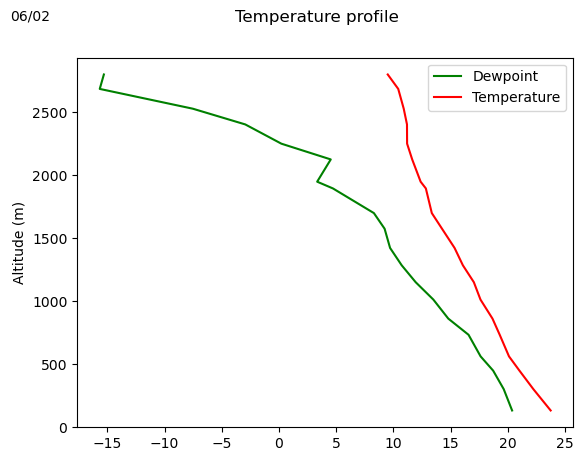

In [139]:
fig,ax = plt.subplots()
ax.plot(DAY2_subset_median['dewpoint'], DAY2_subset_median['GPS_Altitude_THORNHILL'], color = "green", label = 'Dewpoint')
ax.plot(DAY2_subset_median['Static_Air_Temp_THORNHILL'], DAY2_subset_median['GPS_Altitude_THORNHILL'], color = "Red", label = 'Temperature')
ax.set_ylabel('Altitude (m)')
ax.legend()
fig.suptitle('Temperature profile', fontsize=12)
fig.text(0.02, 0.98, '06/02', ha='left', va='top', fontsize=10)

Text(0.02, 0.98, '06/02_pm')

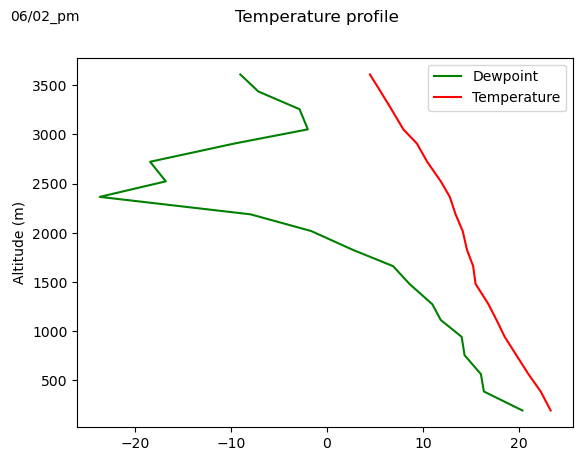

In [140]:
fig,ax = plt.subplots()
ax.plot(DAY2b_subset_median['dewpoint'], DAY2b_subset_median['GPS_Altitude_THORNHILL'], color = "green", label = 'Dewpoint')
ax.plot(DAY2b_subset_median['Static_Air_Temp_THORNHILL'], DAY2b_subset_median['GPS_Altitude_THORNHILL'], color = "Red", label = 'Temperature')
ax.set_ylabel('Altitude (m)')
ax.legend()
fig.suptitle('Temperature profile', fontsize=12)
fig.text(0.02, 0.98, '06/02_pm', ha='left', va='top', fontsize=10)

Text(0.02, 0.98, '06/03')

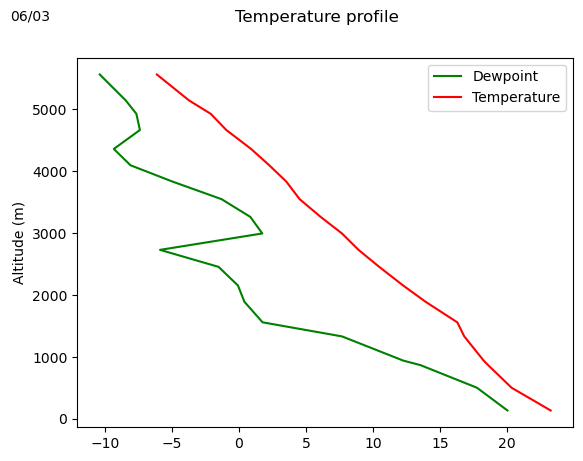

In [141]:
fig,ax = plt.subplots()
ax.plot(DAY3_subset_median['dewpoint'], DAY3_subset_median['GPS_Altitude_THORNHILL'], color = "green", label = 'Dewpoint')
ax.plot(DAY3_subset_median['Static_Air_Temp_THORNHILL'], DAY3_subset_median['GPS_Altitude_THORNHILL'], color = "Red", label = 'Temperature')
ax.set_ylabel('Altitude (m)')
ax.legend()
fig.suptitle('Temperature profile', fontsize=12)
fig.text(0.02, 0.98, '06/03', ha='left', va='top', fontsize=10)

Text(0.02, 0.98, '06/07')

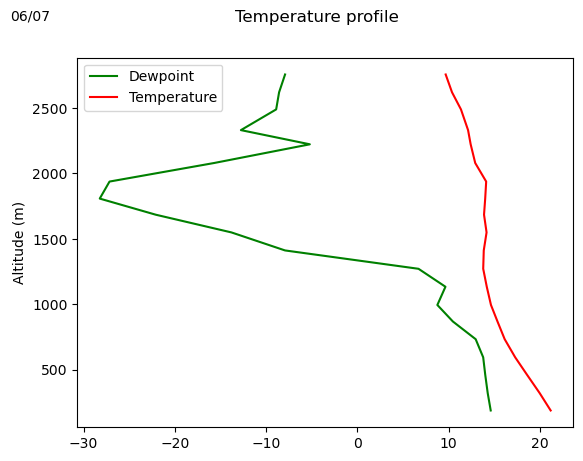

In [142]:
fig,ax = plt.subplots()
ax.plot(DAY7_subset_median['dewpoint'], DAY7_subset_median['GPS_Altitude_THORNHILL'], color = "green", label = 'Dewpoint')
ax.plot(DAY7_subset_median['Static_Air_Temp_THORNHILL'], DAY7_subset_median['GPS_Altitude_THORNHILL'], color = "Red", label = 'Temperature')
ax.set_ylabel('Altitude (m)')
ax.legend()
fig.suptitle('Temperature profile', fontsize=12)
fig.text(0.02, 0.98, '06/07', ha='left', va='top', fontsize=10)

Text(0.02, 0.98, '06/07_pm')

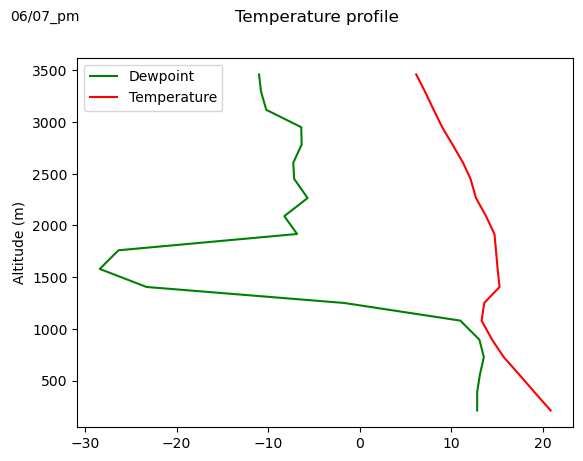

In [143]:
fig,ax = plt.subplots()
ax.plot(DAY7b_subset_median['dewpoint'], DAY7b_subset_median['GPS_Altitude_THORNHILL'], color = "green", label = 'Dewpoint')
ax.plot(DAY7b_subset_median['Static_Air_Temp_THORNHILL'], DAY7b_subset_median['GPS_Altitude_THORNHILL'], color = "Red", label = 'Temperature')
ax.set_ylabel('Altitude (m)')
ax.legend()
fig.suptitle('Temperature profile', fontsize=12)
fig.text(0.02, 0.98, '06/07_pm', ha='left', va='top', fontsize=10)

Text(0.02, 0.98, '06/08')

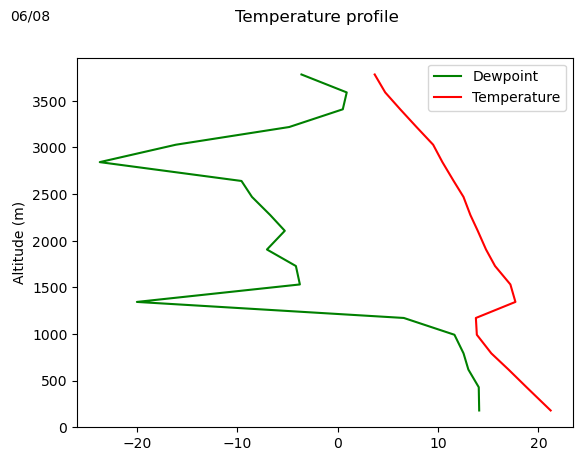

In [144]:
fig,ax = plt.subplots()
ax.plot(DAY8_subset_median['dewpoint'], DAY8_subset_median['GPS_Altitude_THORNHILL'], color = "green", label = 'Dewpoint')
ax.plot(DAY8_subset_median['Static_Air_Temp_THORNHILL'], DAY8_subset_median['GPS_Altitude_THORNHILL'], color = "Red", label = 'Temperature')
ax.set_ylabel('Altitude (m)')
ax.legend()
fig.suptitle('Temperature profile', fontsize=12)
fig.text(0.02, 0.98, '06/08', ha='left', va='top', fontsize=10)

Text(0.02, 0.98, '06/10')

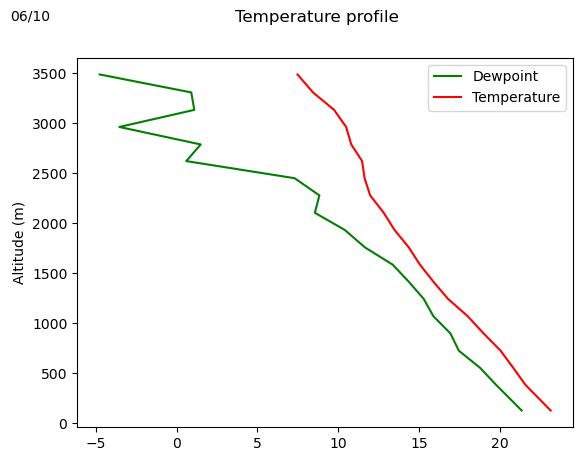

In [145]:
fig,ax = plt.subplots()
ax.plot(DAY10_subset_median['dewpoint'], DAY10_subset_median['GPS_Altitude_THORNHILL'], color = "green", label = 'Dewpoint')
ax.plot(DAY10_subset_median['Static_Air_Temp_THORNHILL'], DAY10_subset_median['GPS_Altitude_THORNHILL'], color = "Red", label = 'Temperature')
ax.set_ylabel('Altitude (m)')
ax.legend()
fig.suptitle('Temperature profile', fontsize=12)
fig.text(0.02, 0.98, '06/10', ha='left', va='top', fontsize=10)

Text(0.02, 0.98, '06/10_pm')

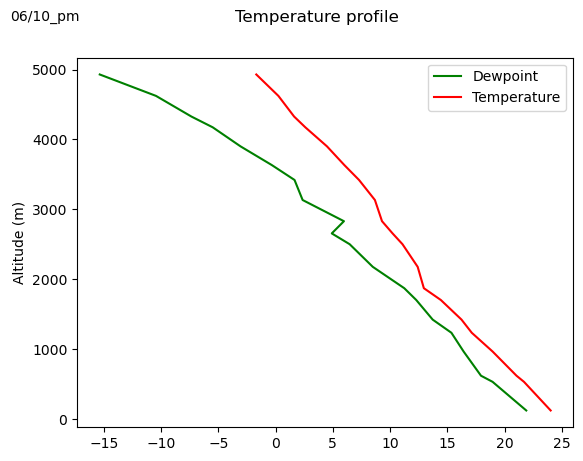

In [146]:
fig,ax = plt.subplots()
ax.plot(DAY10b_subset_median['dewpoint'], DAY10b_subset_median['GPS_Altitude_THORNHILL'], color = "green", label = 'Dewpoint')
ax.plot(DAY10b_subset_median['Static_Air_Temp_THORNHILL'], DAY10b_subset_median['GPS_Altitude_THORNHILL'], color = "Red", label = 'Temperature')
ax.set_ylabel('Altitude (m)')
ax.legend()
fig.suptitle('Temperature profile', fontsize=12)
fig.text(0.02, 0.98, '06/10_pm', ha='left', va='top', fontsize=10)

Text(0.02, 0.98, '06/13')

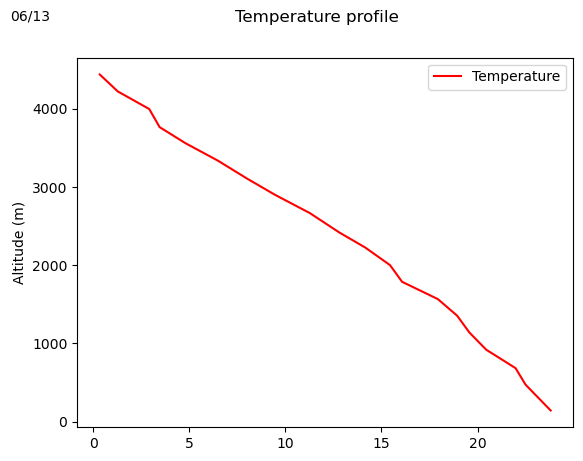

In [147]:
fig,ax = plt.subplots()
#ax.plot(DAY13_subset_median['dewpoint'], DAY13_subset_median['GPS_Altitude_THORNHILL'], color = "green", label = 'Dewpoint')
ax.plot(DAY13_subset_median['Static_Air_Temp_THORNHILL'], DAY13_subset_median['GPS_Altitude_THORNHILL'], color = "Red", label = 'Temperature')
ax.set_ylabel('Altitude (m)')
ax.legend()
fig.suptitle('Temperature profile', fontsize=12)
fig.text(0.02, 0.98, '06/13', ha='left', va='top', fontsize=10)

Text(0.02, 0.98, '06/11_pm')

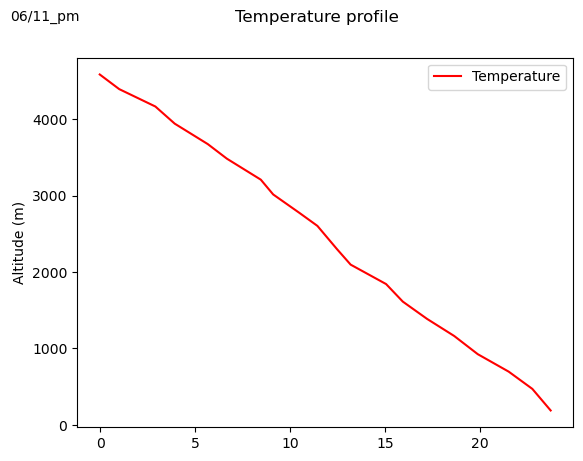

In [203]:
fig,ax = plt.subplots()
#ax.plot(DAY11_subset_median['dewpoint'], DAY11_subset_median['GPS_Altitude_THORNHILL'], color = "green", label = 'Dewpoint')
ax.plot(DAY11_subset_median['Static_Air_Temp_THORNHILL'], DAY11_subset_median['GPS_Altitude_THORNHILL'], color = "Red", label = 'Temperature')
ax.set_ylabel('Altitude (m)')
ax.legend()
fig.suptitle('Temperature profile', fontsize=12)
fig.text(0.02, 0.98, '06/11_pm', ha='left', va='top', fontsize=10)

Text(0.02, 0.98, '06/11_pm')

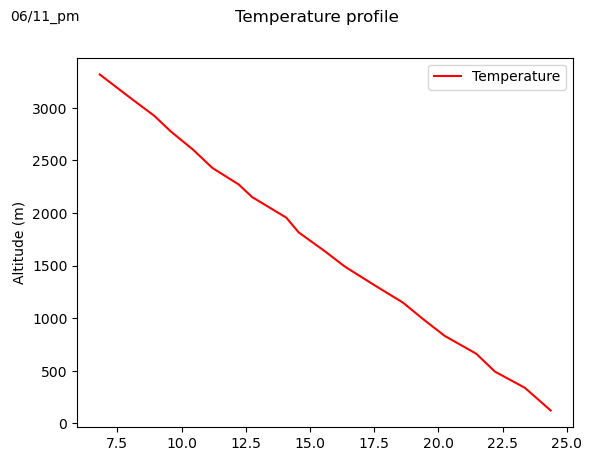

In [201]:
fig,ax = plt.subplots()
#ax.plot(DAY11b_subset_median['dewpoint'], DAY11b_subset_median['GPS_Altitude_THORNHILL'], color = "green", label = 'Dewpoint')
ax.plot(DAY11b_subset_median['Static_Air_Temp_THORNHILL'], DAY11b_subset_median['GPS_Altitude_THORNHILL'], color = "Red", label = 'Temperature')
ax.set_ylabel('Altitude (m)')
ax.legend()
fig.suptitle('Temperature profile', fontsize=12)
fig.text(0.02, 0.98, '06/11_pm', ha='left', va='top', fontsize=10)

Text(0.02, 0.98, '06/13_pm')

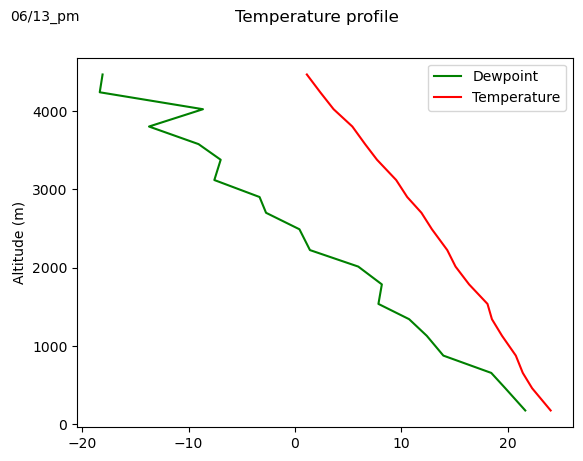

In [148]:
fig,ax = plt.subplots()
ax.plot(DAY13b_subset_median['dewpoint'], DAY13b_subset_median['GPS_Altitude_THORNHILL'], color = "green", label = 'Dewpoint')
ax.plot(DAY13b_subset_median['Static_Air_Temp_THORNHILL'], DAY13b_subset_median['GPS_Altitude_THORNHILL'], color = "Red", label = 'Temperature')
ax.set_ylabel('Altitude (m)')
ax.legend()
fig.suptitle('Temperature profile', fontsize=12)
fig.text(0.02, 0.98, '06/13_pm', ha='left', va='top', fontsize=10)

Text(0.02, 0.98, '06/14')

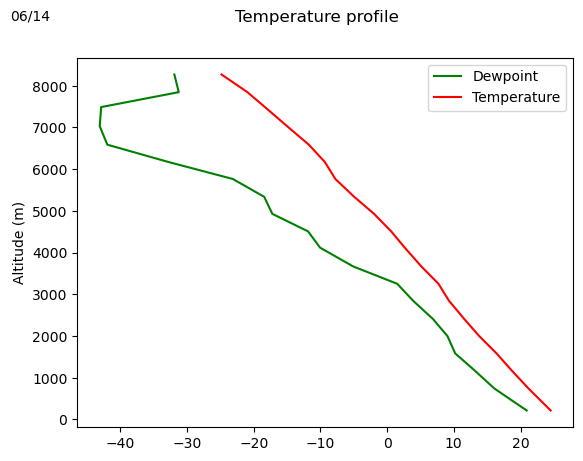

In [149]:
fig,ax = plt.subplots()
ax.plot(DAY14_subset_median['dewpoint'], DAY14_subset_median['GPS_Altitude_THORNHILL'], color = "green", label = 'Dewpoint')
ax.plot(DAY14_subset_median['Static_Air_Temp_THORNHILL'], DAY14_subset_median['GPS_Altitude_THORNHILL'], color = "Red", label = 'Temperature')
ax.set_ylabel('Altitude (m)')
ax.legend()
fig.suptitle('Temperature profile', fontsize=12)
fig.text(0.02, 0.98, '06/14', ha='left', va='top', fontsize=10)

Text(0.02, 0.98, '06/17')

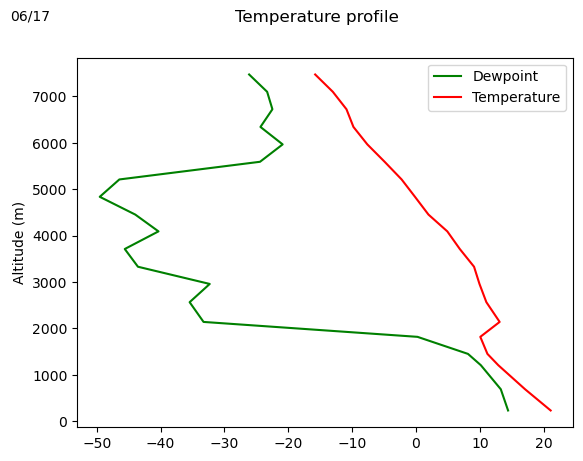

In [150]:
fig,ax = plt.subplots()
ax.plot(DAY17_subset_median['dewpoint'], DAY17_subset_median['GPS_Altitude_THORNHILL'], color = "green", label = 'Dewpoint')
ax.plot(DAY17_subset_median['Static_Air_Temp_THORNHILL'], DAY17_subset_median['GPS_Altitude_THORNHILL'], color = "Red", label = 'Temperature')
ax.set_ylabel('Altitude (m)')
ax.legend()
fig.suptitle('Temperature profile', fontsize=12)
fig.text(0.02, 0.98, '06/17', ha='left', va='top', fontsize=10)

In [188]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY2_subset.GPS_Altitude_THORNHILL.min(), DAY2_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2_subset['Bins'] = pd.cut(DAY2_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY2_subset_1000 = DAY2_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_1000 = DAY2_subset_1000[start_index:stop_index]
DAY1000_subset_1000


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(106.28, 134.006]",2022-06-02 13:58:08.000,2022-06-02 13:58:09.000,32.208306,-65.047757,122.4800,23.8400,995.4450,NaN,NaN,24276.70,NaN,81.70,9.529000e-08,12.3200,0.3150,1.5650,1.3000,NaN,24.374737,20.509991
"(134.006, 161.732]",2022-06-02 13:58:49.000,2022-06-02 13:58:50.000,32.202678,-64.998075,149.2400,23.5700,991.9500,NaN,NaN,24028.20,NaN,81.90,1.203000e-07,12.2300,0.2850,1.4850,1.2250,NaN,24.407165,20.312372
"(161.732, 189.459]",2022-06-02 13:59:02.000,2022-06-02 13:59:03.000,32.210501,-64.983373,174.5650,23.3350,989.2350,NaN,NaN,24068.50,NaN,83.10,1.625000e-07,12.2650,0.3100,1.5500,1.0950,NaN,24.415894,20.262429
"(189.459, 217.185]",2022-06-02 13:57:08.000,2022-06-02 13:57:09.000,32.233247,-65.116465,202.3350,23.0700,985.4450,NaN,NaN,23736.30,NaN,82.90,6.999000e-08,13.9500,0.2350,1.3950,1.1700,NaN,24.444751,20.008369
"(217.185, 244.911]",2022-06-02 13:57:01.500,2022-06-02 13:57:02.500,32.235899,-65.124099,231.2250,22.8475,982.0950,NaN,NaN,23810.60,NaN,83.80,1.003800e-07,12.1100,0.2775,1.4675,1.1600,NaN,24.519065,19.941550
"(244.911, 272.637]",2022-06-02 13:58:08.000,2022-06-02 13:58:09.000,32.231922,-65.051973,260.1525,22.5325,978.6575,NaN,NaN,23844.35,NaN,85.30,1.312000e-07,12.1950,0.2025,1.3325,1.0725,NaN,24.509746,19.942664
"(272.637, 300.363]",2022-06-02 13:59:28.000,2022-06-02 13:59:29.000,32.235911,-64.973962,282.5850,22.3700,977.1400,NaN,NaN,23883.00,NaN,86.20,1.298000e-07,13.0350,0.1800,1.2950,1.1100,NaN,24.497607,19.952521
"(300.363, 328.09]",2022-06-02 13:56:41.500,2022-06-02 13:56:42.500,32.243827,-65.148157,312.9625,22.1450,973.3275,NaN,NaN,23164.75,NaN,84.60,8.004000e-08,12.3825,0.2875,1.5000,1.0675,NaN,24.571255,19.429476
"(328.09, 355.816]",2022-06-02 13:56:33.500,2022-06-02 13:56:34.500,32.246800,-65.158144,339.6750,21.8750,970.0425,NaN,NaN,23086.55,NaN,85.65,2.025000e-07,11.2225,0.2775,1.4775,0.9100,NaN,24.577028,19.358510


In [189]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY2_subset.GPS_Altitude_THORNHILL.min(), DAY2_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2_subset['Bins'] = pd.cut(DAY2_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY2_subset_1000 = DAY2_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_1000 = DAY2_subset_1000[start_index:stop_index]
DAY1000_subset_1000


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(106.28, 134.006]",2022-06-02 13:58:08.000,2022-06-02 13:58:09.000,32.208306,-65.047757,122.4800,23.8400,995.4450,NaN,NaN,24276.70,NaN,81.70,9.529000e-08,12.3200,0.3150,1.5650,1.3000,NaN,24.374737,20.509991
"(134.006, 161.732]",2022-06-02 13:58:49.000,2022-06-02 13:58:50.000,32.202678,-64.998075,149.2400,23.5700,991.9500,NaN,NaN,24028.20,NaN,81.90,1.203000e-07,12.2300,0.2850,1.4850,1.2250,NaN,24.407165,20.312372
"(161.732, 189.459]",2022-06-02 13:59:02.000,2022-06-02 13:59:03.000,32.210501,-64.983373,174.5650,23.3350,989.2350,NaN,NaN,24068.50,NaN,83.10,1.625000e-07,12.2650,0.3100,1.5500,1.0950,NaN,24.415894,20.262429
"(189.459, 217.185]",2022-06-02 13:57:08.000,2022-06-02 13:57:09.000,32.233247,-65.116465,202.3350,23.0700,985.4450,NaN,NaN,23736.30,NaN,82.90,6.999000e-08,13.9500,0.2350,1.3950,1.1700,NaN,24.444751,20.008369
"(217.185, 244.911]",2022-06-02 13:57:01.500,2022-06-02 13:57:02.500,32.235899,-65.124099,231.2250,22.8475,982.0950,NaN,NaN,23810.60,NaN,83.80,1.003800e-07,12.1100,0.2775,1.4675,1.1600,NaN,24.519065,19.941550
"(244.911, 272.637]",2022-06-02 13:58:08.000,2022-06-02 13:58:09.000,32.231922,-65.051973,260.1525,22.5325,978.6575,NaN,NaN,23844.35,NaN,85.30,1.312000e-07,12.1950,0.2025,1.3325,1.0725,NaN,24.509746,19.942664
"(272.637, 300.363]",2022-06-02 13:59:28.000,2022-06-02 13:59:29.000,32.235911,-64.973962,282.5850,22.3700,977.1400,NaN,NaN,23883.00,NaN,86.20,1.298000e-07,13.0350,0.1800,1.2950,1.1100,NaN,24.497607,19.952521
"(300.363, 328.09]",2022-06-02 13:56:41.500,2022-06-02 13:56:42.500,32.243827,-65.148157,312.9625,22.1450,973.3275,NaN,NaN,23164.75,NaN,84.60,8.004000e-08,12.3825,0.2875,1.5000,1.0675,NaN,24.571255,19.429476
"(328.09, 355.816]",2022-06-02 13:56:33.500,2022-06-02 13:56:34.500,32.246800,-65.158144,339.6750,21.8750,970.0425,NaN,NaN,23086.55,NaN,85.65,2.025000e-07,11.2225,0.2775,1.4775,0.9100,NaN,24.577028,19.358510


In [190]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_3000 = DAY2_subset_1000[start_index:stop_index]
DAY3000_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(993.518, 1021.245]",2022-06-02 14:02:19.500,2022-06-02 14:02:20.500,32.232227,-64.969261,1005.710,17.6350,897.6675,5.4850,265.7437,18443.75,NaN,82.20,1.097000e-08,10.1600,0.2475,1.4675,1.2550,NaN,26.945997,14.547844
"(1021.245, 1048.971]",2022-06-02 14:02:24.500,2022-06-02 14:02:25.500,32.235766,-64.963898,1036.645,17.5150,894.3525,5.5050,264.1824,17641.80,NaN,78.75,3.026000e-08,8.6775,0.4275,1.8200,1.3575,NaN,27.068741,13.780536
"(1048.971, 1076.697]",2022-06-02 14:02:31.500,2022-06-02 14:02:32.500,32.240709,-64.957500,1060.535,17.4825,892.2700,5.5025,261.6160,16856.25,NaN,75.15,6.225500e-09,6.4275,0.5450,2.1700,1.4350,NaN,27.212470,13.054759
"(1076.697, 1104.423]",2022-06-02 14:02:37.500,2022-06-02 14:02:38.500,32.247281,-64.953153,1089.530,17.3925,888.9925,5.4350,261.7390,16405.00,NaN,73.40,0.000000e+00,6.8100,0.3700,1.6825,1.1875,NaN,27.540502,12.571099
"(1104.423, 1132.149]",2022-06-02 14:02:43.000,2022-06-02 14:02:44.000,32.252841,-64.950287,1119.480,17.2600,886.0350,5.5300,258.7711,15828.60,NaN,71.70,1.093000e-08,7.7450,0.1900,1.3050,1.1850,NaN,27.654017,12.040784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2712.543, 2740.269]",2022-06-02 14:09:22.000,2022-06-02 14:09:23.000,32.239725,-64.957045,2729.930,10.1000,731.0550,NaN,NaN,2234.88,NaN,13.20,0.000000e+00,5.0700,0.0025,1.0050,1.4750,NaN,36.781304,-16.940295
"(2740.269, 2767.995]",2022-06-02 14:09:30.500,2022-06-02 14:09:31.500,32.249106,-64.955641,2751.515,9.8000,728.7800,NaN,NaN,2321.67,NaN,14.00,0.000000e+00,6.5375,0.1200,1.1700,1.4725,NaN,36.736280,-16.557451
"(2767.995, 2795.721]",2022-06-02 14:09:38.000,2022-06-02 14:09:39.000,32.257341,-64.957280,2784.750,9.5650,726.0950,NaN,NaN,2472.48,NaN,15.10,0.000000e+00,5.8500,-0.1075,0.8625,1.4300,NaN,36.736659,-15.786115


In [153]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY2b_subset.GPS_Altitude_THORNHILL.min(), DAY2b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2b_subset['Bins'] = pd.cut(DAY2b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY2b_subset_1000 = DAY2b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_1000b = DAY2b_subset_1000[start_index:stop_index]
DAY1000_subset_1000b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(132.5, 168.217]",2022-06-02 18:36:33.500,2022-06-02 18:36:34.500,32.294860,-65.039923,151.3675,23.6775,990.5250,NaN,NaN,24128.55,NaN,81.80,5.269000e-08,12.1150,0.2475,1.4175,1.1600,NaN,592.388103,20.366432
"(168.217, 203.933]",2022-06-02 18:36:12.000,2022-06-02 18:36:13.000,32.310300,-65.023333,186.7200,23.3100,986.3800,NaN,NaN,24360.20,NaN,83.70,7.071000e-08,11.8850,0.3000,1.5300,1.1500,NaN,595.190195,20.425392
"(203.933, 239.65]",2022-06-02 18:37:02.000,2022-06-02 18:37:03.000,32.265793,-65.038849,214.3750,23.0900,983.4100,NaN,NaN,24266.90,NaN,84.70,7.584000e-08,11.9300,0.1350,1.2150,1.1150,NaN,596.900792,20.298492
"(239.65, 275.366]",2022-06-02 18:37:13.000,2022-06-02 18:37:14.000,32.254715,-65.034943,260.1500,22.7500,978.2450,NaN,NaN,24344.30,NaN,86.00,6.848000e-08,12.3750,0.1000,1.1450,1.2200,NaN,599.594824,20.317046
"(275.366, 311.083]",2022-06-02 18:37:24.000,2022-06-02 18:37:25.000,32.245041,-65.027102,289.4500,22.5300,974.7150,NaN,NaN,23640.90,NaN,84.70,9.008000e-08,9.3550,0.2700,1.4550,1.2250,NaN,601.371496,19.801918
"(311.083, 346.8]",2022-06-02 18:37:38.000,2022-06-02 18:37:39.000,32.237004,-65.011946,332.1600,22.4900,970.1450,NaN,NaN,20334.30,NaN,72.30,1.047000e-08,10.3700,0.1350,1.2150,1.3300,NaN,601.697411,17.323913
"(346.8, 382.516]",2022-06-02 18:37:53.000,2022-06-02 18:37:54.000,32.236630,-64.992675,362.9050,22.5200,967.0950,NaN,NaN,18391.70,NaN,65.40,0.000000e+00,7.0450,0.2650,1.5000,1.4550,NaN,601.452891,15.714393
"(382.516, 418.233]",2022-06-02 18:38:07.000,2022-06-02 18:38:08.000,32.244388,-64.977146,399.5450,22.1850,963.0600,NaN,NaN,18077.40,NaN,65.10,0.000000e+00,9.7900,0.2100,1.3450,1.1600,NaN,604.212278,15.205096
"(418.233, 453.949]",2022-06-02 18:38:19.000,2022-06-02 18:38:20.000,32.255430,-64.969121,432.9000,22.0200,959.4350,NaN,NaN,18607.20,NaN,67.60,0.000000e+00,7.9950,0.3050,1.5600,1.1300,NaN,605.595106,15.755443


In [154]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_3000b = DAY2b_subset_1000[start_index:stop_index]
DAY3000_subset_3000b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(989.698, 1025.415]",2022-06-02 18:41:23.000,2022-06-02 18:41:24.000,32.269872,-64.947192,1010.300,18.3050,897.3050,NaN,NaN,17055.600,NaN,72.70,0.000000e+00,4.8950,0.2550,1.4200,0.9750,NaN,641.591947,13.322661
"(1025.415, 1061.132]",2022-06-02 18:41:31.500,2022-06-02 18:41:32.500,32.278880,-64.945719,1046.060,18.0675,893.2625,NaN,NaN,16420.850,NaN,70.85,0.000000e+00,6.6525,0.0450,1.0775,1.2725,NaN,644.264708,12.700271
"(1061.132, 1096.848]",2022-06-02 18:41:40.500,2022-06-02 18:41:41.500,32.288332,-64.947078,1080.155,17.7900,889.7125,NaN,NaN,15890.650,NaN,69.35,0.000000e+00,6.6225,0.0775,1.1250,1.3000,NaN,647.454113,12.111074
"(1096.848, 1132.565]",2022-06-02 18:41:52.500,2022-06-02 18:41:53.500,32.299232,-64.954250,1111.995,17.6225,885.9875,NaN,NaN,15538.350,NaN,68.05,7.180000e-09,7.1550,0.2825,1.4875,1.6650,NaN,649.415222,11.689534
"(1132.565, 1168.281]",2022-06-02 18:42:04.500,2022-06-02 18:42:05.500,32.306221,-64.966341,1150.090,17.5925,882.3750,NaN,NaN,15557.800,NaN,68.10,0.000000e+00,6.4075,0.2825,1.4900,1.5325,NaN,649.770072,11.690982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3275.561, 3311.277]",2022-06-02 18:51:48.500,2022-06-02 18:51:49.500,32.275042,-65.008039,3293.650,6.6000,683.3250,NaN,NaN,6357.465,NaN,44.65,0.000000e+00,0.0300,NaN,NaN,NaN,NaN,902.083960,-4.622188
"(3311.277, 3346.994]",2022-06-02 18:51:54.000,2022-06-02 18:51:55.000,32.268640,-65.008712,3329.670,6.3600,680.2050,NaN,NaN,5988.020,NaN,42.50,0.000000e+00,0.6800,NaN,NaN,NaN,NaN,913.570572,-5.467730
"(3346.994, 3382.711]",2022-06-02 18:51:59.000,2022-06-02 18:52:00.000,32.262831,-65.009201,3366.390,6.1750,677.2650,NaN,NaN,5453.110,NaN,39.00,0.000000e+00,2.4000,NaN,NaN,NaN,NaN,922.833610,-6.737951


In [186]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY3_subset.GPS_Altitude_THORNHILL.min(), DAY3_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY3_subset['Bins'] = pd.cut(DAY3_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY3_subset_1000 = DAY3_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_3 = DAY3_subset_1000[start_index:stop_index]
DAY1000_subset_3

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(94.825, 149.89]",2022-06-03 13:45:28.500,2022-06-03 13:45:29.500,34.142639,-67.165956,122.9500,23.3700,990.6750,4.8525,250.02470,23878.25,NaN,82.20,4.259000e-08,11.9450,0.1850,1.3000,1.2150,NaN,594.728022,20.174466
"(149.89, 204.956]",2022-06-03 13:54:59.500,2022-06-03 13:55:00.500,33.928738,-67.590937,187.3925,22.7175,983.2550,NaN,NaN,23960.45,NaN,85.50,5.586500e-08,11.7950,0.1800,1.2950,1.1225,NaN,599.855612,20.111464
"(204.956, 260.021]",2022-06-03 14:00:22.500,2022-06-03 14:00:23.500,34.111793,-67.404486,247.7050,22.2500,976.3500,2.7800,257.87780,23592.90,NaN,85.70,6.117000e-08,12.6250,0.1975,1.3225,1.2600,1.3725,603.671868,19.757952
"(260.021, 315.086]",2022-06-03 13:56:57.000,2022-06-03 13:56:58.000,33.959246,-67.563614,275.4400,22.0700,974.0150,2.1975,245.65870,23121.60,NaN,85.20,4.721000e-08,12.1450,0.2000,1.3300,1.2550,1.4350,605.174387,19.367317
"(315.086, 370.151]",2022-06-03 13:55:36.500,2022-06-03 13:55:37.500,33.976991,-67.341925,339.8950,21.6000,966.8325,NaN,NaN,22841.80,NaN,85.90,8.206000e-08,13.1000,0.1575,1.2550,1.2100,1.3150,609.188032,19.100924
"(370.151, 425.217]",2022-06-03 14:04:58.500,2022-06-03 14:04:59.500,34.251154,-67.066855,406.7575,21.3975,957.9025,NaN,NaN,20761.45,NaN,79.25,4.219500e-08,10.6675,0.2000,1.3425,1.1050,1.4700,610.958999,17.429874
"(425.217, 480.282]",2022-06-03 14:05:23.500,2022-06-03 14:05:24.500,34.249331,-67.072107,456.6750,20.6875,952.5050,5.5050,257.46460,20767.00,NaN,81.55,3.775000e-08,11.4600,0.2325,1.4025,1.0825,1.5500,617.375429,17.297887
"(480.282, 535.347]",2022-06-03 14:10:05.000,2022-06-03 14:10:06.000,34.179626,-67.299747,499.2650,20.3150,948.1400,5.9200,242.76880,21570.50,NaN,85.60,7.819000e-08,14.4000,0.3050,1.5400,1.1750,1.7500,620.877482,17.848610
"(535.347, 590.412]",2022-06-03 14:14:56.000,2022-06-03 14:14:57.000,33.993495,-67.622091,562.7650,20.4850,941.6550,NaN,NaN,20077.00,NaN,78.50,4.901000e-09,9.9850,0.3250,1.5650,1.1050,NaN,619.267242,16.514846


In [185]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3_subset_3000 = DAY3_subset_1000[start_index:stop_index]
DAY3_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(975.869, 1030.934]",2022-06-03 14:16:33.500,2022-06-03 14:16:34.500,33.965128,-67.706089,1003.240,17.7325,893.3225,NaN,NaN,15776.900,NaN,69.90,0.000000e+00,8.6525,0.2550,1.4500,0.8700,NaN,648.124266,12.082167
"(1030.934, 1086.0]",2022-06-03 14:16:45.000,2022-06-03 14:16:46.000,33.975829,-67.718794,1059.470,17.4450,887.3150,NaN,NaN,15773.600,NaN,70.70,5.563000e-09,8.0400,0.2200,1.3950,0.8800,NaN,651.523699,11.977332
"(1086.0, 1141.065]",2022-06-03 14:16:31.500,2022-06-03 14:16:32.500,33.988404,-67.726647,1108.940,17.8075,882.4175,NaN,NaN,13819.600,NaN,59.30,0.000000e+00,5.8200,0.2425,1.4550,1.0800,NaN,647.250800,9.865002
"(1141.065, 1196.13]",2022-06-03 13:33:26.500,2022-06-03 13:33:27.500,33.858219,-67.077414,1171.680,17.8375,876.0025,NaN,NaN,12413.150,NaN,53.10,0.000000e+00,6.1900,0.1600,1.2500,1.0600,NaN,646.903307,8.160627
"(1196.13, 1251.195]",2022-06-03 14:25:41.000,2022-06-03 14:25:42.000,34.283454,-67.038518,1211.990,17.5050,872.4400,NaN,NaN,12820.600,NaN,56.00,0.000000e+00,6.2450,0.1200,1.1900,0.9400,NaN,650.807442,8.608259
"(1251.195, 1306.26]",2022-06-03 13:33:12.000,2022-06-03 13:33:13.000,33.862823,-67.056964,1279.990,17.2050,865.3350,NaN,NaN,12625.400,NaN,55.70,0.000000e+00,6.8800,0.1775,1.2800,1.2650,NaN,654.425468,8.244899
"(1306.26, 1361.326]",2022-06-03 13:59:32.500,2022-06-03 13:59:33.500,34.076123,-67.027614,1337.770,16.7200,859.4925,NaN,NaN,11978.850,NaN,54.15,0.000000e+00,5.2500,0.2025,1.3475,0.9925,NaN,660.475492,7.387822
"(1361.326, 1416.391]",2022-06-03 14:26:11.500,2022-06-03 14:26:12.500,34.301374,-67.000262,1382.065,16.2950,854.6025,NaN,NaN,11945.450,NaN,55.20,0.000000e+00,6.8350,0.0925,1.1500,0.6875,NaN,665.992389,7.308433
"(1416.391, 1471.456]",2022-06-03 13:32:49.000,2022-06-03 13:32:50.000,33.856856,-67.027029,1443.090,16.1350,848.4600,NaN,NaN,11272.600,NaN,52.10,0.000000e+00,5.9750,0.1850,1.2900,0.9350,1.3700,668.124191,6.329745


In [158]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY7_subset.GPS_Altitude_THORNHILL.min(), DAY7_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7_subset['Bins'] = pd.cut(DAY7_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY7_subset_1000 = DAY7_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_7 = DAY7_subset_1000[start_index:stop_index]
DAY1000_subset_7


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(125.87, 152.826]",2022-06-07 14:32:05.500,2022-06-07 14:32:06.500,32.247084,-64.993783,130.6300,21.6925,1000.4850,NaN,NaN,16833.70,NaN,64.95,2.179000e-07,22.1575,0.2525,1.4150,0.5400,NaN,608.387616,14.788188
"(152.826, 179.781]",2022-06-07 14:32:14.000,2022-06-07 14:32:15.000,32.241242,-64.985855,172.0250,21.3650,995.8550,NaN,NaN,16633.10,NaN,64.90,9.496000e-08,22.3150,0.2350,1.3900,0.6750,NaN,611.245434,14.527150
"(179.781, 206.737]",2022-06-07 14:32:27.500,2022-06-07 14:32:28.500,32.229405,-64.976252,188.3900,21.1800,993.9675,NaN,NaN,16739.40,NaN,66.30,2.155000e-07,21.5700,0.2300,1.3800,0.7775,NaN,612.889603,14.585410
"(206.737, 233.692]",2022-06-07 14:32:40.000,2022-06-07 14:32:41.000,32.216014,-64.972467,219.6400,20.9100,989.9300,NaN,NaN,17178.30,NaN,68.80,2.098000e-07,22.8050,0.2150,1.3850,0.8450,NaN,615.328906,14.922239
"(233.692, 260.648]",2022-06-07 14:32:48.000,2022-06-07 14:32:49.000,32.207231,-64.973025,250.9800,20.6900,986.6750,NaN,NaN,16564.50,NaN,67.00,1.416000e-07,21.3650,0.4200,1.8400,0.7550,NaN,617.352230,14.349474
"(260.648, 287.604]",2022-06-07 14:33:01.000,2022-06-07 14:33:02.000,32.193921,-64.978990,261.7850,20.5250,985.4700,NaN,NaN,16561.90,NaN,67.60,2.134000e-07,22.7800,0.2250,1.3700,0.7150,NaN,618.891303,14.311404
"(287.604, 314.559]",2022-06-07 14:33:13.500,2022-06-07 14:33:14.500,32.184462,-64.990490,305.6750,20.1525,980.5075,NaN,NaN,16836.65,NaN,69.95,1.656500e-07,21.2050,0.3200,1.5750,0.6975,NaN,622.435925,14.493816
"(314.559, 341.515]",2022-06-07 14:33:26.000,2022-06-07 14:33:27.000,32.179369,-65.005060,326.2850,19.9350,978.0750,NaN,NaN,16685.70,NaN,70.00,1.968000e-07,22.3750,0.2550,1.4350,0.7000,NaN,624.551687,14.294503
"(341.515, 368.47]",2022-06-07 14:33:38.000,2022-06-07 14:33:39.000,32.179429,-65.019922,353.5650,19.6950,974.8950,NaN,NaN,16634.50,NaN,70.70,2.412000e-07,23.7300,0.1900,1.3050,0.7050,NaN,626.927177,14.197822


In [159]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY7_subset_3000 = DAY7_subset_1000[start_index:stop_index]
DAY7_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(1015.405, 1042.36]",2022-06-07 14:38:12.000,2022-06-07 14:38:13.000,32.229355,-65.062216,1030.120,14.470,900.025,NaN,NaN,12209.90,NaN,67.1,2.211000e-08,13.2450,0.4750,2.000,1.0200,NaN,692.297641,8.395409
"(1042.36, 1069.316]",2022-06-07 14:38:21.000,2022-06-07 14:38:22.000,32.237006,-65.057784,1055.940,14.425,897.535,NaN,NaN,13213.20,NaN,71.5,1.188000e-07,15.7300,0.3200,1.555,0.8900,NaN,693.006330,9.431635
"(1069.316, 1096.272]",2022-06-07 14:38:32.000,2022-06-07 14:38:33.000,32.245194,-65.050061,1084.140,14.435,894.605,NaN,NaN,13451.00,NaN,72.5,1.064000e-07,15.3400,0.3200,1.560,0.8450,NaN,692.848569,9.675503
"(1096.272, 1123.227]",2022-06-07 14:38:42.500,2022-06-07 14:38:43.500,32.251219,-65.040481,1107.855,14.420,892.245,NaN,NaN,13452.75,NaN,72.9,8.324000e-08,17.2925,0.3475,1.650,0.8225,NaN,693.085978,9.633583
"(1123.227, 1150.183]",2022-06-07 14:38:52.000,2022-06-07 14:38:53.000,32.254166,-65.030077,1136.620,14.125,889.230,NaN,NaN,13580.60,NaN,74.8,4.882000e-08,16.5550,0.3350,1.600,0.8300,NaN,697.813472,9.719004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2659.696, 2686.652]",2022-06-07 14:46:31.000,2022-06-07 14:46:32.000,32.246810,-65.029401,2672.740,10.010,739.960,NaN,NaN,4284.25,NaN,25.7,0.000000e+00,NaN,NaN,NaN,NaN,NaN,782.895568,-8.764561
"(2686.652, 2713.608]",2022-06-07 14:46:36.000,2022-06-07 14:46:37.000,32.249493,-65.023658,2699.640,9.815,737.520,NaN,NaN,4244.34,NaN,25.8,0.000000e+00,NaN,NaN,NaN,NaN,NaN,788.118969,-8.897501
"(2713.608, 2740.563]",2022-06-07 14:46:41.000,2022-06-07 14:46:42.000,32.251676,-65.017607,2726.120,9.720,735.165,NaN,NaN,4381.67,NaN,26.7,0.000000e+00,NaN,NaN,NaN,NaN,NaN,790.716062,-8.539853


In [160]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY7b_subset.GPS_Altitude_THORNHILL.min(), DAY7b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7b_subset['Bins'] = pd.cut(DAY7b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY7b_subset_1000 = DAY7b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_7b = DAY7b_subset_1000[start_index:stop_index]
DAY1000_subset_7b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(132.595, 166.728]",2022-06-07 19:08:09.000,2022-06-07 19:08:10.000,32.245348,-64.993377,138.9650,21.4500,998.6300,NaN,NaN,15336.20,NaN,59.80,1.994000e-07,NaN,NaN,NaN,NaN,NaN,610.497283,12.967705
"(166.728, 200.861]",2022-06-07 19:08:21.500,2022-06-07 19:08:22.500,32.252398,-64.980762,183.5400,21.2000,993.8550,NaN,NaN,15427.85,NaN,60.70,2.079500e-07,NaN,NaN,NaN,NaN,NaN,612.710824,12.962790
"(200.861, 234.994]",2022-06-07 19:08:31.500,2022-06-07 19:08:32.500,32.261138,-64.974323,217.5125,20.8025,990.1900,NaN,NaN,15096.60,NaN,60.80,2.017000e-07,NaN,NaN,NaN,NaN,NaN,616.313562,12.772884
"(234.994, 269.127]",2022-06-07 19:08:42.500,2022-06-07 19:08:43.500,32.272447,-64.972235,251.5325,20.4650,986.2075,NaN,NaN,15034.05,NaN,61.60,2.202000e-07,NaN,NaN,NaN,NaN,NaN,619.455943,12.846411
"(269.127, 303.26]",2022-06-07 19:08:51.500,2022-06-07 19:08:52.500,32.281722,-64.974383,286.8050,20.1600,982.3000,NaN,NaN,15030.95,NaN,62.75,2.843000e-07,NaN,NaN,NaN,NaN,NaN,622.363751,12.798117
"(303.26, 337.393]",2022-06-07 19:09:01.500,2022-06-07 19:09:02.500,32.290928,-64.980598,318.2300,19.7975,978.7275,NaN,NaN,15002.00,NaN,63.50,1.810000e-07,NaN,NaN,NaN,NaN,NaN,625.907357,12.846080
"(337.393, 371.526]",2022-06-07 19:09:12.000,2022-06-07 19:09:13.000,32.298341,-64.990692,354.8600,19.4450,974.2550,NaN,NaN,15002.20,NaN,64.50,2.483000e-07,NaN,NaN,NaN,NaN,NaN,629.448438,12.885949
"(371.526, 405.659]",2022-06-07 19:09:23.500,2022-06-07 19:09:24.500,32.302729,-65.004544,389.4000,19.0925,970.6000,NaN,NaN,14780.35,NaN,64.95,2.266500e-07,NaN,NaN,NaN,NaN,NaN,633.087366,12.648419
"(405.659, 439.792]",2022-06-07 19:09:35.000,2022-06-07 19:09:36.000,32.302622,-65.019577,421.5550,18.7250,966.8600,NaN,NaN,15069.70,NaN,67.40,2.605000e-07,NaN,NaN,NaN,NaN,NaN,636.989697,12.935128


In [161]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY7b_subset_3000 = DAY7b_subset_1000[start_index:stop_index]
DAY7b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(985.921, 1020.054]",2022-06-07 19:12:28.500,2022-06-07 19:12:29.500,32.296267,-64.998305,1003.240,13.5550,902.8275,NaN,NaN,14033.300,NaN,81.55,2.526000e-07,NaN,NaN,NaN,NaN,NaN,707.362967,12.457932
"(1020.054, 1054.187]",2022-06-07 19:12:38.500,2022-06-07 19:12:39.500,32.300110,-65.010330,1036.910,13.4800,899.2625,NaN,NaN,13526.100,NaN,78.80,1.841000e-07,NaN,NaN,NaN,NaN,NaN,708.662440,11.740367
"(1054.187, 1088.32]",2022-06-07 19:12:48.000,2022-06-07 19:12:49.000,32.300666,-65.022512,1072.330,13.4250,895.4200,NaN,NaN,13009.700,NaN,75.90,1.905000e-07,NaN,NaN,NaN,NaN,NaN,709.621600,11.062984
"(1088.32, 1122.453]",2022-06-07 19:12:58.500,2022-06-07 19:12:59.500,32.297754,-65.035518,1104.765,13.1825,892.0550,NaN,NaN,12669.550,NaN,74.55,1.685000e-07,NaN,NaN,NaN,NaN,NaN,713.919346,10.696827
"(1122.453, 1156.586]",2022-06-07 19:13:10.500,2022-06-07 19:13:11.500,32.290292,-65.048118,1140.005,13.1800,888.3075,NaN,NaN,10974.100,NaN,64.20,1.274000e-07,NaN,NaN,NaN,NaN,NaN,713.964280,8.338485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3306.969, 3341.102]",2022-06-07 19:22:24.000,2022-06-07 19:22:25.000,32.278740,-64.979743,3325.470,6.9200,683.8950,NaN,NaN,3296.810,NaN,22.70,0.000000e+00,NaN,NaN,NaN,NaN,NaN,887.610413,-10.680758
"(3341.102, 3375.235]",2022-06-07 19:22:29.500,2022-06-07 19:22:30.500,32.283576,-64.983815,3359.530,6.7100,681.0225,NaN,NaN,3264.305,NaN,22.70,0.000000e+00,NaN,NaN,NaN,NaN,NaN,897.003515,-10.798848
"(3375.235, 3409.368]",2022-06-07 19:22:35.000,2022-06-07 19:22:36.000,32.287903,-64.988645,3393.950,6.5200,678.0550,NaN,NaN,3219.500,NaN,22.50,0.000000e+00,NaN,NaN,NaN,NaN,NaN,905.847361,-10.985555


In [162]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY8_subset.GPS_Altitude_THORNHILL.min(), DAY8_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY8_subset['Bins'] = pd.cut(DAY8_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY8_subset_1000 = DAY8_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_8 = DAY8_subset_1000[start_index:stop_index]
DAY1000_subset_8


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(147.455, 184.705]",2022-06-08 20:30:28.000,2022-06-08 20:30:29.000,32.293626,-65.017848,154.5400,21.3950,996.9550,NaN,NaN,15884.30,NaN,62.10,1.268000e-07,12.8850,-0.0700,0.9100,0.5250,NaN,610.980862,13.845462
"(184.705, 221.955]",2022-06-08 20:31:07.000,2022-06-08 20:31:08.000,32.300051,-65.066294,198.9850,20.9800,991.9150,NaN,NaN,16313.00,NaN,65.10,1.243000e-07,12.2300,0.0450,1.0700,0.7950,NaN,614.691901,14.209469
"(221.955, 259.205]",2022-06-08 20:31:21.500,2022-06-08 20:31:22.500,32.291698,-65.080461,242.1600,20.6400,987.4825,NaN,NaN,16682.40,NaN,67.75,1.402000e-07,12.1325,-0.0350,0.9675,0.8000,NaN,617.816677,14.484399
"(259.205, 296.455]",2022-06-08 20:31:32.500,2022-06-08 20:31:33.500,32.282742,-65.087275,278.0025,20.3325,983.6550,NaN,NaN,16519.60,NaN,68.10,1.678500e-07,13.4925,-0.0525,0.9550,0.7925,NaN,620.710889,14.268278
"(296.455, 333.705]",2022-06-08 20:31:44.000,2022-06-08 20:31:45.000,32.272093,-65.089858,314.4600,19.9150,979.2900,NaN,NaN,16686.80,NaN,70.20,2.726000e-07,14.8550,-0.1650,0.8050,0.7400,NaN,624.747995,14.343814
"(333.705, 370.955]",2022-06-08 20:31:54.500,2022-06-08 20:31:55.500,32.262326,-65.088323,352.5375,19.5750,975.0025,NaN,NaN,16662.45,NaN,71.30,8.761500e-08,13.3075,-0.0500,0.9550,0.9000,NaN,628.131377,14.264218
"(370.955, 408.205]",2022-06-08 20:32:04.500,2022-06-08 20:32:05.500,32.253920,-65.083280,389.1225,19.2075,970.8275,NaN,NaN,16680.45,NaN,73.15,1.349450e-07,14.9625,-0.1225,0.8625,0.8475,NaN,631.889218,14.220364
"(408.205, 445.455]",2022-06-08 20:32:15.500,2022-06-08 20:32:16.500,32.246596,-65.074434,425.9075,18.8450,966.3325,NaN,NaN,16300.65,NaN,72.45,2.257000e-07,13.6000,-0.1125,0.8675,0.8200,NaN,635.703115,13.789143
"(445.455, 482.705]",2022-06-08 20:32:27.000,2022-06-08 20:32:28.000,32.241922,-65.062468,462.3600,18.4650,962.2100,NaN,NaN,16561.10,NaN,74.70,1.044000e-07,12.4250,0.0050,1.0200,0.7650,NaN,639.820332,14.001024


In [163]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY8_subset_3000 = DAY8_subset_1000[start_index:stop_index]
DAY8_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(1004.206, 1041.456]",2022-06-08 20:35:22.000,2022-06-08 20:35:23.000,32.281187,-65.081965,1020.120,13.7750,900.7750,NaN,NaN,15346.500,NaN,86.90,2.750000e-04,26.1800,0.2450,1.4100,0.4350,NaN,703.610271,11.632932
"(1041.456, 1078.706]",2022-06-08 20:35:35.000,2022-06-08 20:35:36.000,32.268765,-65.078655,1060.190,13.4900,896.3200,NaN,NaN,14229.400,NaN,82.60,1.395000e-07,15.4450,0.2600,1.4350,0.7000,NaN,708.488402,10.530234
"(1078.706, 1115.956]",2022-06-08 20:35:48.500,2022-06-08 20:35:49.500,32.257159,-65.071069,1096.685,13.1750,891.7925,NaN,NaN,14333.900,NaN,84.65,1.927500e-07,14.8025,0.1625,1.2650,0.7700,NaN,714.065743,10.580041
"(1115.956, 1153.206]",2022-06-08 20:36:00.500,2022-06-08 20:36:01.500,32.249873,-65.060165,1134.755,12.9350,888.3375,NaN,NaN,14203.500,NaN,84.55,1.672000e-07,14.5550,0.0925,1.1525,0.8575,NaN,718.423577,10.400273
"(1153.206, 1190.456]",2022-06-08 20:36:12.500,2022-06-08 20:36:13.500,32.247776,-65.046364,1173.080,13.7825,884.1300,NaN,NaN,11223.800,NaN,63.25,4.234500e-08,8.9850,0.2675,1.4625,1.3275,NaN,703.484117,6.564277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3276.459, 3313.709]",2022-06-08 20:43:51.000,2022-06-08 20:43:52.000,32.296100,-65.043959,3293.800,7.2500,686.6900,NaN,NaN,6326.670,NaN,42.80,0.000000e+00,3.0850,NaN,NaN,NaN,NaN,873.606648,-4.577641
"(3313.709, 3350.959]",2022-06-08 20:43:55.500,2022-06-08 20:43:56.500,32.297077,-65.049657,3332.045,6.8850,683.5400,NaN,NaN,8261.435,NaN,57.00,0.000000e+00,3.7150,NaN,NaN,NaN,1.1300,889.152558,-1.070465
"(3350.959, 3388.209]",2022-06-08 20:44:00.000,2022-06-08 20:44:01.000,32.297241,-65.055479,3370.540,6.5050,680.2650,NaN,NaN,9344.580,NaN,66.10,0.000000e+00,8.7850,NaN,NaN,NaN,0.8350,906.560505,0.555981


In [164]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY10_subset.GPS_Altitude_THORNHILL.min(), DAY10_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10_subset['Bins'] = pd.cut(DAY10_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY10_subset_1000 = DAY10_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10 = DAY10_subset_1000[start_index:stop_index]
DAY1000_subset_10

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(122.04, 156.487]",2022-06-10 15:17:25.000,2022-06-10 15:17:26.000,32.234690,-65.001976,123.7050,23.1900,999.0400,6.56,200.88935,25592.30,NaN,90.00,6.591000e-07,NaN,NaN,NaN,NaN,NaN,596.120119,21.443239
"(156.487, 190.934]",2022-06-10 15:17:52.500,2022-06-10 15:17:53.500,32.265725,-65.007644,173.7850,22.7775,992.9700,NaN,NaN,25393.50,NaN,91.05,1.266000e-06,NaN,NaN,NaN,NaN,NaN,599.374624,21.241308
"(190.934, 225.381]",2022-06-10 15:17:58.000,2022-06-10 15:17:59.000,32.271651,-65.009660,209.2900,22.5750,989.2250,NaN,NaN,24904.40,NaN,90.00,1.968000e-06,NaN,NaN,NaN,NaN,NaN,601.005908,20.873863
"(225.381, 259.828]",2022-06-10 15:18:03.000,2022-06-10 15:18:04.000,32.276788,-65.012279,244.1150,22.4300,985.3050,NaN,NaN,24230.20,NaN,88.30,3.535000e-07,NaN,NaN,NaN,NaN,NaN,602.187967,20.361069
"(259.828, 294.274]",2022-06-10 15:18:07.500,2022-06-10 15:18:08.500,32.281187,-65.015215,277.9725,22.2725,981.1375,NaN,NaN,23980.95,NaN,87.60,2.203000e-07,NaN,NaN,NaN,NaN,NaN,603.485514,20.104984
"(294.274, 328.721]",2022-06-10 15:18:12.000,2022-06-10 15:18:13.000,32.285285,-65.018704,312.6600,22.0500,977.5650,NaN,NaN,24089.60,NaN,89.00,2.361000e-07,NaN,NaN,NaN,NaN,NaN,605.342499,20.122503
"(328.721, 363.168]",2022-06-10 15:18:16.500,2022-06-10 15:18:17.500,32.288983,-65.022752,349.4500,21.7150,973.3550,NaN,NaN,24068.35,NaN,90.20,3.547500e-07,NaN,NaN,NaN,NaN,NaN,608.193927,20.057397
"(363.168, 397.615]",2022-06-10 15:18:20.500,2022-06-10 15:18:21.500,32.291912,-65.026738,383.6350,21.5925,969.5725,NaN,NaN,23752.85,NaN,89.35,2.308500e-07,NaN,NaN,NaN,NaN,NaN,609.253204,19.756935
"(397.615, 432.062]",2022-06-10 15:18:24.500,2022-06-10 15:18:25.500,32.294488,-65.031034,417.9100,21.4825,965.7975,NaN,NaN,23466.85,NaN,88.45,1.923000e-07,NaN,NaN,NaN,NaN,NaN,610.212441,19.494622


In [166]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY10_subset_3000 = DAY10_subset_1000[start_index:stop_index]
DAY10_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(983.212, 1017.659]",2022-06-10 15:19:33.500,2022-06-10 15:19:34.500,32.275745,-65.106980,1002.010,18.4025,902.0100,NaN,NaN,20526.900,NaN,87.65,1.728100e-08,NaN,NaN,NaN,NaN,NaN,640.510270,16.331617
"(1017.659, 1052.106]",2022-06-10 15:19:37.500,2022-06-10 15:19:38.500,32.271569,-65.108848,1036.915,18.2125,898.4475,NaN,NaN,20199.050,NaN,86.80,4.709000e-08,NaN,NaN,NaN,NaN,NaN,642.626937,15.978201
"(1052.106, 1086.553]",2022-06-10 15:19:41.500,2022-06-10 15:19:42.500,32.267229,-65.110177,1072.325,17.9875,894.7725,NaN,NaN,20120.350,NaN,87.50,2.185000e-08,NaN,NaN,NaN,NaN,NaN,645.177085,15.882547
"(1086.553, 1121.0]",2022-06-10 15:19:45.000,2022-06-10 15:19:46.000,32.263341,-65.110907,1103.920,17.7450,891.4650,NaN,NaN,20050.500,NaN,88.40,7.855000e-08,NaN,NaN,NaN,NaN,NaN,647.978286,15.748484
"(1121.0, 1155.447]",2022-06-10 15:19:48.500,2022-06-10 15:19:49.500,32.259401,-65.111223,1135.630,17.5200,888.1825,NaN,NaN,20055.150,NaN,89.10,3.921000e-08,NaN,NaN,NaN,NaN,NaN,650.629558,15.712326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3291.155, 3325.602]",2022-06-10 15:24:24.000,2022-06-10 15:24:25.000,32.223132,-65.072532,3308.150,8.4400,685.5200,NaN,NaN,9942.380,NaN,61.90,0.000000e+00,NaN,NaN,NaN,NaN,NaN,829.518463,1.514804
"(3325.602, 3360.049]",2022-06-10 15:24:29.000,2022-06-10 15:24:30.000,32.218854,-65.067099,3344.300,8.2100,682.4900,NaN,NaN,9786.430,NaN,61.50,0.000000e+00,NaN,NaN,NaN,NaN,NaN,837.353010,1.249478
"(3360.049, 3394.496]",2022-06-10 15:24:33.500,2022-06-10 15:24:34.500,32.215490,-65.061689,3377.515,8.0050,679.7525,NaN,NaN,9408.105,NaN,59.70,0.000000e+00,NaN,NaN,NaN,NaN,NaN,844.595128,0.643366


In [169]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY10b_subset.GPS_Altitude_THORNHILL.min(), DAY10b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10b_subset['Bins'] = pd.cut(DAY10b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY10b_subset_1000 = DAY10b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10b = DAY10b_subset_1000[start_index:stop_index]
DAY1000_subset_10b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(105.665, 154.556]",2022-06-10 20:22:06.000,2022-06-10 20:22:07.000,31.289643,-65.844113,117.6850,24.0900,998.6900,6.6900,220.38450,26398.40,NaN,87.50,3.780000e-07,33.5950,0.0250,1.0450,0.3650,NaN,589.322744,21.939208
"(154.556, 203.446]",2022-06-10 20:21:54.000,2022-06-10 20:21:55.000,31.291519,-65.894147,182.6550,23.8000,990.6450,NaN,NaN,25911.80,NaN,86.70,2.539000e-07,39.6200,-0.0050,1.0000,0.2750,NaN,591.469108,21.502383
"(203.446, 252.337]",2022-06-10 20:21:43.000,2022-06-10 20:21:44.000,31.296249,-65.898577,225.7550,23.7650,986.6000,NaN,NaN,25009.10,NaN,83.50,8.879000e-08,37.6950,0.0450,1.0800,0.3150,NaN,591.730922,20.887790
"(252.337, 301.227]",2022-06-10 20:21:32.500,2022-06-10 20:21:33.500,31.300770,-65.901451,274.6800,23.5200,981.3975,NaN,NaN,23918.40,NaN,80.70,6.688500e-08,39.6475,-0.0050,0.9975,0.3250,NaN,593.580793,20.050623
"(301.227, 350.118]",2022-06-10 20:21:24.000,2022-06-10 20:21:25.000,31.308970,-65.902442,324.2650,23.1100,975.0400,NaN,NaN,24239.90,NaN,83.20,2.397000e-07,43.5550,-0.0850,0.8900,0.3200,NaN,596.744237,20.203822
"(350.118, 399.008]",2022-06-10 19:58:20.500,2022-06-10 19:58:21.500,31.571365,-65.901599,375.0825,22.7650,969.0650,NaN,NaN,23753.00,NaN,83.10,1.885000e-07,41.6275,-0.0425,0.9575,0.3025,NaN,599.474717,19.743847
"(399.008, 447.899]",2022-06-10 20:21:14.000,2022-06-10 20:21:15.000,31.319212,-65.898949,424.5000,22.4250,963.6600,NaN,NaN,23497.80,NaN,83.10,1.892000e-07,43.8100,0.0000,1.0050,0.2900,NaN,602.228939,19.494771
"(447.899, 496.789]",2022-06-10 20:21:08.000,2022-06-10 20:21:09.000,31.323654,-65.893139,474.0650,22.1350,958.3200,NaN,NaN,22985.40,NaN,82.90,1.735000e-07,47.8500,-0.1300,0.8550,0.2500,NaN,604.629641,19.011621
"(496.789, 545.68]",2022-06-10 20:21:02.500,2022-06-10 20:21:03.500,31.327383,-65.885340,521.0050,21.7275,952.9600,NaN,NaN,23296.95,NaN,85.65,1.932500e-07,46.1175,-0.0450,0.9475,0.2875,NaN,608.086149,19.145328


In [170]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY10b_subset_3000 = DAY10b_subset_1000[start_index:stop_index]
DAY10b_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
count,50,50,50.000000,50.000000,50.000000,50.000000,50.000000,9.00000,9.000000,50.000000,0.0,50.000000,5.000000e+01,50.000000,41.000000,41.000000,47.000000,10.000000,50.000000,50.000000
mean,2022-06-10 20:06:23.260000256,2022-06-10 20:06:24.260000,31.556702,-65.858008,2208.008800,12.460850,784.505150,6.82250,254.568067,14667.790500,NaN,77.662000,2.710864e-06,12.080550,0.062073,1.114756,1.064043,1.750750,738.649843,8.657832
min,2022-06-10 19:37:21.500000,2022-06-10 19:37:22.500000,31.039435,-65.970708,1011.155000,7.650000,676.475000,5.64500,238.508400,9764.590000,NaN,58.500000,0.000000e+00,-5.567500,-0.140000,0.855000,0.002500,0.985000,636.532571,1.301369
25%,2022-06-10 20:01:06.124999936,2022-06-10 20:01:07.124999936,31.296882,-65.875160,1610.920000,9.456875,727.377500,5.92500,252.467800,11886.562500,NaN,68.750000,0.000000e+00,4.550000,-0.017500,0.980000,0.686250,1.340625,682.725963,4.796441
50%,2022-06-10 20:08:45.500000,2022-06-10 20:08:46.500000,31.677066,-65.848852,2207.200000,12.080000,782.557500,6.97000,255.748000,14339.375000,NaN,80.900000,0.000000e+00,7.721250,0.050000,1.075000,1.045000,1.456250,735.042343,8.383419
75%,2022-06-10 20:13:28.500000,2022-06-10 20:13:29.500000,31.822385,-65.809235,2809.526250,15.098750,839.901250,7.17000,257.923300,17465.100000,NaN,86.175000,6.850250e-08,17.200625,0.142500,1.257500,1.441250,1.553750,798.137832,12.683312
max,2022-06-10 20:28:35,2022-06-10 20:28:36,31.871626,-65.791167,3411.990000,18.767500,901.267500,8.50500,266.971250,20587.300000,NaN,91.300000,7.094000e-05,42.270000,0.250000,1.410000,2.117500,3.500000,857.749474,16.201055
std,NaN,NaN,0.299855,0.055748,712.504738,3.218969,66.774684,1.05852,8.610182,3431.353452,NaN,10.000768,1.304854e-05,11.575714,0.102277,0.160486,0.562611,0.855152,63.329383,4.724890


In [171]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY11_subset.GPS_Altitude_THORNHILL.min(), DAY11_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11_subset['Bins'] = pd.cut(DAY11_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY11_subset_1000 = DAY11_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_11 = DAY11_subset_1000[start_index:stop_index]
DAY1000_subset_11


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(137.295, 183.191]",2022-06-11 15:24:38.000,2022-06-11 15:24:39.000,32.199022,-64.981262,139.4050,23.7400,999.6350,NaN,NaN,25617.80,NaN,87.10,5.052000e-07,33.4350,-0.0450,0.9400,0.4450,NaN,591.918301,9.692569
"(183.191, 229.087]",2022-06-11 15:25:26.500,2022-06-11 15:25:27.500,32.202683,-65.032508,206.6225,23.7375,992.1550,NaN,NaN,24305.45,NaN,82.05,2.836500e-07,30.4125,0.0100,1.0200,0.4275,NaN,591.937057,-8.631952
"(229.087, 274.983]",2022-06-11 15:25:52.000,2022-06-11 15:25:53.000,32.228500,-65.038554,248.9200,23.6650,987.6500,NaN,NaN,23215.80,NaN,78.00,2.721000e-07,33.9650,-0.0150,0.9850,0.3150,NaN,592.482294,-9.684655
"(274.983, 320.88]",2022-06-11 15:26:15.000,2022-06-11 15:26:16.000,32.246798,-65.020353,294.7700,23.3850,982.4250,NaN,NaN,22953.90,NaN,78.20,1.905000e-07,27.0750,0.0600,1.0900,0.3650,NaN,594.612767,-15.279683
"(320.88, 366.776]",2022-06-11 15:26:29.000,2022-06-11 15:26:30.000,32.249291,-65.003630,343.1150,23.0400,977.1850,NaN,NaN,23278.90,NaN,80.30,1.886000e-07,27.3400,-0.0800,0.9050,0.2950,NaN,597.293101,-15.719268
"(366.776, 412.672]",2022-06-11 15:26:42.500,2022-06-11 15:26:43.500,32.246002,-64.988482,394.6075,22.8700,971.5600,NaN,NaN,22357.55,NaN,77.70,1.766500e-07,25.1325,-0.0800,0.8950,0.1975,NaN,598.637007,-20.363349
"(412.672, 458.568]",2022-06-11 15:26:58.000,2022-06-11 15:26:59.000,32.236136,-64.975996,434.9900,22.8500,967.0450,NaN,NaN,20715.00,NaN,71.90,3.254000e-07,32.0350,-0.0800,0.9000,0.0800,NaN,598.796011,-20.611619
"(458.568, 504.464]",2022-06-11 15:27:15.500,2022-06-11 15:27:16.500,32.220900,-64.971576,479.7575,22.6525,961.8650,NaN,NaN,19688.10,NaN,68.35,3.623500e-07,38.6900,-0.0125,0.9825,-0.0475,NaN,600.378920,-29.221757
"(504.464, 550.36]",2022-06-11 15:27:29.500,2022-06-11 15:27:30.500,32.208572,-64.975829,527.8900,22.3925,956.4250,NaN,NaN,19268.25,NaN,68.05,3.691000e-07,41.6500,-0.0950,0.8900,-0.0550,NaN,602.495639,-32.531831


In [172]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY11_subset_3000 = DAY11_subset_1000[start_index:stop_index]
DAY11_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
count,53,53,53.000000,53.000000,53.000000,53.000000,53.000000,0.0,0.0,53.000000,0.0,53.000000,5.300000e+01,40.000000,31.000000,31.000000,39.000000,0.0,53.000000,14.000000
mean,2022-06-11 15:34:51.264150784,2022-06-11 15:34:52.264151040,32.238720,-64.995605,2225.631038,13.078066,785.966415,NaN,NaN,14591.898113,NaN,75.124528,1.077484e-07,25.139688,-0.096532,0.886048,0.258141,NaN,728.476831,-9.636436
min,2022-06-11 15:29:30.500000,2022-06-11 15:29:31.500000,32.200148,-65.044382,1037.675000,7.132500,678.912500,NaN,NaN,9681.540000,NaN,60.900000,0.000000e+00,-1.660000,-0.270000,0.700000,-0.150000,NaN,630.547633,-16.351960
25%,2022-06-11 15:32:17,2022-06-11 15:32:18,32.217092,-65.018447,1624.760000,10.220000,729.375000,NaN,NaN,12886.600000,NaN,72.850000,0.000000e+00,6.423750,-0.141250,0.825000,0.007500,NaN,670.935273,-10.482964
50%,2022-06-11 15:35:29,2022-06-11 15:35:30,32.237643,-64.994541,2225.230000,12.650000,783.455000,NaN,NaN,14757.700000,NaN,75.600000,2.558000e-09,14.295000,-0.115000,0.852500,0.145000,NaN,723.763495,-8.882463
75%,2022-06-11 15:37:29,2022-06-11 15:37:30,32.261440,-64.974099,2823.450000,15.927500,841.525000,NaN,NaN,16921.800000,NaN,78.000000,2.002000e-07,45.175000,-0.030000,0.967500,0.445000,NaN,777.425889,-8.225389
max,2022-06-11 15:38:57.500000,2022-06-11 15:38:58.500000,32.285866,-64.950364,3416.330000,19.337500,901.425000,NaN,NaN,18551.700000,NaN,85.150000,6.837000e-07,72.885000,0.105000,1.170000,1.452500,NaN,878.493241,-5.139788
std,NaN,NaN,0.024913,0.027679,707.969318,3.496451,66.208724,NaN,NaN,2538.043486,NaN,5.178530,1.724107e-07,23.051230,0.082087,0.107552,0.347031,NaN,68.396021,3.478125


In [173]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY11b_subset.GPS_Altitude_THORNHILL.min(), DAY11b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11b_subset['Bins'] = pd.cut(DAY11b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY11b_subset_1000 = DAY11b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_11b = DAY11b_subset_1000[start_index:stop_index]
DAY1000_subset_11b


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(108.925, 141.12]",2022-06-11 20:04:07.500,2022-06-11 20:04:08.500,31.032251,-64.425458,123.1275,24.3750,1000.3150,3.59,207.3593,26570.75,NaN,87.10,4.273500e-07,18.7475,0.1100,1.1725,0.5100,NaN,587.252507,NaN
"(141.12, 173.315]",2022-06-11 20:08:18.500,2022-06-11 20:08:19.500,31.221780,-64.662994,155.3050,24.3375,997.5225,NaN,NaN,26438.75,NaN,86.95,2.909000e-07,24.2025,0.1325,1.2075,0.1025,NaN,587.522730,NaN
"(173.315, 205.51]",2022-06-11 20:08:22.500,2022-06-11 20:08:23.500,31.222160,-64.667877,188.8800,24.0625,994.3575,NaN,NaN,25846.10,NaN,85.80,5.845500e-07,25.1075,0.0050,1.0150,0.0725,NaN,589.524790,NaN
"(205.51, 237.706]",2022-06-11 20:08:26.500,2022-06-11 20:08:27.500,31.222606,-64.672642,223.5825,23.8575,991.4250,NaN,NaN,25631.35,NaN,86.75,5.466500e-07,32.1575,-0.1725,0.7950,0.1075,NaN,591.040963,NaN
"(237.706, 269.901]",2022-06-11 20:08:30.000,2022-06-11 20:08:31.000,31.223107,-64.676704,256.6200,23.4600,985.1250,NaN,NaN,24393.40,NaN,83.00,2.517000e-07,29.3500,-0.0400,0.9400,0.1450,NaN,594.038218,NaN
"(269.901, 302.096]",2022-06-11 20:08:33.500,2022-06-11 20:08:34.500,31.223604,-64.680674,288.9675,23.5900,985.0850,NaN,NaN,23786.70,NaN,80.45,4.469000e-07,30.1850,-0.1850,0.7800,0.2100,NaN,593.049312,NaN
"(302.096, 334.291]",2022-06-11 20:08:38.500,2022-06-11 20:08:39.500,31.224756,-64.686142,321.1900,23.4425,979.7925,NaN,NaN,22655.35,NaN,76.80,3.281500e-07,31.3575,-0.0225,0.9725,0.2125,NaN,594.172037,NaN
"(334.291, 366.486]",2022-06-11 20:08:43.500,2022-06-11 20:08:44.500,31.226825,-64.691180,350.5650,23.2800,976.4750,NaN,NaN,22672.65,NaN,77.65,2.815000e-07,32.8975,-0.0450,0.9650,0.2000,NaN,595.422209,NaN
"(366.486, 398.681]",2022-06-11 20:08:47.000,2022-06-11 20:08:48.000,31.228948,-64.694202,384.6900,23.0200,972.7500,NaN,NaN,22742.50,NaN,79.00,2.523000e-07,31.0300,-0.0150,0.9800,0.2750,NaN,597.450395,NaN


In [174]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY11b_subset_3000 = DAY11b_subset_1000[start_index:stop_index]
DAY11b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(1010.389, 1042.584]",2022-06-11 20:10:23.000,2022-06-11 20:10:24.000,31.228776,-64.661014,1025.700,19.3950,902.7500,NaN,NaN,17552.80,NaN,70.40,1.844000e-07,29.5000,-0.0550,0.9300,0.340,NaN,629.958543,NaN
"(1042.584, 1074.779]",2022-06-11 20:10:26.500,2022-06-11 20:10:27.500,31.226294,-64.664284,1058.680,19.2425,899.6125,NaN,NaN,17692.60,NaN,71.60,7.348000e-08,28.8725,0.0175,1.0225,0.285,NaN,631.526837,NaN
"(1074.779, 1106.975]",2022-06-11 20:10:30.000,2022-06-11 20:10:31.000,31.224269,-64.667950,1091.410,19.0300,896.2750,NaN,NaN,17685.50,NaN,72.30,2.144000e-07,26.5000,-0.0550,0.9400,0.260,NaN,633.743013,NaN
"(1106.975, 1139.17]",2022-06-11 20:10:33.500,2022-06-11 20:10:34.500,31.222790,-64.671959,1121.815,18.8225,893.0500,NaN,NaN,17730.55,NaN,73.10,3.213500e-08,30.1400,-0.0650,0.9200,0.280,NaN,635.943599,NaN
"(1139.17, 1171.365]",2022-06-11 20:10:37.000,2022-06-11 20:10:38.000,31.221903,-64.676208,1153.370,18.5800,889.8350,NaN,NaN,18040.50,NaN,75.30,1.151000e-07,31.8800,-0.0400,0.9500,0.290,NaN,638.561039,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3135.269, 3167.464]",2022-06-11 20:14:52.000,2022-06-11 20:14:53.000,31.253801,-64.639669,3151.250,7.8850,700.2900,NaN,NaN,11209.70,NaN,74.00,0.000000e+00,0.5350,NaN,NaN,-1.105,NaN,848.949917,9.304994
"(3167.464, 3199.659]",2022-06-11 20:29:04.500,2022-06-11 20:29:05.500,31.198085,-64.505758,3185.110,7.8050,697.5425,NaN,NaN,10729.25,NaN,70.75,0.000000e+00,NaN,NaN,NaN,NaN,NaN,851.905673,8.775848
"(3199.659, 3231.855]",2022-06-11 20:29:08.500,2022-06-11 20:29:09.500,31.202882,-64.507283,3218.580,7.5625,694.6025,NaN,NaN,10636.05,NaN,71.05,0.000000e+00,NaN,NaN,NaN,NaN,NaN,861.128366,8.713572


In [175]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY13_subset.GPS_Altitude_THORNHILL.min(), DAY13_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13_subset['Bins'] = pd.cut(DAY13_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY13_subset_1000 = DAY13_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_13 = DAY13_subset_1000[start_index:stop_index]
DAY1000_subset_13


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(138.195, 182.23]",2022-06-13 14:30:32.000,2022-06-13 14:30:33.000,32.211055,-65.017005,138.9350,23.8600,1001.8000,NaN,NaN,26263.50,NaN,89.00,2.793000e-07,9.1450,0.1550,1.2650,0.6100,NaN,31.422389,4.634267
"(182.23, 226.264]",2022-06-13 14:31:11.500,2022-06-13 14:31:12.500,32.245850,-64.994188,199.8125,23.3425,994.4175,NaN,NaN,25782.25,NaN,88.90,2.289000e-07,8.4925,0.2475,1.4200,0.5350,NaN,32.574476,4.440936
"(226.264, 270.299]",2022-06-13 14:31:24.000,2022-06-13 14:31:25.000,32.259414,-64.997626,251.1650,23.1950,988.4600,NaN,NaN,24845.30,NaN,85.90,1.465000e-07,9.2700,0.1700,1.2800,0.7000,NaN,33.277752,-0.819615
"(270.299, 314.334]",2022-06-13 14:31:36.500,2022-06-13 14:31:37.500,32.271554,-65.006133,292.3100,23.0300,983.5700,NaN,NaN,24126.00,NaN,84.10,1.130500e-07,8.0625,0.1350,1.2050,0.8850,NaN,33.966859,-3.001251
"(314.334, 358.368]",2022-06-13 14:31:48.000,2022-06-13 14:31:49.000,32.280090,-65.017838,338.4650,22.8200,978.5100,NaN,NaN,23651.20,NaN,83.20,7.937000e-08,8.5500,0.2650,1.4500,0.8750,NaN,34.241627,-2.289142
"(358.368, 402.403]",2022-06-13 14:32:01.000,2022-06-13 14:32:02.000,32.285844,-65.033991,380.4400,22.6000,973.6650,NaN,NaN,23622.70,NaN,83.70,7.698000e-08,8.2650,0.1600,1.2850,1.1200,NaN,34.586793,-2.395651
"(402.403, 446.438]",2022-06-13 14:32:13.000,2022-06-13 14:32:14.000,32.287315,-65.050159,422.4850,22.5450,968.3450,NaN,NaN,22880.40,NaN,80.90,5.739000e-08,8.9400,0.1150,1.2000,1.3800,NaN,35.017199,-4.321589
"(446.438, 490.472]",2022-06-13 14:32:22.000,2022-06-13 14:32:23.000,32.285775,-65.062118,469.4600,22.4350,963.3650,NaN,NaN,22161.40,NaN,78.30,5.991000e-08,8.8300,0.1300,1.2050,0.9100,NaN,35.434773,-7.499676
"(490.472, 534.507]",2022-06-13 14:32:33.000,2022-06-13 14:32:34.000,32.280658,-65.075490,513.9000,22.5000,958.5350,NaN,NaN,20696.60,NaN,72.60,1.238000e-08,10.0650,-0.0150,0.9850,0.2800,NaN,35.492891,-7.514050


In [176]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY13_subset_3000 = DAY13_subset_1000[start_index:stop_index]
DAY13_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(1018.888, 1062.923]",2022-06-13 14:34:55.500,2022-06-13 14:34:56.500,32.220413,-64.995351,1043.195,20.0875,901.7975,NaN,NaN,16884.200,NaN,64.75,3.070500e-07,38.5450,-0.0975,0.8725,-0.1350,NaN,NaN,NaN
"(1062.923, 1106.957]",2022-06-13 14:35:07.500,2022-06-13 14:35:08.500,32.233542,-64.989012,1085.090,19.7700,897.3675,NaN,NaN,17057.950,NaN,66.30,3.706000e-07,41.8200,-0.1575,0.8075,-0.1650,NaN,NaN,NaN
"(1106.957, 1150.992]",2022-06-13 14:35:20.000,2022-06-13 14:35:21.000,32.248213,-64.987533,1131.920,19.4600,892.5700,NaN,NaN,16770.400,NaN,66.10,3.797000e-07,39.3700,-0.1050,0.8700,-0.0950,NaN,NaN,NaN
"(1150.992, 1195.027]",2022-06-13 14:35:35.000,2022-06-13 14:35:36.000,32.265223,-64.992717,1172.530,19.5700,888.4650,NaN,NaN,16122.600,NaN,63.20,3.246000e-07,45.0750,-0.1150,0.8550,-0.0600,NaN,NaN,NaN
"(1195.027, 1239.061]",2022-06-13 14:35:49.500,2022-06-13 14:35:50.500,32.278966,-65.004468,1216.515,19.4350,883.9225,NaN,NaN,14810.550,NaN,58.10,7.119500e-07,62.4450,-0.1375,0.8300,-0.0550,NaN,NaN,NaN
"(1239.061, 1283.096]",2022-06-13 14:36:04.000,2022-06-13 14:36:05.000,32.288747,-65.020637,1262.420,19.2150,879.1000,NaN,NaN,14731.100,NaN,58.10,7.797000e-07,90.6950,-0.1350,0.8300,-0.0400,NaN,NaN,NaN
"(1283.096, 1327.131]",2022-06-13 14:36:18.000,2022-06-13 14:36:19.000,32.292316,-65.039284,1303.960,18.8800,874.8400,NaN,NaN,14946.500,NaN,59.90,7.184000e-07,97.6150,-0.1150,0.8500,-0.0350,NaN,NaN,NaN
"(1327.131, 1371.165]",2022-06-13 14:36:32.000,2022-06-13 14:36:33.000,32.290713,-65.058244,1353.230,18.8550,869.6650,NaN,NaN,14130.000,NaN,56.40,5.795000e-07,91.9450,-0.1100,0.8550,-0.0450,NaN,NaN,NaN
"(1371.165, 1415.2]",2022-06-13 14:36:48.500,2022-06-13 14:36:49.500,32.280985,-65.077565,1387.600,19.0125,866.2250,NaN,NaN,12289.150,NaN,48.30,4.183000e-07,69.8200,-0.0900,0.8825,0.0275,NaN,NaN,NaN


In [177]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY13b_subset.GPS_Altitude_THORNHILL.min(), DAY13b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13b_subset['Bins'] = pd.cut(DAY13b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY13b_subset_1000 = DAY13b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_13b = DAY13b_subset_1000[start_index:stop_index]
DAY1000_subset_13b


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(105.59, 150.409]",2022-06-13 19:46:21.500,2022-06-13 19:46:22.500,32.234071,-64.991872,119.6275,24.5250,1003.6250,NaN,NaN,26023.10,NaN,84.90,5.000000e-08,6.4925,NaN,NaN,0.9400,NaN,586.178125,21.771618
"(150.409, 195.228]",2022-06-13 19:46:50.000,2022-06-13 19:46:51.000,32.223075,-64.962152,172.9900,24.0400,996.6950,NaN,NaN,25894.40,NaN,86.40,7.802000e-08,7.2300,NaN,NaN,0.8400,NaN,589.689911,21.570219
"(195.228, 240.047]",2022-06-13 19:47:03.500,2022-06-13 19:47:04.500,32.226720,-64.946639,218.5850,23.5875,991.5025,NaN,NaN,26175.45,NaN,89.00,1.955000e-07,4.3650,0.1000,1.1500,0.8500,NaN,593.068067,21.652254
"(240.047, 284.866]",2022-06-13 19:47:16.500,2022-06-13 19:47:17.500,32.235319,-64.934760,261.7975,23.3050,986.6525,NaN,NaN,25683.35,NaN,88.30,1.020950e-07,3.8500,0.3625,1.6625,0.5850,NaN,595.228896,21.260438
"(284.866, 329.686]",2022-06-13 19:47:33.000,2022-06-13 19:47:34.000,32.250726,-64.927562,309.0100,23.1800,981.6800,NaN,NaN,24608.20,NaN,85.10,2.211000e-08,5.0850,-0.0800,0.9000,0.4300,NaN,596.197951,20.516100
"(329.686, 374.505]",2022-06-13 19:47:48.000,2022-06-13 19:47:49.000,32.265647,-64.930256,352.0100,23.0300,976.3400,NaN,NaN,24363.10,NaN,84.70,3.540000e-08,3.9850,0.0000,1.0000,0.9100,NaN,597.371722,20.226471
"(374.505, 419.324]",2022-06-13 19:48:00.500,2022-06-13 19:48:01.500,32.275791,-64.938610,396.1500,22.7025,971.8500,NaN,NaN,24172.95,NaN,85.30,1.780000e-08,2.9700,NaN,NaN,0.8175,NaN,599.976210,20.050443
"(419.324, 464.143]",2022-06-13 19:48:11.500,2022-06-13 19:48:12.500,32.282020,-64.948867,442.3500,22.3800,966.1975,NaN,NaN,24016.15,NaN,85.50,4.325500e-08,3.4025,NaN,NaN,0.2975,NaN,602.598378,19.853311
"(464.143, 508.962]",2022-06-13 19:48:21.500,2022-06-13 19:48:22.500,32.284975,-64.959430,489.9675,22.0775,961.7125,NaN,NaN,23815.00,NaN,85.75,0.000000e+00,3.4325,NaN,NaN,0.2525,NaN,605.111495,19.631370


In [178]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY13b_subset_3000 = DAY13b_subset_1000[start_index:stop_index]
DAY13b_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
count,55,55,55.000000,55.000000,55.000000,55.000000,55.000000,0.0,0.0,55.000000,0.0,55.000000,5.500000e+01,45.000000,36.000000,36.000000,45.000000,5.00000,55.000000,55.000000
mean,2022-06-13 20:00:15.181818368,2022-06-13 20:00:16.181818112,32.258666,-64.985232,2233.695182,13.995409,785.964591,NaN,NaN,10053.031182,NaN,47.269091,3.055564e-07,57.750333,-0.171389,0.796875,0.141278,1.52350,712.827385,2.659701
min,2022-06-13 19:51:08.500000,2022-06-13 19:51:09.500000,32.213012,-65.044575,1023.140000,7.185000,676.425000,NaN,NaN,4330.825000,NaN,25.700000,0.000000e+00,-1.345000,-0.290000,0.670000,-0.657500,1.33250,623.477367,-9.262581
25%,2022-06-13 19:55:19,2022-06-13 19:55:20,32.234317,-65.005774,1625.920000,11.072500,728.692500,NaN,NaN,6703.435000,NaN,37.375000,0.000000e+00,9.857500,-0.215000,0.744375,-0.105000,1.39000,652.526055,-3.044658
50%,2022-06-13 20:01:55.500000,2022-06-13 20:01:56.500000,32.262889,-64.985934,2235.735000,14.307500,783.177500,NaN,NaN,8794.740000,NaN,43.450000,1.781000e-08,44.117500,-0.180000,0.780000,-0.085000,1.55000,694.871879,1.404700
75%,2022-06-13 20:05:10,2022-06-13 20:05:11,32.282792,-64.965711,2838.435000,17.362500,842.402500,NaN,NaN,13081.525000,NaN,57.975000,6.022000e-07,102.447500,-0.148750,0.815625,-0.032500,1.65500,756.784494,8.072961
max,2022-06-13 20:06:36,2022-06-13 20:06:37,32.293547,-64.930189,3445.290000,20.045000,903.312500,NaN,NaN,16588.100000,NaN,67.300000,1.441000e-06,156.615000,0.012500,1.030000,2.745000,1.69000,876.295805,12.706184
std,NaN,NaN,0.025344,0.028085,718.093513,3.716992,67.255670,NaN,NaN,3716.513751,NaN,11.243510,4.072279e-07,50.289196,0.066202,0.081364,0.704063,0.15813,69.259256,6.682230


In [179]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY14_subset.GPS_Altitude_THORNHILL.min(), DAY14_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY14_subset['Bins'] = pd.cut(DAY14_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY14_subset_1000 = DAY14_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_14 = DAY14_subset_1000[start_index:stop_index]
DAY1000_subset_14


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(117.0, 200.633]",2022-06-14 16:05:20.000,2022-06-14 16:05:21.000,30.634387,-64.413680,118.0250,25.3700,1002.4300,NaN,NaN,25125.30,NaN,77.90,4.627000e-08,12.2750,-0.0800,0.890,0.4900,NaN,580.314090,21.189916
"(200.633, 284.267]",2022-06-14 16:05:44.500,2022-06-14 16:05:45.500,30.642431,-64.438555,243.7250,24.3250,989.4000,NaN,NaN,25281.40,NaN,82.05,4.260000e-08,12.0525,NaN,NaN,0.5100,NaN,587.613094,21.090940
"(284.267, 367.9]",2022-06-14 16:05:55.000,2022-06-14 16:05:56.000,30.651870,-64.443885,326.2200,23.6550,979.8300,NaN,NaN,24726.50,NaN,82.80,7.098000e-08,11.4600,0.1200,1.190,0.4350,NaN,592.557704,20.575015
"(367.9, 451.533]",2022-06-14 16:06:05.500,2022-06-14 16:06:06.500,30.662373,-64.443863,410.0450,23.2125,970.6600,NaN,NaN,21242.65,NaN,72.10,8.010500e-08,9.3400,0.1375,1.220,0.2575,NaN,595.945230,17.971241
"(451.533, 535.166]",2022-06-14 16:06:16.000,2022-06-14 16:06:17.000,30.672051,-64.438733,493.6150,22.7450,960.8850,NaN,NaN,20760.60,NaN,71.90,7.209000e-08,15.6300,-0.1600,0.805,0.2150,NaN,599.634907,17.495169
"(535.166, 618.8]",2022-06-14 16:06:27.500,2022-06-14 16:06:28.500,30.680642,-64.429457,577.6025,22.1250,952.1550,NaN,NaN,20241.45,NaN,72.35,3.552500e-08,13.7350,0.0350,1.070,0.2175,NaN,604.713316,16.904470
"(618.8, 702.433]",2022-06-14 16:06:38.500,2022-06-14 16:06:39.500,30.684686,-64.417288,662.5250,21.5525,942.9975,NaN,NaN,19798.15,NaN,72.00,5.936500e-08,14.9850,-0.0175,1.000,0.1300,NaN,609.601440,16.476911
"(702.433, 786.066]",2022-06-14 16:06:48.500,2022-06-14 16:06:49.500,30.683898,-64.405451,744.1025,21.1925,934.1175,NaN,NaN,19457.60,NaN,72.00,5.995000e-08,15.8250,-0.0425,0.950,0.0500,NaN,612.777912,16.018893
"(786.066, 869.7]",2022-06-14 16:06:59.500,2022-06-14 16:07:00.500,30.678364,-64.394209,825.6350,20.8475,925.2575,NaN,NaN,18964.30,NaN,71.95,1.080700e-07,20.6850,-0.1675,0.805,-0.0675,NaN,615.900513,15.421535


In [180]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY14_subset_3000 = DAY14_subset_1000[start_index:stop_index]
DAY14_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(1036.966, 1120.6]",2022-06-14 16:07:29.500,2022-06-14 16:07:30.500,30.651221,-64.387604,1076.810,19.3575,898.7950,NaN,NaN,17063.050,NaN,67.85,1.524000e-07,38.4075,-0.0400,0.9450,-0.1650,NaN,630.342979,13.343552
"(1120.6, 1204.233]",2022-06-14 16:07:39.000,2022-06-14 16:07:40.000,30.644129,-64.394147,1162.240,18.7650,889.8650,NaN,NaN,16423.500,NaN,67.30,1.571000e-07,43.1700,-0.1000,0.8700,-0.1050,NaN,636.559415,12.650258
"(1204.233, 1287.866]",2022-06-14 16:07:48.500,2022-06-14 16:07:49.500,30.640051,-64.403570,1247.740,18.1575,880.9650,NaN,NaN,17896.950,NaN,75.60,1.684500e-07,36.3750,-0.1550,0.8150,-0.0850,NaN,643.245909,13.780898
"(1287.866, 1371.5]",2022-06-14 16:07:58.500,2022-06-14 16:07:59.500,30.639776,-64.414829,1331.135,17.8325,872.3575,NaN,NaN,15622.350,NaN,66.70,1.392500e-07,37.1100,-0.0900,0.8875,-0.0525,NaN,646.960886,11.555520
"(1371.5, 1455.133]",2022-06-14 16:08:08.000,2022-06-14 16:08:09.000,30.643501,-64.424924,1413.230,17.4200,863.9850,NaN,NaN,15263.000,NaN,66.10,1.444000e-07,37.5900,-0.0250,0.9750,-0.0350,NaN,651.823214,11.044327
"(1455.133, 1538.766]",2022-06-14 16:08:17.500,2022-06-14 16:08:18.500,30.650609,-64.432640,1499.150,16.7950,855.2475,NaN,NaN,15189.100,NaN,67.25,2.292500e-07,42.3800,-0.2075,0.7600,-0.1125,NaN,659.523570,10.857252
"(1538.766, 1622.399]",2022-06-14 16:08:27.000,2022-06-14 16:08:28.000,30.660027,-64.436728,1580.140,16.4300,847.0850,NaN,NaN,14374.300,NaN,66.20,1.584000e-07,34.6050,-0.1200,0.8500,-0.1750,NaN,664.217299,9.860008
"(1622.399, 1706.033]",2022-06-14 16:08:36.500,2022-06-14 16:08:37.500,30.670389,-64.436375,1663.475,15.8125,838.8575,NaN,NaN,14639.550,NaN,68.40,4.842500e-08,40.0675,-0.1675,0.7925,-0.2725,NaN,672.516402,9.982541
"(1706.033, 1789.666]",2022-06-14 16:08:46.500,2022-06-14 16:08:47.500,30.680622,-64.431179,1749.545,15.2675,830.2775,NaN,NaN,14461.100,NaN,69.10,1.179500e-07,39.7075,-0.1650,0.8050,-0.2125,NaN,680.243422,9.705748


In [181]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY17_subset.GPS_Altitude_THORNHILL.min(), DAY17_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY17_subset['Bins'] = pd.cut(DAY17_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY17_subset_1000 = DAY17_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_17 = DAY17_subset_1000[start_index:stop_index]
DAY1000_subset_17


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
Bins,,,,,,,,,,,,,,,,,,,,
"(124.73, 200.146]",2022-06-17 16:20:35.000,2022-06-17 16:20:36.000,32.214041,-64.973553,129.0550,22.0050,997.0000,NaN,NaN,16500.10,NaN,62.3,8.266000e-08,12.6250,0.1850,1.300,0.070,NaN,605.721608,14.429102
"(200.146, 275.561]",2022-06-17 16:21:24.500,2022-06-17 16:21:25.500,32.251108,-64.989798,233.5475,21.0375,985.1525,NaN,NaN,16968.70,NaN,67.0,1.190000e-07,11.6175,0.3275,1.585,0.245,NaN,614.171163,14.727468
"(275.561, 350.977]",2022-06-17 16:21:50.000,2022-06-17 16:21:51.000,32.242680,-65.013329,308.3550,20.4600,977.2000,NaN,NaN,16560.00,NaN,66.8,1.137000e-07,12.4350,0.2250,1.375,0.065,NaN,619.502770,14.154478
"(350.977, 426.392]",2022-06-17 16:22:13.000,2022-06-17 16:22:14.000,32.223230,-65.014063,397.4800,19.4850,967.0950,NaN,NaN,17046.10,NaN,72.4,1.265000e-07,12.3450,0.3050,1.530,-0.240,NaN,629.041770,14.500734
"(426.392, 501.808]",2022-06-17 16:22:35.000,2022-06-17 16:22:36.000,32.213584,-64.995409,463.9800,18.8300,959.1950,NaN,NaN,16860.30,NaN,74.5,1.880000e-07,13.0000,0.1650,1.265,-0.165,NaN,635.863120,14.204315
"(501.808, 577.223]",2022-06-17 16:22:57.000,2022-06-17 16:22:58.000,32.220725,-64.973889,543.1900,18.1450,950.3950,NaN,NaN,16175.70,NaN,73.4,1.088000e-07,12.6300,0.2550,1.425,0.060,NaN,643.386739,13.448720
"(577.223, 652.638]",2022-06-17 16:23:17.000,2022-06-17 16:23:18.000,32.239210,-64.967740,615.0050,17.6600,942.1550,NaN,NaN,16228.70,NaN,75.8,8.955000e-08,13.6150,0.2450,1.410,0.060,NaN,648.973777,13.254634
"(652.638, 728.054]",2022-06-17 16:23:38.000,2022-06-17 16:23:39.000,32.257797,-64.979905,685.4600,17.1000,934.4700,NaN,NaN,16357.50,NaN,78.5,1.243000e-07,13.8700,0.2300,1.400,0.140,NaN,655.713815,13.270982
"(728.054, 803.47]",2022-06-17 16:23:59.000,2022-06-17 16:24:00.000,32.263464,-65.005588,763.5200,16.2900,925.7250,NaN,NaN,16541.80,NaN,83.1,1.865000e-07,14.3400,0.2750,1.490,-0.015,NaN,666.058530,13.347510


In [182]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY17_subset_3000 = DAY17_subset_1000[start_index:stop_index]
DAY17_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
count,32,32,32.000000,32.000000,32.000000,32.000000,32.000000,0.0,0.0,32.000000,0.0,32.000000,3.200000e+01,32.000000,17.000000,17.000000,32.000000,5.00000,32.000000,32.000000
mean,2022-06-17 16:34:08.953124864,2022-06-17 16:34:09.953124864,32.214137,-65.012866,2235.412188,11.108438,778.844531,NaN,NaN,4712.095469,NaN,29.842188,4.944344e-08,6.501797,0.222353,1.422794,0.468984,1.12000,758.940941,-20.183928
min,2022-06-17 16:25:25,2022-06-17 16:25:26,32.178687,-65.053098,1070.580000,8.570000,674.337500,NaN,NaN,186.790000,NaN,1.100000,0.000000e+00,-0.380000,-0.330000,0.630000,-0.475000,1.03000,706.760149,-44.110606
25%,2022-06-17 16:32:07.249999872,2022-06-17 16:32:08.249999872,32.191160,-65.038956,1648.127500,9.877500,723.709375,NaN,NaN,388.775000,NaN,2.175000,0.000000e+00,3.765000,0.105000,1.340000,0.150000,1.04250,730.510777,-35.682089
50%,2022-06-17 16:35:19.249999872,2022-06-17 16:35:20.249999872,32.209850,-65.014392,2233.677500,10.902500,776.646250,NaN,NaN,615.050000,NaN,3.500000,0.000000e+00,4.986250,0.285000,1.505000,0.411250,1.13500,760.678181,-31.314210
75%,2022-06-17 16:36:48,2022-06-17 16:36:49,32.238779,-64.988537,2819.188750,12.302500,832.776250,NaN,NaN,12378.775000,NaN,81.250000,7.756250e-08,9.312500,0.320000,1.575000,0.801250,1.13750,786.429292,7.446823
max,2022-06-17 16:38:08.500000,2022-06-17 16:38:09.500000,32.252800,-64.972378,3406.405000,13.590000,892.165000,NaN,NaN,15385.600000,NaN,88.600000,3.491000e-07,14.425000,0.405000,1.750000,1.572500,1.25500,825.220716,11.665457
std,NaN,NaN,0.024424,0.027179,708.182671,1.468381,66.011782,NaN,NaN,6041.999976,NaN,38.587805,9.112271e-08,3.680180,0.176512,0.279185,0.484906,0.09064,33.925968,21.353925


In [183]:

# Concatenate the dataframes vertically (along rows)
ocean = pd.concat([DAY1000_subset_1000, DAY1000_subset_1000b], axis=0)

# Reset the index of the merged dataframe
ocean.reset_index(drop=True, inplace=True)
ocean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
0,2022-06-02 13:58:08.000,2022-06-02 13:58:09.000,32.208306,-65.047757,122.4800,23.8400,995.4450,NaN,NaN,24276.70,NaN,81.70,9.529000e-08,12.3200,0.3150,1.5650,1.3000,NaN,24.374737,20.509991
1,2022-06-02 13:58:49.000,2022-06-02 13:58:50.000,32.202678,-64.998075,149.2400,23.5700,991.9500,NaN,NaN,24028.20,NaN,81.90,1.203000e-07,12.2300,0.2850,1.4850,1.2250,NaN,24.407165,20.312372
2,2022-06-02 13:59:02.000,2022-06-02 13:59:03.000,32.210501,-64.983373,174.5650,23.3350,989.2350,NaN,NaN,24068.50,NaN,83.10,1.625000e-07,12.2650,0.3100,1.5500,1.0950,NaN,24.415894,20.262429
3,2022-06-02 13:57:08.000,2022-06-02 13:57:09.000,32.233247,-65.116465,202.3350,23.0700,985.4450,NaN,NaN,23736.30,NaN,82.90,6.999000e-08,13.9500,0.2350,1.3950,1.1700,NaN,24.444751,20.008369
4,2022-06-02 13:57:01.500,2022-06-02 13:57:02.500,32.235899,-65.124099,231.2250,22.8475,982.0950,NaN,NaN,23810.60,NaN,83.80,1.003800e-07,12.1100,0.2775,1.4675,1.1600,NaN,24.519065,19.941550
5,2022-06-02 13:58:08.000,2022-06-02 13:58:09.000,32.231922,-65.051973,260.1525,22.5325,978.6575,NaN,NaN,23844.35,NaN,85.30,1.312000e-07,12.1950,0.2025,1.3325,1.0725,NaN,24.509746,19.942664
6,2022-06-02 13:59:28.000,2022-06-02 13:59:29.000,32.235911,-64.973962,282.5850,22.3700,977.1400,NaN,NaN,23883.00,NaN,86.20,1.298000e-07,13.0350,0.1800,1.2950,1.1100,NaN,24.497607,19.952521
7,2022-06-02 13:56:41.500,2022-06-02 13:56:42.500,32.243827,-65.148157,312.9625,22.1450,973.3275,NaN,NaN,23164.75,NaN,84.60,8.004000e-08,12.3825,0.2875,1.5000,1.0675,NaN,24.571255,19.429476
8,2022-06-02 13:56:33.500,2022-06-02 13:56:34.500,32.246800,-65.158144,339.6750,21.8750,970.0425,NaN,NaN,23086.55,NaN,85.65,2.025000e-07,11.2225,0.2775,1.4775,0.9100,NaN,24.577028,19.358510
9,2022-06-02 13:59:47.000,2022-06-02 13:59:48.000,32.249040,-64.980342,369.0100,21.6200,966.5450,NaN,NaN,22655.60,NaN,84.20,1.490000e-07,11.4950,0.2950,1.5150,1.1050,NaN,24.709942,18.887922


In [191]:
# Concatenate the dataframes vertically (along rows)
ocean2 = pd.concat([DAY3000_subset_3000, DAY3000_subset_3000b], axis=0)

# Reset the index of the merged dataframe
ocean2.reset_index(drop=True, inplace=True)
ocean2.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
count,136,136,136.000000,136.000000,136.000000,136.000000,136.000000,34.000000,34.000000,136.000000,0.0,136.000000,1.360000e+02,132.000000,89.000000,89.000000,122.000000,0.0,136.000000,136.000000
mean,2022-06-02 16:28:22.683823616,2022-06-02 16:28:23.683823616,32.275524,-64.997095,2074.454779,12.817500,793.086011,5.180368,260.876578,8972.094853,NaN,46.447426,1.185592e-09,4.448106,0.122978,1.234719,1.353012,NaN,391.638136,-0.494568
min,2022-06-02 13:48:47,2022-06-02 13:48:48,32.218352,-65.846135,1005.710000,5.600000,671.210000,4.137500,252.087400,1039.050000,NaN,5.400000,0.000000e+00,-5.465000,-0.240000,0.710000,-1.460000,NaN,26.945997,-25.212310
25%,2022-06-02 14:06:04.124999936,2022-06-02 14:06:05.124999936,32.249489,-65.009437,1526.660000,10.883125,744.411250,4.893750,256.892375,5078.623750,NaN,29.000000,0.000000e+00,2.906250,0.002500,1.020000,1.183125,NaN,30.968089,-7.165137
50%,2022-06-02 18:41:27.249999872,2022-06-02 18:41:28.249999872,32.273653,-64.987964,2052.195000,12.858750,793.213750,5.277500,259.812450,8462.412500,NaN,49.900000,0.000000e+00,4.897500,0.112500,1.170000,1.398750,NaN,642.928328,1.237283
75%,2022-06-02 18:47:16,2022-06-02 18:47:17,32.298365,-64.956694,2583.415000,15.280000,844.412500,5.498125,264.333075,13755.087500,NaN,68.050000,0.000000e+00,6.248125,0.250000,1.425000,1.743750,NaN,711.358375,8.964523
max,2022-06-02 18:52:12,2022-06-02 18:52:13,32.382489,-64.908315,3433.390000,18.305000,897.667500,5.945000,272.873700,18443.750000,NaN,82.200000,3.026000e-08,13.740000,0.650000,2.450000,2.317500,NaN,954.185263,14.547844
std,NaN,NaN,0.035603,0.109567,651.256765,3.052658,61.229973,0.427067,5.219815,4904.045263,NaN,22.301521,3.673363e-09,2.702694,0.185171,0.331360,0.604182,NaN,361.120070,10.680473


In [192]:
# Concatenate the dataframes vertically (along rows)
North_America = pd.concat([DAY1000_subset_7, DAY1000_subset_7b, DAY1000_subset_17], axis=0)

# Reset the index of the DAY2b_subsetd dataframe
North_America.reset_index(drop=True, inplace=True)
North_America

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
0,2022-06-07 14:32:05.500,2022-06-07 14:32:06.500,32.247084,-64.993783,130.630,21.6925,1000.4850,NaN,NaN,16833.70,NaN,64.95,2.179000e-07,22.1575,0.2525,1.415,0.5400,NaN,608.387616,14.788188
1,2022-06-07 14:32:14.000,2022-06-07 14:32:15.000,32.241242,-64.985855,172.025,21.3650,995.8550,NaN,NaN,16633.10,NaN,64.90,9.496000e-08,22.3150,0.2350,1.390,0.6750,NaN,611.245434,14.527150
2,2022-06-07 14:32:27.500,2022-06-07 14:32:28.500,32.229405,-64.976252,188.390,21.1800,993.9675,NaN,NaN,16739.40,NaN,66.30,2.155000e-07,21.5700,0.2300,1.380,0.7775,NaN,612.889603,14.585410
3,2022-06-07 14:32:40.000,2022-06-07 14:32:41.000,32.216014,-64.972467,219.640,20.9100,989.9300,NaN,NaN,17178.30,NaN,68.80,2.098000e-07,22.8050,0.2150,1.385,0.8450,NaN,615.328906,14.922239
4,2022-06-07 14:32:48.000,2022-06-07 14:32:49.000,32.207231,-64.973025,250.980,20.6900,986.6750,NaN,NaN,16564.50,NaN,67.00,1.416000e-07,21.3650,0.4200,1.840,0.7550,NaN,617.352230,14.349474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,2022-06-17 16:23:17.000,2022-06-17 16:23:18.000,32.239210,-64.967740,615.005,17.6600,942.1550,NaN,NaN,16228.70,NaN,75.80,8.955000e-08,13.6150,0.2450,1.410,0.0600,NaN,648.973777,13.254634
63,2022-06-17 16:23:38.000,2022-06-17 16:23:39.000,32.257797,-64.979905,685.460,17.1000,934.4700,NaN,NaN,16357.50,NaN,78.50,1.243000e-07,13.8700,0.2300,1.400,0.1400,NaN,655.713815,13.270982
64,2022-06-17 16:23:59.000,2022-06-17 16:24:00.000,32.263464,-65.005588,763.520,16.2900,925.7250,NaN,NaN,16541.80,NaN,83.10,1.865000e-07,14.3400,0.2750,1.490,-0.0150,NaN,666.058530,13.347510
65,2022-06-17 16:24:20.000,2022-06-17 16:24:21.000,32.254230,-65.030907,838.955,15.5950,917.3800,NaN,NaN,16450.60,NaN,85.30,2.068000e-07,15.4750,0.1400,1.235,-0.0750,NaN,675.552735,13.100000


In [193]:
# Concatenate the dataframes vertically (along rows)
North_America2 = pd.concat([DAY7_subset_3000, DAY7b_subset_3000, DAY17_subset_3000], axis=0)

# Reset the index of the DAY2b_subsetd dataframe
North_America2.reset_index(drop=True, inplace=True)
North_America2

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
0,2022-06-07 14:38:12.000,2022-06-07 14:38:13.000,32.229355,-65.062216,1030.120,14.4700,900.0250,NaN,NaN,12209.900,NaN,67.10,2.211000e-08,13.2450,0.4750,2.0000,1.0200,NaN,692.297641,8.395409
1,2022-06-07 14:38:21.000,2022-06-07 14:38:22.000,32.237006,-65.057784,1055.940,14.4250,897.5350,NaN,NaN,13213.200,NaN,71.50,1.188000e-07,15.7300,0.3200,1.5550,0.8900,NaN,693.006330,9.431635
2,2022-06-07 14:38:32.000,2022-06-07 14:38:33.000,32.245194,-65.050061,1084.140,14.4350,894.6050,NaN,NaN,13451.000,NaN,72.50,1.064000e-07,15.3400,0.3200,1.5600,0.8450,NaN,692.848569,9.675503
3,2022-06-07 14:38:42.500,2022-06-07 14:38:43.500,32.251219,-65.040481,1107.855,14.4200,892.2450,NaN,NaN,13452.750,NaN,72.90,8.324000e-08,17.2925,0.3475,1.6500,0.8225,NaN,693.085978,9.633583
4,2022-06-07 14:38:52.000,2022-06-07 14:38:53.000,32.254166,-65.030077,1136.620,14.1250,889.2300,NaN,NaN,13580.600,NaN,74.80,4.882000e-08,16.5550,0.3350,1.6000,0.8300,NaN,697.813472,9.719004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,2022-06-17 16:37:28.000,2022-06-17 16:37:29.000,32.179166,-65.017440,3104.720,9.8500,699.2900,NaN,NaN,276.670,NaN,1.60,0.000000e+00,8.2500,0.1050,1.1575,0.1050,1.0300,787.170901,-39.794237
167,2022-06-17 16:37:38.500,2022-06-17 16:37:39.500,32.178687,-65.002961,3178.440,9.6650,692.9675,NaN,NaN,272.405,NaN,1.55,0.000000e+00,7.6625,0.0950,1.3400,0.1650,1.0425,792.235750,-40.188357
168,2022-06-17 16:37:48.500,2022-06-17 16:37:49.500,32.182226,-64.989990,3254.130,9.3850,686.7825,NaN,NaN,238.035,NaN,1.40,0.000000e+00,6.0125,0.2700,1.4600,1.0375,1.2550,800.162113,-41.335906
169,2022-06-17 16:37:58.500,2022-06-17 16:37:59.500,32.189191,-64.979410,3333.355,9.0675,680.2525,NaN,NaN,191.260,NaN,1.10,0.000000e+00,4.0450,NaN,NaN,1.2550,1.1375,809.554649,-43.799452


In [194]:
# Concatenate the dataframes vertically (along rows)
Caribbean = pd.concat([DAY1000_subset_3, DAY1000_subset_8, DAY1000_subset_10, DAY1000_subset_10b, DAY1000_subset_11, DAY1000_subset_11b], axis=0)

# Reset the index of the DAY2b_subsetd dataframe
Caribbean.reset_index(drop=True, inplace=True)
Caribbean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
0,2022-06-03 13:45:28.500,2022-06-03 13:45:29.500,34.142639,-67.165956,122.9500,23.3700,990.6750,4.8525,250.0247,23878.25,NaN,82.20,4.259000e-08,11.9450,0.1850,1.3000,1.2150,NaN,594.728022,20.174466
1,2022-06-03 13:54:59.500,2022-06-03 13:55:00.500,33.928738,-67.590937,187.3925,22.7175,983.2550,NaN,NaN,23960.45,NaN,85.50,5.586500e-08,11.7950,0.1800,1.2950,1.1225,NaN,599.855612,20.111464
2,2022-06-03 14:00:22.500,2022-06-03 14:00:23.500,34.111793,-67.404486,247.7050,22.2500,976.3500,2.7800,257.8778,23592.90,NaN,85.70,6.117000e-08,12.6250,0.1975,1.3225,1.2600,1.3725,603.671868,19.757952
3,2022-06-03 13:56:57.000,2022-06-03 13:56:58.000,33.959246,-67.563614,275.4400,22.0700,974.0150,2.1975,245.6587,23121.60,NaN,85.20,4.721000e-08,12.1450,0.2000,1.3300,1.2550,1.4350,605.174387,19.367317
4,2022-06-03 13:55:36.500,2022-06-03 13:55:37.500,33.976991,-67.341925,339.8950,21.6000,966.8325,NaN,NaN,22841.80,NaN,85.90,8.206000e-08,13.1000,0.1575,1.2550,1.2100,1.3150,609.188032,19.100924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,2022-06-11 20:09:54.500,2022-06-11 20:09:55.500,31.256597,-64.658786,832.3300,20.2425,923.0725,NaN,NaN,19701.50,NaN,76.55,6.328000e-08,31.7600,-0.2000,0.7650,0.4275,NaN,621.570425,NaN
119,2022-06-11 20:09:59.500,2022-06-11 20:10:00.500,31.251971,-64.655759,863.5175,20.1250,919.8425,NaN,NaN,19404.95,NaN,75.90,0.000000e+00,29.1475,-0.1525,0.8275,0.4175,NaN,622.701704,NaN
120,2022-06-11 20:10:03.500,2022-06-11 20:10:04.500,31.247902,-64.654417,897.1100,19.8700,916.1975,NaN,NaN,19223.65,NaN,76.10,7.945000e-08,24.8050,-0.0200,1.0325,0.3425,NaN,625.191234,NaN
121,2022-06-11 20:10:07.500,2022-06-11 20:10:08.500,31.243702,-64.654020,929.8900,19.7550,913.1050,NaN,NaN,19330.25,NaN,76.65,1.305050e-07,24.7800,-0.0850,0.9125,0.3175,NaN,626.329315,NaN


In [195]:
# Concatenate the dataframes vertically (along rows)
Caribbean2 = pd.concat([DAY3_subset_3000, DAY8_subset_3000, DAY10_subset_3000, DAY10b_subset_3000, DAY11_subset_3000, DAY11b_subset_3000, DAY13_subset_3000, DAY1000_subset_13b], axis=0)

# Reset the index of the DAY2b_subsetd dataframe
Caribbean2.reset_index(drop=True, inplace=True)
Caribbean2

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
0,2022-06-03 14:16:33.500,2022-06-03 14:16:34.500,33.965128,-67.706089,1003.2400,17.7325,893.3225,NaN,NaN,15776.90,NaN,69.90,0.000000e+00,8.6525,0.2550,1.450,0.870,NaN,648.124266,12.082167
1,2022-06-03 14:16:45.000,2022-06-03 14:16:46.000,33.975829,-67.718794,1059.4700,17.4450,887.3150,NaN,NaN,15773.60,NaN,70.70,5.563000e-09,8.0400,0.2200,1.395,0.880,NaN,651.523699,11.977332
2,2022-06-03 14:16:31.500,2022-06-03 14:16:32.500,33.988404,-67.726647,1108.9400,17.8075,882.4175,NaN,NaN,13819.60,NaN,59.30,0.000000e+00,5.8200,0.2425,1.455,1.080,NaN,647.250800,9.865002
3,2022-06-03 13:33:26.500,2022-06-03 13:33:27.500,33.858219,-67.077414,1171.6800,17.8375,876.0025,NaN,NaN,12413.15,NaN,53.10,0.000000e+00,6.1900,0.1600,1.250,1.060,NaN,646.903307,8.160627
4,2022-06-03 14:25:41.000,2022-06-03 14:25:42.000,34.283454,-67.038518,1211.9900,17.5050,872.4400,NaN,NaN,12820.60,NaN,56.00,0.000000e+00,6.2450,0.1200,1.190,0.940,NaN,650.807442,8.608259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,2022-06-13 19:49:47.500,2022-06-13 19:49:48.500,32.230400,-64.986641,761.2975,21.2150,931.5675,NaN,NaN,20224.80,NaN,74.80,0.000000e+00,4.2050,0.0800,1.110,0.515,NaN,612.576859,16.563400
427,2022-06-13 19:49:59.500,2022-06-13 19:50:00.500,32.225296,-64.973288,802.1225,20.8625,926.7575,NaN,NaN,19570.75,NaN,72.35,3.706000e-09,7.1525,-0.1050,0.870,0.395,NaN,615.763014,16.000964
428,2022-06-13 19:50:14.500,2022-06-13 19:50:15.500,32.226621,-64.954741,848.2700,20.8425,922.1950,NaN,NaN,18398.50,NaN,69.00,1.372650e-08,9.4875,-0.3000,0.665,0.025,NaN,615.946262,14.835804
429,2022-06-13 19:50:32.500,2022-06-13 19:50:33.500,32.239988,-64.938082,887.7025,20.7900,917.6475,NaN,NaN,16613.25,NaN,62.20,1.299000e-08,12.3225,-0.2025,0.760,-0.075,NaN,616.428577,13.255068


In [196]:
Africa = pd.concat([DAY1000_subset_13, DAY1000_subset_13b, DAY1000_subset_14])
# Reset the index of the DAY2b_subsetd dataframe
Africa.reset_index(drop=True, inplace=True)
Africa

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
0,2022-06-13 14:30:32.000,2022-06-13 14:30:33.000,32.211055,-65.017005,138.9350,23.8600,1001.8000,NaN,NaN,26263.50,NaN,89.00,2.793000e-07,9.1450,0.1550,1.2650,0.6100,NaN,31.422389,4.634267
1,2022-06-13 14:31:11.500,2022-06-13 14:31:12.500,32.245850,-64.994188,199.8125,23.3425,994.4175,NaN,NaN,25782.25,NaN,88.90,2.289000e-07,8.4925,0.2475,1.4200,0.5350,NaN,32.574476,4.440936
2,2022-06-13 14:31:24.000,2022-06-13 14:31:25.000,32.259414,-64.997626,251.1650,23.1950,988.4600,NaN,NaN,24845.30,NaN,85.90,1.465000e-07,9.2700,0.1700,1.2800,0.7000,NaN,33.277752,-0.819615
3,2022-06-13 14:31:36.500,2022-06-13 14:31:37.500,32.271554,-65.006133,292.3100,23.0300,983.5700,NaN,NaN,24126.00,NaN,84.10,1.130500e-07,8.0625,0.1350,1.2050,0.8850,NaN,33.966859,-3.001251
4,2022-06-13 14:31:48.000,2022-06-13 14:31:49.000,32.280090,-65.017838,338.4650,22.8200,978.5100,NaN,NaN,23651.20,NaN,83.20,7.937000e-08,8.5500,0.2650,1.4500,0.8750,NaN,34.241627,-2.289142
5,2022-06-13 14:32:01.000,2022-06-13 14:32:02.000,32.285844,-65.033991,380.4400,22.6000,973.6650,NaN,NaN,23622.70,NaN,83.70,7.698000e-08,8.2650,0.1600,1.2850,1.1200,NaN,34.586793,-2.395651
6,2022-06-13 14:32:13.000,2022-06-13 14:32:14.000,32.287315,-65.050159,422.4850,22.5450,968.3450,NaN,NaN,22880.40,NaN,80.90,5.739000e-08,8.9400,0.1150,1.2000,1.3800,NaN,35.017199,-4.321589
7,2022-06-13 14:32:22.000,2022-06-13 14:32:23.000,32.285775,-65.062118,469.4600,22.4350,963.3650,NaN,NaN,22161.40,NaN,78.30,5.991000e-08,8.8300,0.1300,1.2050,0.9100,NaN,35.434773,-7.499676
8,2022-06-13 14:32:33.000,2022-06-13 14:32:34.000,32.280658,-65.075490,513.9000,22.5000,958.5350,NaN,NaN,20696.60,NaN,72.60,1.238000e-08,10.0650,-0.0150,0.9850,0.2800,NaN,35.492891,-7.514050
9,2022-06-13 14:32:45.500,2022-06-13 14:32:46.500,32.270948,-65.087553,556.2900,22.3975,953.6950,NaN,NaN,19012.95,NaN,67.05,1.066500e-08,11.5625,-0.1150,0.8675,0.0075,NaN,35.985349,-10.255198


In [197]:
# Concatenate the dataframes vertically (along rows)
merged_df = pd.concat([Caribbean.describe(), Caribbean2.describe(), North_America.describe(), North_America2.describe(), ocean.describe(), ocean2.describe(), Africa.describe(), DAY14_subset_3000.describe()], axis=0)

# Reset the index of the merged dataframe
merged_df.reset_index(drop=False, inplace=True)

# Display the merged dataframe
merged_df
merged_df.to_csv('C:/Users/taiwoajayi/OneDrive - University of Arizona/python/temperature.csv')

In [205]:
Caribbean.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA,pot_temp,dewpoint
count,123,123,123.000000,123.000000,123.000000,123.000000,123.000000,12.000000,12.000000,123.000000,0.0,123.000000,1.230000e+02,99.000000,97.000000,97.000000,99.000000,8.000000,123.000000,96.000000
mean,2022-06-09 21:33:47.813008384,2022-06-09 21:33:48.813008128,32.134984,-65.354587,537.627256,20.849106,952.878720,4.629167,234.695775,20738.945122,NaN,79.679675,7.711170e-07,27.216995,0.006289,1.036830,0.475732,1.495313,617.704374,9.194937
min,2022-06-03 13:34:13,2022-06-03 13:34:14,31.032251,-67.647716,117.685000,14.170000,904.482500,2.197500,200.889350,15090.900000,NaN,62.100000,0.000000e+00,8.490000,-0.245000,0.735000,-0.055000,1.315000,587.252507,-34.556662
25%,2022-06-08 20:33:55.500000,2022-06-08 20:33:56.500000,31.290581,-65.823090,332.080000,19.895000,930.167500,3.070625,225.967275,18478.600000,NaN,74.875000,7.882000e-08,13.368750,-0.085000,0.895000,0.213750,1.363750,602.208453,12.697456
50%,2022-06-10 19:36:27,2022-06-10 19:36:28,32.243474,-65.035588,538.452500,20.995000,952.505000,5.178750,237.934300,21108.450000,NaN,80.450000,1.923000e-07,29.147500,-0.020000,0.980000,0.325000,1.452500,614.555820,16.656386
75%,2022-06-11 15:28:22.249999872,2022-06-11 15:28:23.249999872,32.297956,-64.982777,745.576250,22.427500,975.695000,5.959375,246.750200,23128.275000,NaN,85.675000,2.807500e-07,38.337500,0.057500,1.090000,0.733750,1.595625,624.944749,19.033947
max,2022-06-11 20:10:12.500000,2022-06-11 20:10:13.500000,34.268631,-64.425458,961.977500,24.375000,1000.315000,6.690000,257.877800,26570.750000,NaN,91.050000,6.785000e-05,64.275000,0.365000,1.685000,1.260000,1.750000,697.083099,21.939208
std,NaN,NaN,0.853349,0.829162,242.683840,2.221081,26.884276,1.682771,18.245438,3138.585303,NaN,7.135914,6.102385e-06,13.045023,0.132503,0.205835,0.358276,0.169408,22.698472,17.072449
